In [1932]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
np.set_printoptions(threshold=np.inf)

In [1933]:
dfOrig = pd.read_excel('historicalData.xlsx')

In [1934]:
# Dictionary to store number of Regions each DC ships to
DCRegionPairs = {4: 30, 5: 30, 7: 12, 8: 18}

### Sub-functions

In [2014]:
#Testing purposes only
#targetVar = ['Nplus1CUBE','Nplus2CUBE']
targetVar = ['Nplus1CUBE']
testWeek = 249
DC=8

In [2015]:
# DC = distribution centre
# returns train and test dataframes
def createDataframes(DC, testWeek):
    df = dfOrig
    #Filter based on DC indicated
    df = df.loc[df['DC'] == DC]
    
    #Remove holidays & sales
    #df = df.drop(list(df)[148:], axis=1)
    #Drop any rows with target variable NaN
    df = df.dropna()
    #Split into train and test set with last X weeks being test data
    return df[df['cumWW'] < testWeek], df[(df['cumWW'] == testWeek)]
    #return df[df['cumWW'] < testWeek], df[(df['cumWW'] >= testWeek)]

In [2016]:
# identify columns to be scaled
# only has to be run once, not every week
def identifyScaledColumns(df):
    # identify binary columns
    boolColumns = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
    # add in columns to not be scaled, that are not part of feature set as already one hot encoded
    nonScaledColumns = ['cumWW', 'YYYY', 'WW', 'REGION_ID', 'DC'] + boolColumns
    #identify columns to be scaled
    scaledColumns =  [x for x in list(df) if x not in nonScaledColumns]
    return scaledColumns

In [2017]:
# Return normalized training data and return training parameters to later re-use to transform test data
# has to be run every week as data needs to be re-scaled
# https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te
def custom_scaler(train_df, test_df,targetVar):
    #identify columns to be scaled
    scaledColumns = identifyScaledColumns(train_df)
    # zero mean and unit variance for scaledColumns
    scaler = MinMaxScaler()
    #Find parameters using only train data
    scaler.fit(train_df[scaledColumns])
    #StandardScaler(copy=True, with_mean=True, with_std=True)
    #Create second scaler for just the target variables
    scaler_target = MinMaxScaler()
    scaler_target.fit(train_df[targetVar])
    
    # Use same parameters to scale both train and test data
    scaled_train = scaler.transform(train_df[scaledColumns])
    scaled_test = scaler.transform(test_df[scaledColumns])
    
    #Convert numpy array to dataframes
    scaled_train_df = pd.DataFrame(data=scaled_train, columns = train_df[scaledColumns].columns, index=train_df.index)
    scaled_test_df = pd.DataFrame(data=scaled_test, columns = test_df[scaledColumns].columns, index=test_df.index)
    
    #merge scaled columns with nonScaledColumns and re-order columns
    nonScaled_train_df = train_df.drop(scaledColumns, axis=1)
    nonScaled_test_df = test_df.drop(scaledColumns, axis=1)
    scaled_train_df_merged = (nonScaled_train_df.join(scaled_train_df)).reindex(train_df.columns, axis=1)
    scaled_test_df_merged = (nonScaled_test_df.join(scaled_test_df)).reindex(test_df.columns, axis=1)
    
    # return train_df with scaled columns and the scaler_target object
    return scaled_train_df_merged, scaled_test_df_merged, scaler_target

### Data import, split into train and test sets, and scaling

In [2018]:
#Can't do randomized train/test split since temporal data
train_df, test_df = createDataframes(DC, testWeek)

In [2019]:
scaled_train_df, scaled_test_df, scaler_target = custom_scaler(train_df, test_df,targetVar)

C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Tensorflow

In [2020]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import backend as K

In [2021]:
def show_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [2022]:
#train_columns = ['Nminus50CUBE','Nminus51CUBE','Nminus2CUBE','Nminus1CUBE','CUBE']
def train_test_split(scaled_train_df, scaled_test_df,targetVar):
    non_train_columns = ['Nplus1CUBE','Nplus2CUBE','cumWW', 'YYYY', 'WW', 'REGION_ID', 'DC']
    X_train = scaled_train_df.drop(non_train_columns,axis=1)
    #X_train = scaled_train_df[train_columns]

    Y_train = scaled_train_df[targetVar]
    X_val = scaled_test_df.drop(non_train_columns,axis=1)
    #X_val = scaled_test_df[train_columns]
    Y_val = scaled_test_df[targetVar]
    return X_train,Y_train,X_val,Y_val 

In [2023]:
Y_val

22322    0.097544
22325    0.184796
22328    0.147229
22331    0.031081
22334    0.023588
22337    0.112035
22340    0.126186
22343    0.423477
22346    0.291015
22349    0.112276
22352    0.567180
22355    0.193858
22358    0.077176
22361    0.141302
22364    0.065883
22367    0.062154
22370    0.020066
22373    0.006362
Name: Nplus1CUBE, dtype: float64

In [2024]:
X_train,Y_train,X_val,Y_val = train_test_split(scaled_train_df, scaled_test_df,targetVar)

In [2025]:
X_val

NET_POS_CUBE  INV_CUBE      CUBE  Y2013  Y2014  Y2015  Y2016  Y2017  \
22322      0.050491  0.101914  0.091263      0      0      0      0      1   
22325      0.076313  0.182334  0.073007      0      0      0      0      1   
22328      0.092590  0.216415  0.182278      0      0      0      0      1   
22331      0.015671  0.045828  0.022749      0      0      0      0      1   
22334      0.018415  0.052324  0.044796      0      0      0      0      1   
22337      0.058764  0.129079  0.103243      0      0      0      0      1   
22340      0.056148  0.131205  0.097506      0      0      0      0      1   
22343      0.286295  0.666814  0.462867      0      0      0      0      1   
22346      0.160605  0.349163  0.198054      0      0      0      0      1   
22349      0.079519  0.144906  0.115149      0      0      0      0      1   
22352      0.436651  0.861246  0.600363      0      0      0      0      1   
22355      0.142119  0.287285  0.205616      0      0      0      0      1   
22358      0.044883  0.081975  0.076040      0      0      0      0      1   
22361      0.095238  0.175114  0.148282      0      0      0      0      1   
22364      0.041070  0.076499  0.068096      0      0      0      0      1   
22367      0.050446  0.094461  0.076374      0      0      0      0      1   
22370      0.015088  0.020037  0.022549      0      0      0      0      1   
22373      0.003810  0.003008  0.008071      0      0      0      0      1   

       Y2018  W1         ...           Nplus3 August Civic  Nplus3 Canada Day  \
22322      0   0         ...                             0                  0   
22325      0   0         ...                             0                  0   
22328      0   0         ...                             0                  0   
22331      0   0         ...                             0                  0   
22334      0   0         ...                             0                  0   
22337      0   0         ...                             0                  0   
22340      0   0         ...                             0                  0   
22343      0   0         ...                             0                  0   
22346      0   0         ...                             0                  0   
22349      0   0         ...                             0                  0   
22352      0   0         ...                             0                  0   
22355      0   0         ...                             0                  0   
22358      0   0         ...                             0                  0   
22361      0   0         ...                             0                  0   
22364      0   0         ...                             0                  0   
22367      0   0         ...                             0                  0   
22370      0   0         ...                             0                  0   
22373      0   0         ...                             0                  0   

       Nplus3 Christmas Boxing Day  Nplus3 Family Day  Nplus3 Good Friday  \
22322                            0                  0                   0   
22325                            0                  0                   0   
22328                            0                  0                   0   
22331                            0                  0                   0   
22334                            0                  0                   0   
22337                            0                  0                   0   
22340                            0                  0                   0   
22343                            0                  0                   0   
22346                            0                  0                   0   
22349                            0                  0                   0   
22352                            0                  0                   0   
22355                            0                  0       

In [2026]:
Y_val

Nplus1CUBE
22322    0.097544
22325    0.184796
22328    0.147229
22331    0.031081
22334    0.023588
22337    0.112035
22340    0.126186
22343    0.423477
22346    0.291015
22349    0.112276
22352    0.567180
22355    0.193858
22358    0.077176
22361    0.141302
22364    0.065883
22367    0.062154
22370    0.020066
22373    0.006362

In [2114]:
def fitModel(X_train,Y_train,X_val,Y_val):

    tf.reset_default_graph()
    try:
        del model
    except:
        pass
    K.clear_session()

    graph = tf.get_default_graph()

    # Create modelL sigmoid, tanh, elu
    model = Sequential([
        Dense(8, activation='sigmoid', kernel_initializer='glorot_normal', input_shape=(X_train.shape[1],)),
        Dropout(0.25),
        Dense(len(targetVar), activation='elu'),
    ])
    model.summary()

    #https://keras.io/getting-started/sequential-model-guide/
    custom = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=custom,
                  loss='mse',
                  metrics=['accuracy'])

    hist = model.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val))

    show_curve(hist)
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3294 samples, validate on 18 samples
Epoch 1/20
3294/3294 [==============================] - 0s 104us/step - loss: 0.4333 - acc: 3.0358e-04 - val_loss: 0.2029 - val_acc: 0.0000e+00
Epoch 2/20
3294/3294 [==============================] - 0s 42us/step - loss: 0.1048 - acc: 3.0358e-04 - val_loss: 0.0119 - val_acc: 0.0000e+00
Epoch 3/20
3294/3294 [==============================] - 0s 39us/step - 

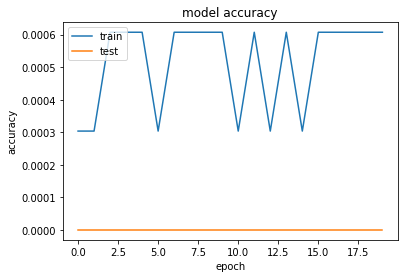

In [2115]:
model = fitModel(X_train,Y_train,X_val,Y_val)

### Make predictions

In [2116]:
#Makes predictions based on size of X_val
# Returns 1x4 row vector: testWeek,DC, Aggregated Nplus1CUBE Predictions & Actual orAggregated Nplus2CUBE Predictions & Actual
def makeDCPredictions(testWeek, scaler_target, model, X_val, targetVar, test_df,DC):
    #print(model.predict(X_val))
    y_pred_df = pd.DataFrame(data=scaler_target.inverse_transform(model.predict(X_val)), index=test_df.index, columns=[s + 'Prediction' for s in targetVar])
    y_actual_df = test_df[targetVar]
    y_joined_df = (y_pred_df.join(y_actual_df)).reset_index()
    y_joined_df = y_joined_df.drop('index',1)
    
    DC_joined_df = y_joined_df.groupby(y_joined_df.index // DCRegionPairs[DC]).sum()
    DC_joined_df.insert(loc=0,column='DC',value = DC)
    weeks=np.arange(testWeek,testWeek+DC_joined_df.shape[0])
    DC_joined_df.insert(loc=0,column='testWeek',value =weeks)
    return DC_joined_df

In [2117]:
DC_joined_df=makeDCPredictions(testWeek, scaler_target, model, X_val, targetVar, test_df,DC)

In [2118]:
DC_joined_df

testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       298   8           440532.6875  500732.678063

### Single Wrapper Function

In [ ]:
def DCPrediction(testWeek, DC, targetVar):
    train_df, test_df = createDataframes(DC, testWeek)
    scaled_train_df, scaled_test_df, scaler_target = custom_scaler(train_df, test_df, targetVar)
    X_train,Y_train,X_val,Y_val = train_test_split(scaled_train_df, scaled_test_df,targetVar)
    model = fitModel(X_train,Y_train,X_val,Y_val)
    DC_joined_df = makeDCPredictions(testWeek, scaler_target, model, X_val, targetVar, test_df,DC)
    return DC_joined_df

### All 52 weeks and all DCs

C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5430 samples, validate on 30 samples
Epoch 1/20
5430/5430 [==============================] - 0s 81us/step - loss: 0.0775 - acc: 3.6832e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/20
5430/5430 [==============================] - 0s 38us/step - loss: 0.0256 - acc: 3.6832e-04 - val_loss: 4.0676e-04 - val_acc: 0.0000e+00
Epoch 3/20
5430/5430 [==============================] - 0s 38us/step

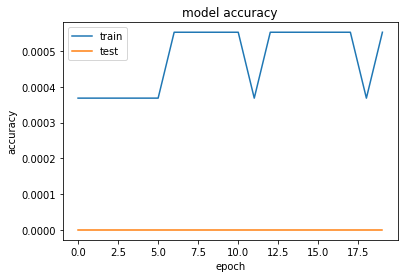

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       247   4          420298.59375  397818.799674


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5430 samples, validate on 30 samples
Epoch 1/20
5430/5430 [==============================] - 0s 77us/step - loss: 0.0894 - acc: 5.5249e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 2/20
5430/5430 [==============================] - 0s 47us/step - loss: 0.0270 - acc: 5.5249e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 3/20
5430/5430 [==============================] - 0s 41us/step - l

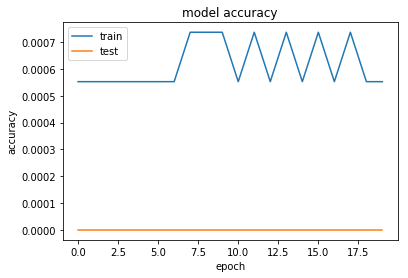

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       247   5          306479.28125  299361.761218


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2172 samples, validate on 12 samples
Epoch 1/20
2172/2172 [==============================] - 0s 145us/step - loss: 0.1426 - acc: 4.6041e-04 - val_loss: 0.0128 - val_acc: 0.0000e+00
Epoch 2/20
2172/2172 [==============================] - 0s 49us/step - loss: 0.0835 - acc: 4.6041e-04 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 3/20
2172/2172 [==============================] - 0s 42us/step - 

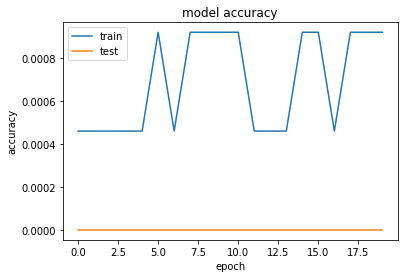

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       247   7         184764.671875  218772.545399


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3258 samples, validate on 18 samples
Epoch 1/20
3258/3258 [==============================] - 0s 110us/step - loss: 0.0736 - acc: 3.0694e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 2/20
3258/3258 [==============================] - 0s 44us/step - loss: 0.0404 - acc: 6.1387e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 3/20
3258/3258 [==============================] - 0s 38us/step - 

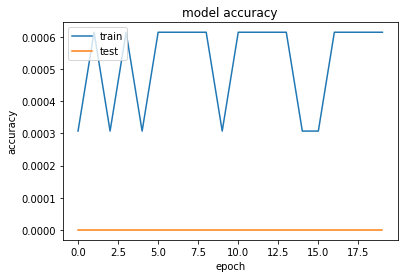

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       247   8              459832.0  442294.119701


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5460 samples, validate on 30 samples
Epoch 1/20
5460/5460 [==============================] - 0s 79us/step - loss: 0.1619 - acc: 5.4945e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 2/20
5460/5460 [==============================] - 0s 43us/step - loss: 0.0600 - acc: 3.6630e-04 - val_loss: 8.1683e-04 - val_acc: 0.0000e+00
Epoch 3/20
5460/5460 [==============================] - 0s 40us/step

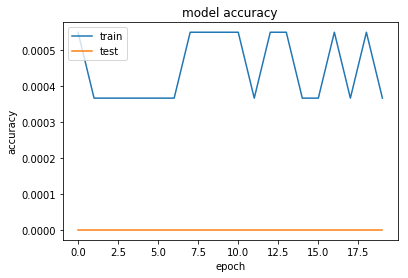

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       248   4          428582.65625  382216.414893


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5460 samples, validate on 30 samples
Epoch 1/20
5460/5460 [==============================] - 0s 81us/step - loss: 0.0554 - acc: 5.4945e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 2/20
5460/5460 [==============================] - 0s 44us/step - loss: 0.0189 - acc: 5.4945e-04 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 3/20
5460/5460 [==============================] - 0s 38us/step - l

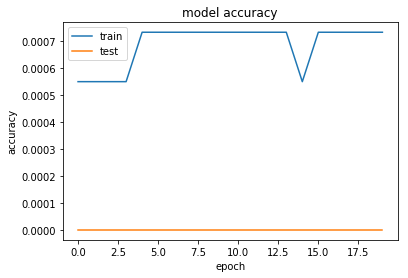

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       248   5           301692.1875  315313.392527


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2184 samples, validate on 12 samples
Epoch 1/20
2184/2184 [==============================] - 0s 129us/step - loss: 0.2125 - acc: 9.1575e-04 - val_loss: 0.0113 - val_acc: 0.0000e+00
Epoch 2/20
2184/2184 [==============================] - 0s 50us/step - loss: 0.1225 - acc: 4.5788e-04 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 3/20
2184/2184 [==============================] - 0s 39us/step - 

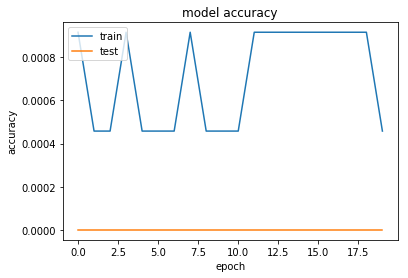

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       248   7          202563.21875  224483.515719


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3276 samples, validate on 18 samples
Epoch 1/20
3276/3276 [==============================] - 0s 103us/step - loss: 0.1102 - acc: 3.0525e-04 - val_loss: 0.0175 - val_acc: 0.0000e+00
Epoch 2/20
3276/3276 [==============================] - 0s 50us/step - loss: 0.0550 - acc: 3.0525e-04 - val_loss: 0.0112 - val_acc: 0.0000e+00
Epoch 3/20
3276/3276 [==============================] - ETA: 0s - loss:

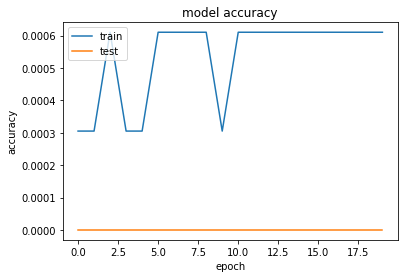

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       248   8          455779.71875  485248.742811


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5490 samples, validate on 30 samples
Epoch 1/20
5490/5490 [==============================] - 0s 83us/step - loss: 0.1060 - acc: 3.6430e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 2/20
5490/5490 [==============================] - 0s 44us/step - loss: 0.0374 - acc: 3.6430e-04 - val_loss: 3.3852e-04 - val_acc: 0.0000e+00
Epoch 3/20
5490/5490 [==============================] - 0s 38us/step

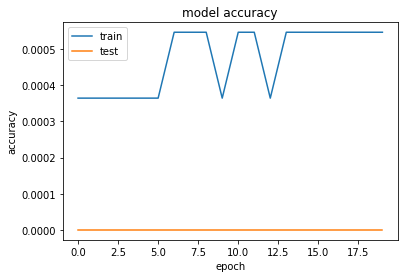

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       249   4              396001.5  385696.502809


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5490 samples, validate on 30 samples
Epoch 1/20
5490/5490 [==============================] - 0s 82us/step - loss: 0.1063 - acc: 7.2860e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 2/20
5490/5490 [==============================] - 0s 42us/step - loss: 0.0388 - acc: 5.4645e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 3/20
5490/5490 [==============================] - 0s 41us/step - l

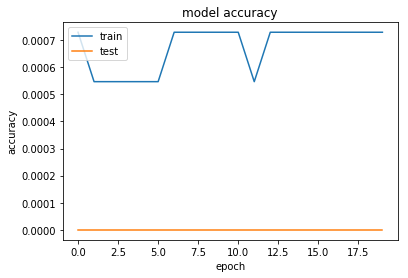

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       249   5          311845.71875  374914.918715


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2196 samples, validate on 12 samples
Epoch 1/20
2196/2196 [==============================] - 0s 144us/step - loss: 0.4279 - acc: 4.5537e-04 - val_loss: 0.2288 - val_acc: 0.0000e+00
Epoch 2/20
2196/2196 [==============================] - 0s 46us/step - loss: 0.1382 - acc: 4.5537e-04 - val_loss: 0.0316 - val_acc: 0.0000e+00
Epoch 3/20
2196/2196 [==============================] - 0s 38us/step - 

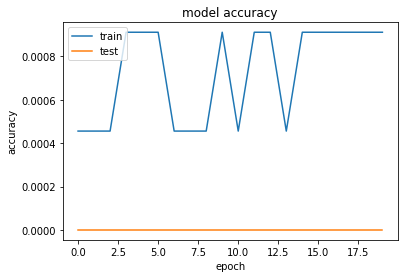

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       249   7         220989.484375  247279.128852


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3294 samples, validate on 18 samples
Epoch 1/20
3294/3294 [==============================] - 0s 113us/step - loss: 0.1114 - acc: 3.0358e-04 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 2/20
3294/3294 [==============================] - 0s 47us/step - loss: 0.0618 - acc: 6.0716e-04 - val_loss: 0.0087 - val_acc: 0.0000e+00
Epoch 3/20
3294/3294 [==============================] - 0s 43us/step - 

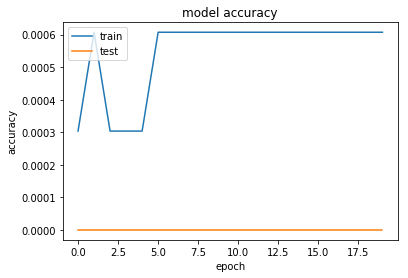

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       249   8            447107.625  501448.675138


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5520 samples, validate on 30 samples
Epoch 1/20
5520/5520 [==============================] - 0s 76us/step - loss: 0.1989 - acc: 1.8116e-04 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 2/20
5520/5520 [==============================] - 0s 42us/step - loss: 0.0633 - acc: 5.4348e-04 - val_loss: 6.6391e-04 - val_acc: 0.0000e+00
Epoch 3/20
5520/5520 [==============================] - 0s 40us/step

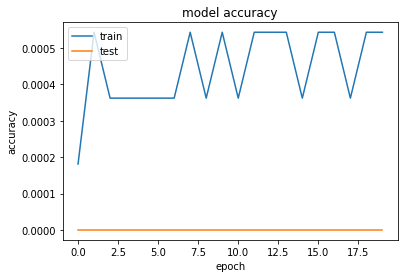

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       250   4           411014.9375  367261.048299


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5520 samples, validate on 30 samples
Epoch 1/20
5520/5520 [==============================] - 0s 79us/step - loss: 0.1180 - acc: 7.2464e-04 - val_loss: 0.0087 - val_acc: 0.0000e+00
Epoch 2/20
5520/5520 [==============================] - 0s 41us/step - loss: 0.0393 - acc: 5.4348e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 3/20
5520/5520 [==============================] - 0s 38us/step - l

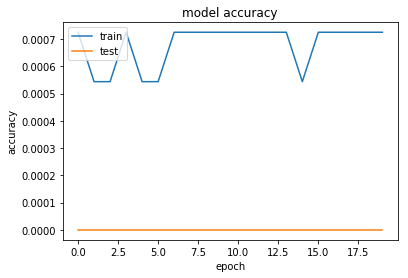

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       250   5           296303.8125  363849.087691


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2208 samples, validate on 12 samples
Epoch 1/20
2208/2208 [==============================] - 0s 142us/step - loss: 0.1178 - acc: 4.5290e-04 - val_loss: 0.0141 - val_acc: 0.0000e+00
Epoch 2/20
2208/2208 [==============================] - 0s 45us/step - loss: 0.0685 - acc: 9.0580e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 3/20
2208/2208 [==============================] - 0s 51us/step - 

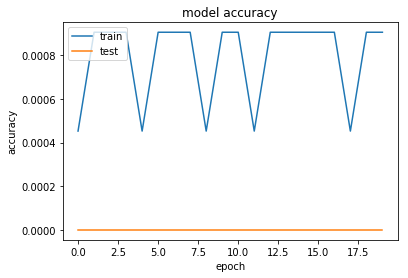

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       250   7             193409.25  231177.166646


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3312 samples, validate on 18 samples
Epoch 1/20
3312/3312 [==============================] - 0s 106us/step - loss: 0.1643 - acc: 0.0000e+00 - val_loss: 0.0197 - val_acc: 0.0000e+00
Epoch 2/20
3312/3312 [==============================] - 0s 46us/step - loss: 0.0631 - acc: 3.0193e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 3/20
3312/3312 [==============================] - 0s 42us/step - 

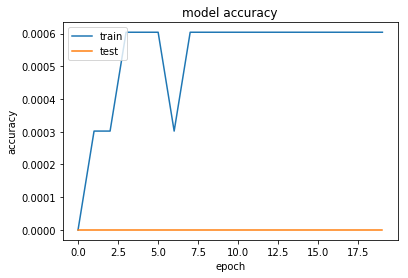

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       250   8          425984.46875  500732.678063


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5550 samples, validate on 30 samples
Epoch 1/20
5550/5550 [==============================] - 0s 88us/step - loss: 0.1682 - acc: 5.4054e-04 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 2/20
5550/5550 [==============================] - 0s 44us/step - loss: 0.0381 - acc: 3.6036e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 3/20
5550/5550 [==============================] - 0s 37us/step - l

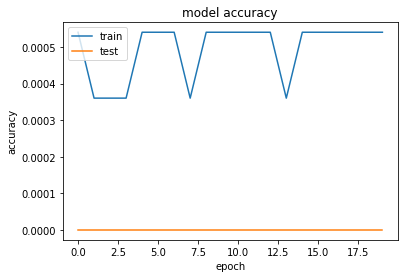

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       251   4            463099.375  386100.800524


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5550 samples, validate on 30 samples
Epoch 1/20
5550/5550 [==============================] - 0s 83us/step - loss: 0.1105 - acc: 5.4054e-04 - val_loss: 0.0120 - val_acc: 0.0000e+00
Epoch 2/20
5550/5550 [==============================] - 0s 46us/step - loss: 0.0285 - acc: 7.2072e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 3/20
5550/5550 [==============================] - 0s 40us/step - l

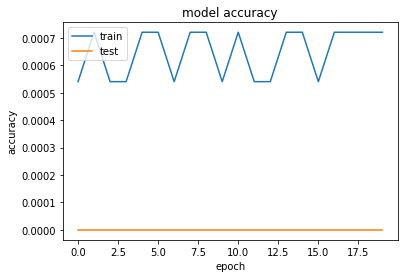

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       251   5              314381.0  345010.055232


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2220 samples, validate on 12 samples
Epoch 1/20
2220/2220 [==============================] - 0s 141us/step - loss: 0.2045 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 2/20
2220/2220 [==============================] - 0s 51us/step - loss: 0.1217 - acc: 4.5045e-04 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 3/20
2220/2220 [==============================] - 0s 43us/step - 

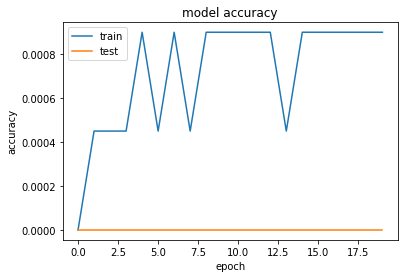

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       251   7         202898.171875  209428.669305


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3330 samples, validate on 18 samples
Epoch 1/20
3330/3330 [==============================] - 0s 111us/step - loss: 0.2599 - acc: 6.0060e-04 - val_loss: 0.0340 - val_acc: 0.0000e+00
Epoch 2/20
3330/3330 [==============================] - 0s 44us/step - loss: 0.0684 - acc: 3.0030e-04 - val_loss: 0.0172 - val_acc: 0.0000e+00
Epoch 3/20
3330/3330 [==============================] - 0s 40us/step - 

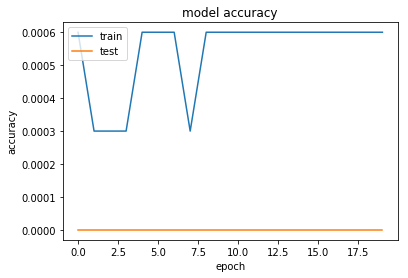

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       251   8          496769.15625  479238.363084


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5580 samples, validate on 30 samples
Epoch 1/20
5580/5580 [==============================] - 0s 80us/step - loss: 0.8860 - acc: 0.0000e+00 - val_loss: 0.0899 - val_acc: 0.0000e+00
Epoch 2/20
5580/5580 [==============================] - 0s 43us/step - loss: 0.0951 - acc: 1.7921e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 3/20
5580/5580 [==============================] - 0s 38us/step - l

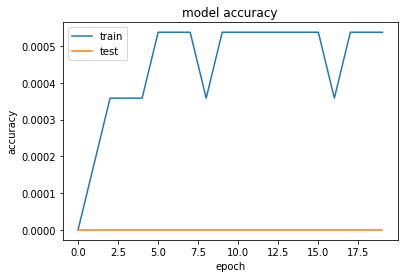

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       252   4          428224.15625  441412.33314


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5580 samples, validate on 30 samples
Epoch 1/20
5580/5580 [==============================] - 0s 79us/step - loss: 0.1848 - acc: 7.1685e-04 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 2/20
5580/5580 [==============================] - 0s 42us/step - loss: 0.0252 - acc: 5.3763e-04 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 3/20
5580/5580 [==============================] - 0s 37us/step - l

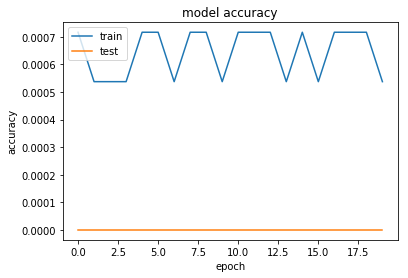

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       252   5          350544.65625  349684.938083


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2232 samples, validate on 12 samples
Epoch 1/20
2232/2232 [==============================] - 0s 139us/step - loss: 0.1832 - acc: 4.4803e-04 - val_loss: 0.0299 - val_acc: 0.0000e+00
Epoch 2/20
2232/2232 [==============================] - 0s 47us/step - loss: 0.1208 - acc: 4.4803e-04 - val_loss: 0.0121 - val_acc: 0.0000e+00
Epoch 3/20
2232/2232 [==============================] - 0s 44us/step - 

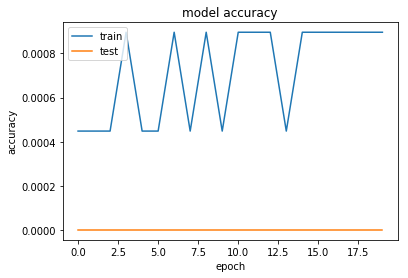

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       252   7          226202.96875  238148.544917


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3348 samples, validate on 18 samples
Epoch 1/20
3348/3348 [==============================] - 0s 104us/step - loss: 0.5653 - acc: 2.9869e-04 - val_loss: 0.4123 - val_acc: 0.0000e+00
Epoch 2/20
3348/3348 [==============================] - 0s 46us/step - loss: 0.2261 - acc: 2.9869e-04 - val_loss: 0.1387 - val_acc: 0.0000e+00
Epoch 3/20
3348/3348 [==============================] - 0s 40us/step - 

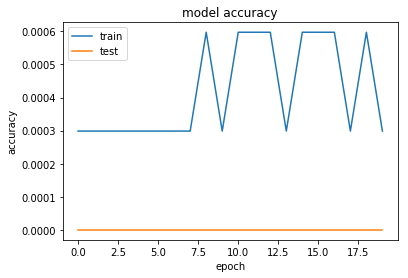

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       252   8             551826.75  509310.53053


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5610 samples, validate on 30 samples
Epoch 1/20
5610/5610 [==============================] - 0s 79us/step - loss: 0.2032 - acc: 1.7825e-04 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 2/20
5610/5610 [==============================] - 0s 39us/step - loss: 0.0374 - acc: 5.3476e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
5610/5610 [==============================] - 0s 37us/step - l

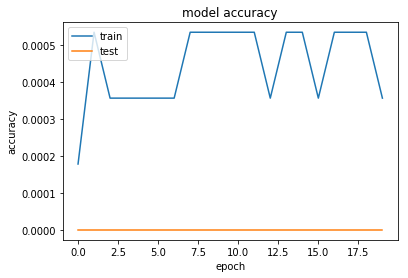

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       253   4             479819.25  534140.26915


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5610 samples, validate on 30 samples
Epoch 1/20
5610/5610 [==============================] - 0s 80us/step - loss: 0.0592 - acc: 5.3476e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 2/20
5610/5610 [==============================] - 0s 43us/step - loss: 0.0193 - acc: 5.3476e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 3/20
5610/5610 [==============================] - 0s 38us/step - l

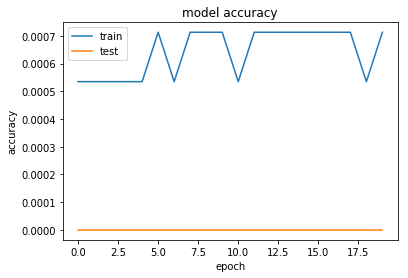

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       253   5           321505.4375  355037.302606


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2244 samples, validate on 12 samples
Epoch 1/20
2244/2244 [==============================] - 0s 131us/step - loss: 0.6472 - acc: 4.4563e-04 - val_loss: 0.5868 - val_acc: 0.0000e+00
Epoch 2/20
2244/2244 [==============================] - 0s 51us/step - loss: 0.2373 - acc: 4.4563e-04 - val_loss: 0.1829 - val_acc: 0.0000e+00
Epoch 3/20
2244/2244 [==============================] - 0s 46us/step - 

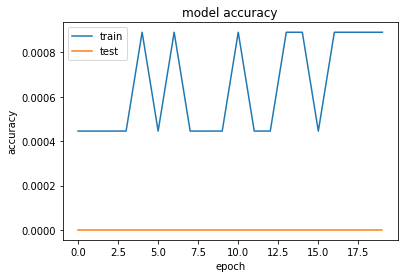

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       253   7           215347.9375  305185.522585


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3366 samples, validate on 18 samples
Epoch 1/20
3366/3366 [==============================] - 0s 99us/step - loss: 0.2308 - acc: 2.9709e-04 - val_loss: 0.0462 - val_acc: 0.0000e+00
Epoch 2/20
3366/3366 [==============================] - 0s 48us/step - loss: 0.0882 - acc: 5.9418e-04 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 3/20
3366/3366 [==============================] - 0s 42us/step - l

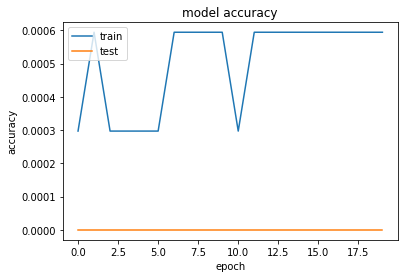

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       253   8          508131.34375  538431.10415


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5640 samples, validate on 30 samples
Epoch 1/20
5640/5640 [==============================] - 0s 76us/step - loss: 0.0706 - acc: 3.5461e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 2/20
5640/5640 [==============================] - 0s 43us/step - loss: 0.0213 - acc: 3.5461e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 3/20
5640/5640 [==============================] - 0s 43us/step - l

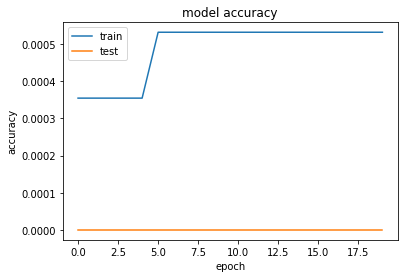

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       254   4          490324.65625  528980.609369


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5640 samples, validate on 30 samples
Epoch 1/20
5640/5640 [==============================] - 0s 82us/step - loss: 0.1231 - acc: 5.3191e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 2/20
5640/5640 [==============================] - 0s 44us/step - loss: 0.0422 - acc: 5.3191e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/20
5640/5640 [==============================] - 0s 39us/step - l

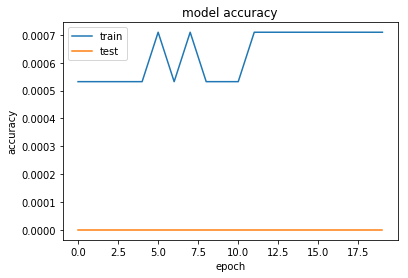

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       254   5           365072.8125  359818.29793


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2256 samples, validate on 12 samples
Epoch 1/20
2256/2256 [==============================] - 0s 135us/step - loss: 0.2575 - acc: 8.8652e-04 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 2/20
2256/2256 [==============================] - 0s 52us/step - loss: 0.1506 - acc: 4.4326e-04 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 3/20
2256/2256 [==============================] - 0s 42us/step - 

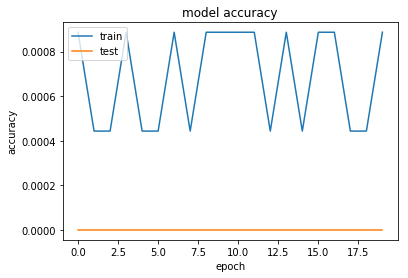

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       254   7            235517.875  239333.363073


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3384 samples, validate on 18 samples
Epoch 1/20
3384/3384 [==============================] - 0s 98us/step - loss: 0.1515 - acc: 2.9551e-04 - val_loss: 0.0263 - val_acc: 0.0000e+00
Epoch 2/20
3384/3384 [==============================] - 0s 46us/step - loss: 0.0509 - acc: 2.9551e-04 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 3/20
3384/3384 [==============================] - 0s 40us/step - l

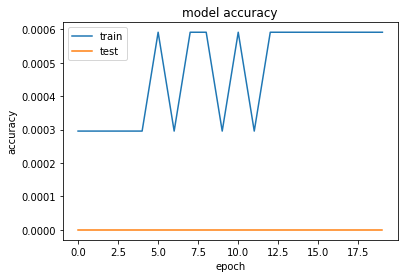

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       254   8          514883.46875  533092.625787


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5670 samples, validate on 30 samples
Epoch 1/20
5670/5670 [==============================] - 0s 75us/step - loss: 0.1333 - acc: 5.2910e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 2/20
5670/5670 [==============================] - 0s 44us/step - loss: 0.0371 - acc: 3.5273e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/20
5670/5670 [==============================] - 0s 37us/step - l

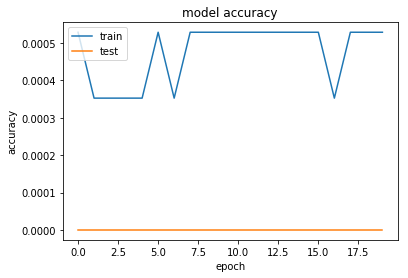

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       255   4           499286.1875  518252.502101


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5670 samples, validate on 30 samples
Epoch 1/20
5670/5670 [==============================] - 0s 82us/step - loss: 0.1165 - acc: 5.2910e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 2/20
5670/5670 [==============================] - 0s 37us/step - loss: 0.0354 - acc: 7.0547e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
5670/5670 [==============================] - 0s 39us/step - l

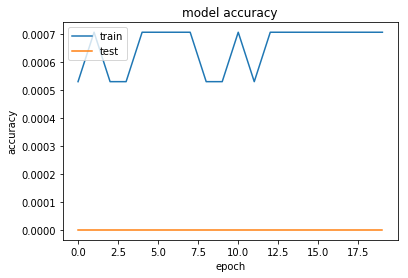

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       255   5           349470.4375  341731.405426


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2268 samples, validate on 12 samples
Epoch 1/20
2268/2268 [==============================] - 0s 143us/step - loss: 0.5960 - acc: 4.4092e-04 - val_loss: 0.3369 - val_acc: 0.0000e+00
Epoch 2/20
2268/2268 [==============================] - 0s 48us/step - loss: 0.2107 - acc: 4.4092e-04 - val_loss: 0.0482 - val_acc: 0.0000e+00
Epoch 3/20
2268/2268 [==============================] - 0s 44us/step - 

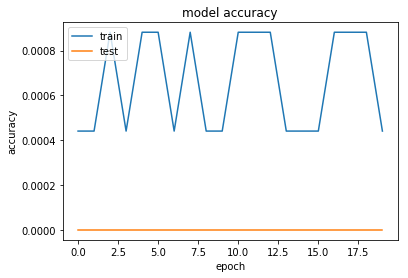

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       255   7         238826.984375  226416.821761


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3402 samples, validate on 18 samples
Epoch 1/20
3402/3402 [==============================] - 0s 107us/step - loss: 0.1308 - acc: 2.9394e-04 - val_loss: 0.0156 - val_acc: 0.0000e+00
Epoch 2/20
3402/3402 [==============================] - 0s 45us/step - loss: 0.0432 - acc: 5.8789e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 3/20
3402/3402 [==============================] - 0s 40us/step - 

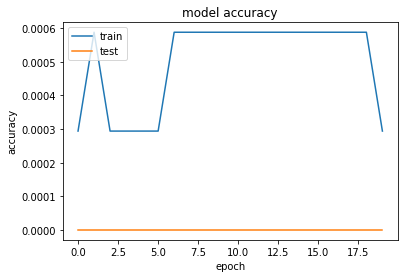

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       255   8            548354.125  542291.850877


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5700 samples, validate on 30 samples
Epoch 1/20
5700/5700 [==============================] - 0s 80us/step - loss: 0.0662 - acc: 3.5088e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 2/20
5700/5700 [==============================] - 0s 42us/step - loss: 0.0205 - acc: 3.5088e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
5700/5700 [==============================] - 0s 39us/step - l

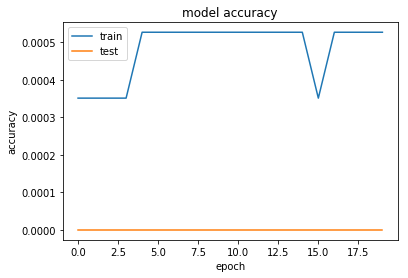

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       256   4              560013.0  548315.358245


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5700 samples, validate on 30 samples
Epoch 1/20
5700/5700 [==============================] - 0s 76us/step - loss: 0.0857 - acc: 5.2632e-04 - val_loss: 0.0221 - val_acc: 0.0000e+00
Epoch 2/20
5700/5700 [==============================] - 0s 43us/step - loss: 0.0272 - acc: 7.0175e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 3/20
5700/5700 [==============================] - 0s 41us/step - l

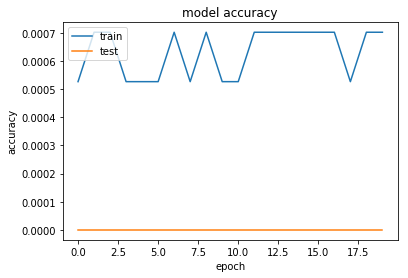

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       256   5           338080.4375  426552.681887


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2280 samples, validate on 12 samples
Epoch 1/20
2280/2280 [==============================] - 0s 146us/step - loss: 0.4028 - acc: 8.7719e-04 - val_loss: 0.0712 - val_acc: 0.0000e+00
Epoch 2/20
2280/2280 [==============================] - 0s 44us/step - loss: 0.1755 - acc: 4.3860e-04 - val_loss: 0.0524 - val_acc: 0.0000e+00
Epoch 3/20
2280/2280 [==============================] - 0s 42us/step - 

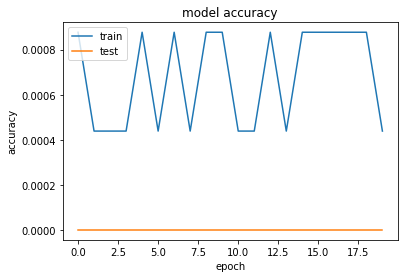

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       256   7              251574.0  283494.627649


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3420 samples, validate on 18 samples
Epoch 1/20
3420/3420 [==============================] - 0s 98us/step - loss: 0.1129 - acc: 0.0000e+00 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 2/20
3420/3420 [==============================] - 0s 44us/step - loss: 0.0595 - acc: 5.8480e-04 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 3/20
3420/3420 [==============================] - 0s 38us/step - l

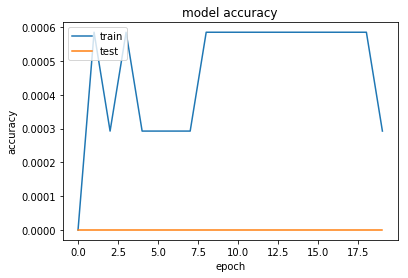

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       256   8           573277.4375  680014.004637


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5730 samples, validate on 30 samples
Epoch 1/20
5730/5730 [==============================] - 0s 78us/step - loss: 0.1552 - acc: 1.7452e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 2/20
5730/5730 [==============================] - 0s 46us/step - loss: 0.0398 - acc: 3.4904e-04 - val_loss: 6.9070e-04 - val_acc: 0.0000e+00
Epoch 3/20
5730/5730 [==============================] - 0s 37us/step

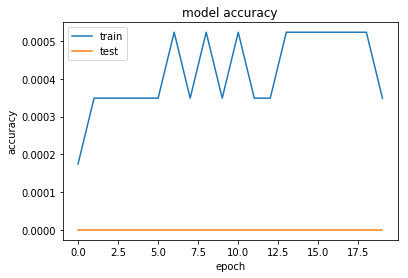

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       257   4          497249.28125  452273.940298


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5730 samples, validate on 30 samples
Epoch 1/20
5730/5730 [==============================] - 0s 77us/step - loss: 0.1797 - acc: 5.2356e-04 - val_loss: 0.0179 - val_acc: 0.0000e+00
Epoch 2/20
5730/5730 [==============================] - 0s 43us/step - loss: 0.0450 - acc: 5.2356e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 3/20
5730/5730 [==============================] - 0s 38us/step - l

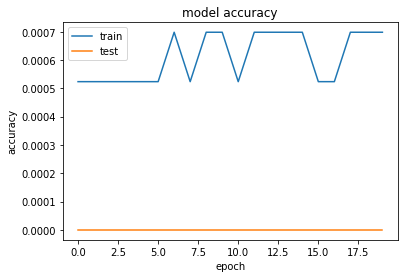

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       257   5          340378.15625  395721.268829


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2292 samples, validate on 12 samples
Epoch 1/20
2292/2292 [==============================] - 0s 140us/step - loss: 0.5122 - acc: 4.3630e-04 - val_loss: 0.1330 - val_acc: 0.0000e+00
Epoch 2/20
2292/2292 [==============================] - 0s 38us/step - loss: 0.1972 - acc: 0.0000e+00 - val_loss: 0.0389 - val_acc: 0.0000e+00
Epoch 3/20
2292/2292 [==============================] - 0s 37us/step - 

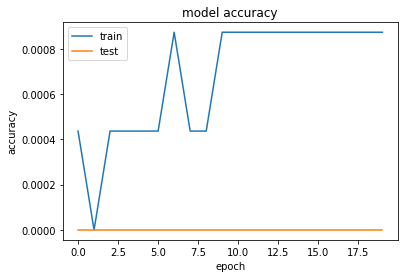

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       257   7            244970.125  202821.868648


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3438 samples, validate on 18 samples
Epoch 1/20
3438/3438 [==============================] - 0s 98us/step - loss: 0.1367 - acc: 2.9087e-04 - val_loss: 0.0302 - val_acc: 0.0000e+00
Epoch 2/20
3438/3438 [==============================] - 0s 43us/step - loss: 0.0703 - acc: 5.8173e-04 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 3/20
3438/3438 [==============================] - 0s 39us/step - l

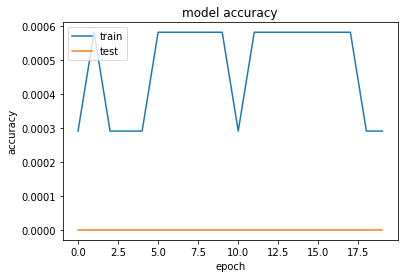

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       257   8          523522.21875  598207.481108


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5760 samples, validate on 30 samples
Epoch 1/20
5760/5760 [==============================] - 0s 75us/step - loss: 0.1431 - acc: 3.4722e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 2/20
5760/5760 [==============================] - 0s 44us/step - loss: 0.0258 - acc: 3.4722e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
5760/5760 [==============================] - 0s 40us/step - l

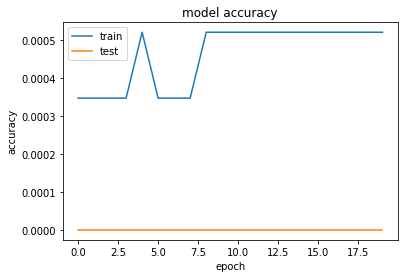

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       258   4           425694.4375  342788.333017


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5760 samples, validate on 30 samples
Epoch 1/20
5760/5760 [==============================] - 0s 76us/step - loss: 0.1734 - acc: 5.2083e-04 - val_loss: 0.0195 - val_acc: 0.0000e+00
Epoch 2/20
5760/5760 [==============================] - 0s 38us/step - loss: 0.0495 - acc: 6.9444e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 3/20
5760/5760 [==============================] - 0s 42us/step - l

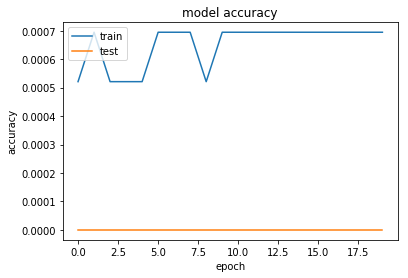

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       258   5             341045.25  339361.409582


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2304 samples, validate on 12 samples
Epoch 1/20
2304/2304 [==============================] - 0s 135us/step - loss: 0.2219 - acc: 0.0000e+00 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 2/20
2304/2304 [==============================] - 0s 48us/step - loss: 0.1241 - acc: 8.6806e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 3/20
2304/2304 [==============================] - 0s 40us/step - 

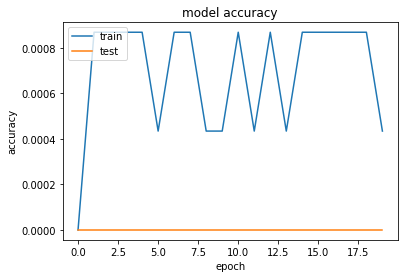

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       258   7         202659.890625  155423.62104


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3456 samples, validate on 18 samples
Epoch 1/20
3456/3456 [==============================] - 0s 94us/step - loss: 0.5898 - acc: 2.8935e-04 - val_loss: 0.3120 - val_acc: 0.0000e+00
Epoch 2/20
3456/3456 [==============================] - 0s 43us/step - loss: 0.1610 - acc: 2.8935e-04 - val_loss: 0.0262 - val_acc: 0.0000e+00
Epoch 3/20
3456/3456 [==============================] - 0s 38us/step - l

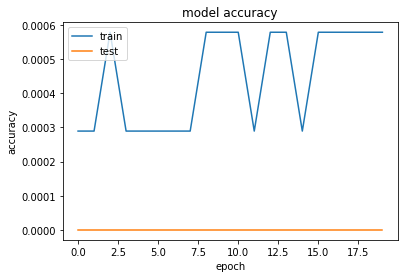

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       258   8            575552.125  492495.53611


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5790 samples, validate on 30 samples
Epoch 1/20
5790/5790 [==============================] - 0s 80us/step - loss: 0.1078 - acc: 3.4542e-04 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 2/20
5790/5790 [==============================] - 0s 42us/step - loss: 0.0357 - acc: 3.4542e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
5790/5790 [==============================] - 0s 36us/step - l

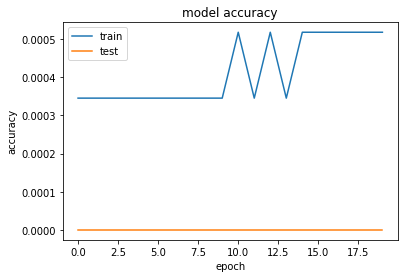

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       259   4          366351.71875  428171.958509


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5790 samples, validate on 30 samples
Epoch 1/20
5790/5790 [==============================] - 0s 75us/step - loss: 0.7179 - acc: 3.4542e-04 - val_loss: 0.0624 - val_acc: 0.0000e+00
Epoch 2/20
5790/5790 [==============================] - 0s 44us/step - loss: 0.1126 - acc: 3.4542e-04 - val_loss: 0.0223 - val_acc: 0.0000e+00
Epoch 3/20
5790/5790 [==============================] - 0s 40us/step - l

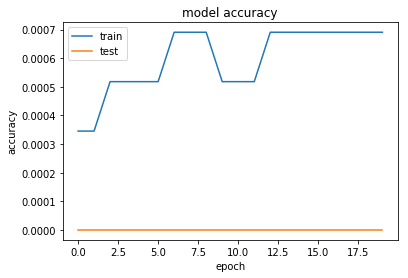

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       259   5          305988.84375  399373.784141


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2316 samples, validate on 12 samples
Epoch 1/20
2316/2316 [==============================] - 0s 151us/step - loss: 0.1131 - acc: 4.3178e-04 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 2/20
2316/2316 [==============================] - 0s 45us/step - loss: 0.0730 - acc: 4.3178e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 3/20
2316/2316 [==============================] - 0s 39us/step - 

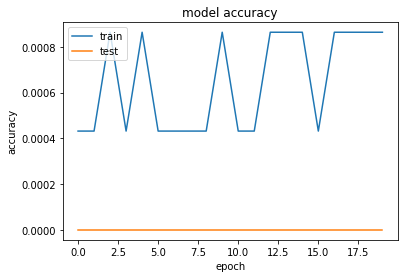

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       259   7         184642.515625  174791.415957


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3474 samples, validate on 18 samples
Epoch 1/20
3474/3474 [==============================] - 0s 101us/step - loss: 0.1503 - acc: 2.8785e-04 - val_loss: 0.0231 - val_acc: 0.0000e+00
Epoch 2/20
3474/3474 [==============================] - 0s 45us/step - loss: 0.0699 - acc: 2.8785e-04 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 3/20
3474/3474 [==============================] - 0s 39us/step - 

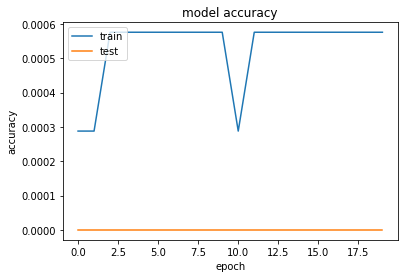

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       259   8          429929.46875  633240.218663


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5820 samples, validate on 30 samples
Epoch 1/20
5820/5820 [==============================] - 0s 80us/step - loss: 0.0655 - acc: 3.4364e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 2/20
5820/5820 [==============================] - 0s 45us/step - loss: 0.0202 - acc: 3.4364e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
5820/5820 [==============================] - 0s 39us/step - l

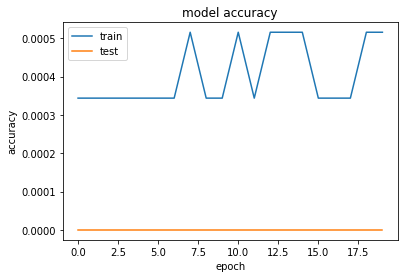

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       260   4          330111.09375  377791.942762


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5820 samples, validate on 30 samples
Epoch 1/20
5820/5820 [==============================] - 0s 78us/step - loss: 0.0904 - acc: 5.1546e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
5820/5820 [==============================] - 0s 43us/step - loss: 0.0290 - acc: 5.1546e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 3/20
5820/5820 [==============================] - 0s 40us/step - l

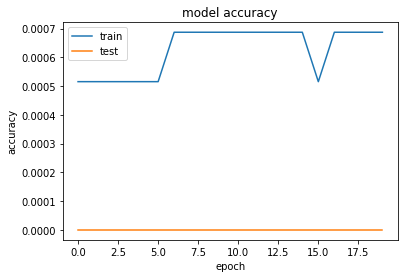

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       260   5          283282.84375  275472.578259


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2328 samples, validate on 12 samples
Epoch 1/20
2328/2328 [==============================] - 0s 133us/step - loss: 0.4599 - acc: 4.2955e-04 - val_loss: 0.1787 - val_acc: 0.0000e+00
Epoch 2/20
2328/2328 [==============================] - 0s 43us/step - loss: 0.1265 - acc: 4.2955e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 3/20
2328/2328 [==============================] - 0s 40us/step - 

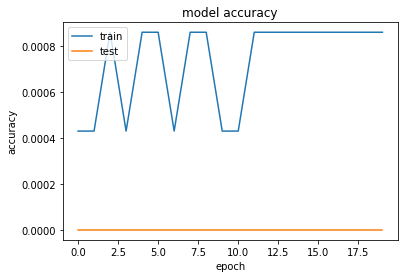

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       260   7         163852.703125  153640.894671


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3492 samples, validate on 18 samples
Epoch 1/20
3492/3492 [==============================] - 0s 111us/step - loss: 0.2405 - acc: 2.8637e-04 - val_loss: 0.0371 - val_acc: 0.0000e+00
Epoch 2/20
3492/3492 [==============================] - 0s 42us/step - loss: 0.0940 - acc: 2.8637e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 3/20
3492/3492 [==============================] - 0s 38us/step - 

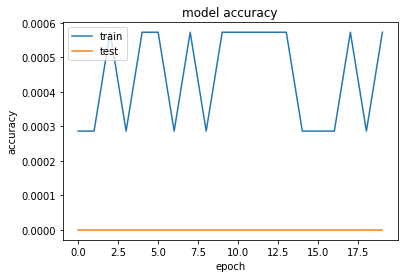

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       260   8          446041.96875  419388.936094


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5850 samples, validate on 30 samples
Epoch 1/20
5850/5850 [==============================] - 0s 73us/step - loss: 0.1154 - acc: 3.4188e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/20
5850/5850 [==============================] - 0s 42us/step - loss: 0.0367 - acc: 3.4188e-04 - val_loss: 9.0418e-04 - val_acc: 0.0000e+00
Epoch 3/20
5850/5850 [==============================] - 0s 38us/step

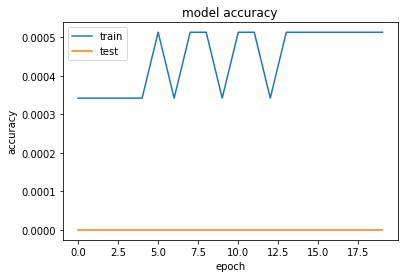

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       261   4          366292.03125  359791.125812


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5850 samples, validate on 30 samples
Epoch 1/20
5850/5850 [==============================] - 0s 79us/step - loss: 0.2721 - acc: 3.4188e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 2/20
5850/5850 [==============================] - 0s 41us/step - loss: 0.0442 - acc: 5.1282e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 3/20
5850/5850 [==============================] - 0s 37us/step - l

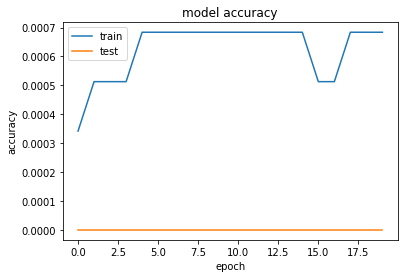

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       261   5         242269.265625  258341.937887


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2340 samples, validate on 12 samples
Epoch 1/20
2340/2340 [==============================] - 0s 132us/step - loss: 0.6218 - acc: 4.2735e-04 - val_loss: 0.3442 - val_acc: 0.0000e+00
Epoch 2/20
2340/2340 [==============================] - 0s 48us/step - loss: 0.2773 - acc: 4.2735e-04 - val_loss: 0.1080 - val_acc: 0.0000e+00
Epoch 3/20
2340/2340 [==============================] - 0s 45us/step - 

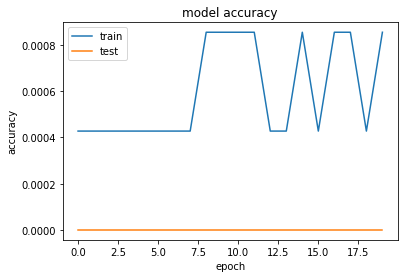

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       261   7         167825.453125  134344.015361


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3510 samples, validate on 18 samples
Epoch 1/20
3510/3510 [==============================] - 0s 97us/step - loss: 0.0723 - acc: 5.6980e-04 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 2/20
3510/3510 [==============================] - 0s 45us/step - loss: 0.0361 - acc: 2.8490e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 3/20
3510/3510 [==============================] - 0s 43us/step - l

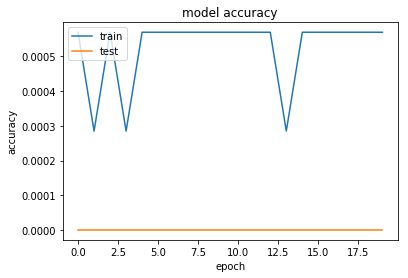

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       261   8           369979.4375  365104.338922


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5880 samples, validate on 30 samples
Epoch 1/20
5880/5880 [==============================] - 0s 76us/step - loss: 0.0994 - acc: 1.7007e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 2/20
5880/5880 [==============================] - 0s 42us/step - loss: 0.0234 - acc: 3.4014e-04 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 3/20
5880/5880 [==============================] - 0s 38us/step - l

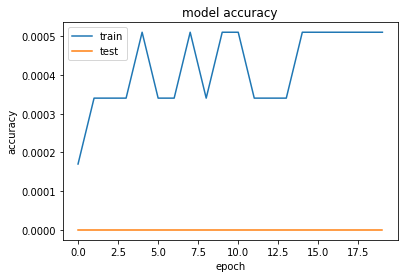

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       262   4          382830.59375  363505.81961


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5880 samples, validate on 30 samples
Epoch 1/20
5880/5880 [==============================] - 0s 72us/step - loss: 0.1178 - acc: 5.1020e-04 - val_loss: 0.0286 - val_acc: 0.0000e+00
Epoch 2/20
5880/5880 [==============================] - 0s 41us/step - loss: 0.0327 - acc: 5.1020e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 3/20
5880/5880 [==============================] - 0s 37us/step - l

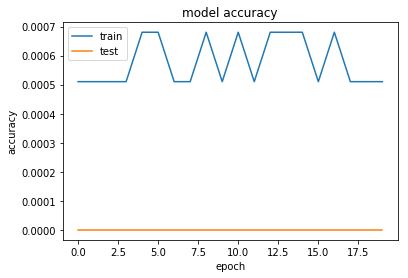

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       262   5         226194.546875  242855.735436


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2352 samples, validate on 12 samples
Epoch 1/20
2352/2352 [==============================] - 0s 127us/step - loss: 0.6253 - acc: 4.2517e-04 - val_loss: 0.2831 - val_acc: 0.0000e+00
Epoch 2/20
2352/2352 [==============================] - 0s 44us/step - loss: 0.2084 - acc: 4.2517e-04 - val_loss: 0.0492 - val_acc: 0.0000e+00
Epoch 3/20
2352/2352 [==============================] - 0s 37us/step - 

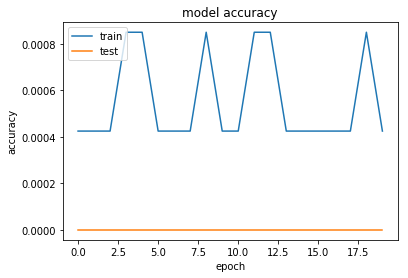

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       262   7         155064.265625  122577.459255


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3528 samples, validate on 18 samples
Epoch 1/20
3528/3528 [==============================] - 0s 98us/step - loss: 0.1453 - acc: 2.8345e-04 - val_loss: 0.0192 - val_acc: 0.0000e+00
Epoch 2/20
3528/3528 [==============================] - 0s 45us/step - loss: 0.0743 - acc: 5.6689e-04 - val_loss: 0.0130 - val_acc: 0.0000e+00
Epoch 3/20
3528/3528 [==============================] - 0s 40us/step - l

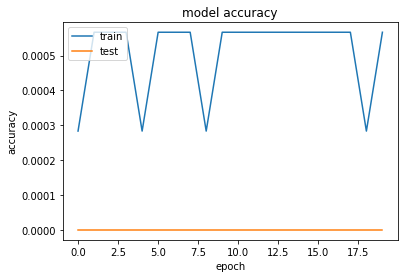

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       262   8            329383.875  298707.170916


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5910 samples, validate on 30 samples
Epoch 1/20
5910/5910 [==============================] - 0s 77us/step - loss: 0.0973 - acc: 3.3841e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 2/20
5910/5910 [==============================] - 0s 43us/step - loss: 0.0293 - acc: 5.0761e-04 - val_loss: 7.4669e-04 - val_acc: 0.0000e+00
Epoch 3/20
5910/5910 [==============================] - 0s 40us/step

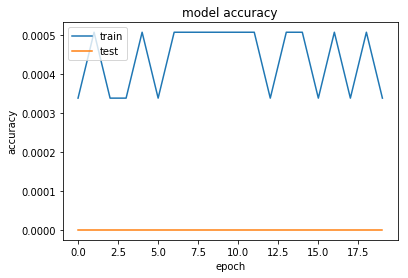

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       263   4           364628.6875  318812.568643


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5910 samples, validate on 30 samples
Epoch 1/20
5910/5910 [==============================] - 0s 83us/step - loss: 0.0851 - acc: 6.7682e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 2/20
5910/5910 [==============================] - 0s 40us/step - loss: 0.0277 - acc: 5.0761e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 3/20
5910/5910 [==============================] - 0s 37us/step - l

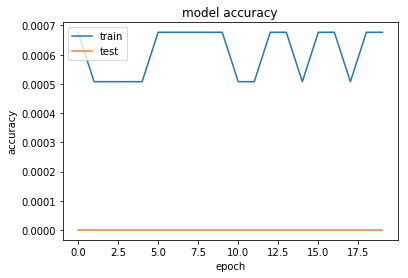

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       263   5         216811.578125  234152.627589


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2364 samples, validate on 12 samples
Epoch 1/20
2364/2364 [==============================] - 0s 138us/step - loss: 0.1251 - acc: 4.2301e-04 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epoch 2/20
2364/2364 [==============================] - 0s 43us/step - loss: 0.0751 - acc: 4.2301e-04 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 3/20
2364/2364 [==============================] - 0s 41us/step - 

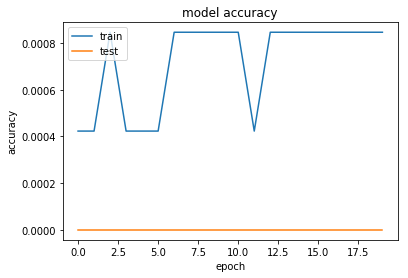

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       263   7         130470.242188  116871.112081


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3546 samples, validate on 18 samples
Epoch 1/20
3546/3546 [==============================] - 0s 107us/step - loss: 0.2697 - acc: 2.8201e-04 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 2/20
3546/3546 [==============================] - 0s 58us/step - loss: 0.0717 - acc: 5.6402e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 3/20
3546/3546 [==============================] - 0s 48us/step - 

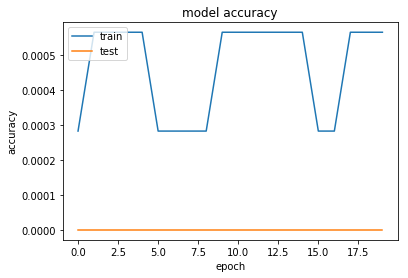

   testWeek  DC  Nplus1CUBEPrediction  Nplus1CUBE
0       263   8             294390.75    383201.6


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5940 samples, validate on 30 samples
Epoch 1/20
5940/5940 [==============================] - 0s 74us/step - loss: 0.0707 - acc: 5.0505e-04 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 2/20
5940/5940 [==============================] - 0s 43us/step - loss: 0.0211 - acc: 3.3670e-04 - val_loss: 9.4150e-04 - val_acc: 0.0000e+00
Epoch 3/20
5940/5940 [==============================] - 0s 37us/step

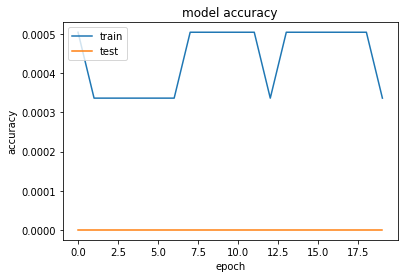

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       264   4          310920.59375  283821.890919


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5940 samples, validate on 30 samples
Epoch 1/20
5940/5940 [==============================] - 0s 81us/step - loss: 0.1365 - acc: 5.0505e-04 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 2/20
5940/5940 [==============================] - 0s 44us/step - loss: 0.0410 - acc: 5.0505e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 3/20
5940/5940 [==============================] - 0s 39us/step - l

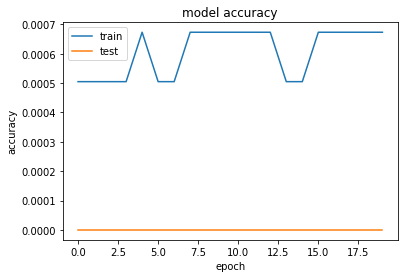

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       264   5           220289.8125  214768.462203


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2376 samples, validate on 12 samples
Epoch 1/20
2376/2376 [==============================] - 0s 132us/step - loss: 0.1721 - acc: 4.2088e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 2/20
2376/2376 [==============================] - 0s 47us/step - loss: 0.1078 - acc: 4.2088e-04 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 3/20
2376/2376 [==============================] - 0s 43us/step - 

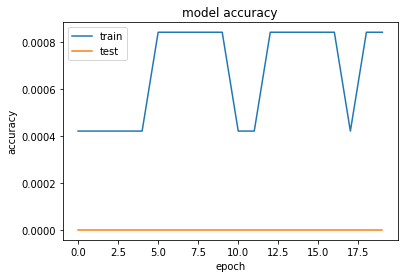

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       264   7         115952.664062  115275.593662


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3564 samples, validate on 18 samples
Epoch 1/20
3564/3564 [==============================] - 0s 98us/step - loss: 0.0433 - acc: 2.8058e-04 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 2/20
3564/3564 [==============================] - 0s 49us/step - loss: 0.0255 - acc: 2.8058e-04 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 3/20
3564/3564 [==============================] - 0s 42us/step - l

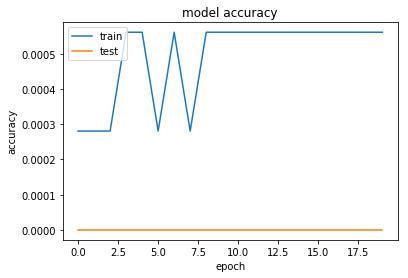

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       264   8          302186.09375  357074.447027


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5970 samples, validate on 30 samples
Epoch 1/20
5970/5970 [==============================] - 0s 72us/step - loss: 0.1041 - acc: 3.3501e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 2/20
5970/5970 [==============================] - 0s 41us/step - loss: 0.0290 - acc: 3.3501e-04 - val_loss: 4.5846e-04 - val_acc: 0.0000e+00
Epoch 3/20
5970/5970 [==============================] - 0s 39us/step

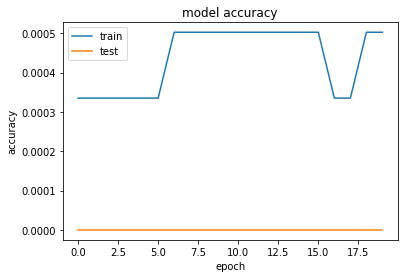

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       265   4          316926.46875  299040.15713


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5970 samples, validate on 30 samples
Epoch 1/20
5970/5970 [==============================] - 0s 72us/step - loss: 0.0924 - acc: 5.0251e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 2/20
5970/5970 [==============================] - 0s 42us/step - loss: 0.0299 - acc: 5.0251e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/20
5970/5970 [==============================] - 0s 37us/step - l

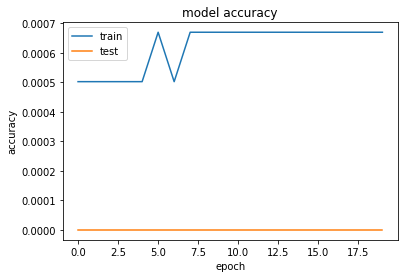

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       265   5          213550.96875  207377.661968


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2388 samples, validate on 12 samples
Epoch 1/20
2388/2388 [==============================] - 0s 131us/step - loss: 0.1896 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 2/20
2388/2388 [==============================] - 0s 46us/step - loss: 0.1157 - acc: 4.1876e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 3/20
2388/2388 [==============================] - 0s 39us/step - 

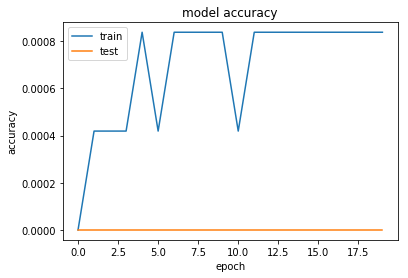

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       265   7         111428.398438  127986.550962


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3582 samples, validate on 18 samples
Epoch 1/20
3582/3582 [==============================] - 0s 111us/step - loss: 0.1136 - acc: 2.7917e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 2/20
3582/3582 [==============================] - 0s 40us/step - loss: 0.0557 - acc: 5.5835e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
3582/3582 [==============================] - 0s 36us/step - 

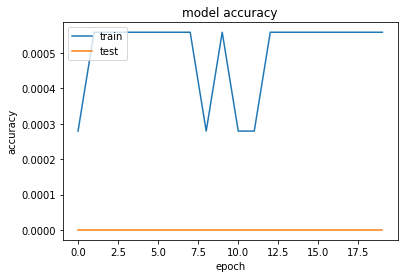

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       265   8           312596.0625  350075.848447


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 30 samples
Epoch 1/20
6000/6000 [==============================] - 0s 80us/step - loss: 0.0624 - acc: 3.3333e-04 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 2/20
6000/6000 [==============================] - 0s 44us/step - loss: 0.0183 - acc: 3.3333e-04 - val_loss: 4.6181e-04 - val_acc: 0.0000e+00
Epoch 3/20
6000/6000 [==============================] - 0s 43us/step

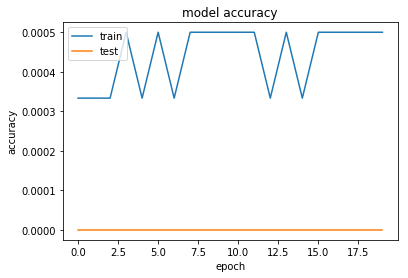

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       266   4            301813.625  265555.613642


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 30 samples
Epoch 1/20
6000/6000 [==============================] - 0s 82us/step - loss: 0.0675 - acc: 5.0000e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
6000/6000 [==============================] - 0s 47us/step - loss: 0.0201 - acc: 5.0000e-04 - val_loss: 8.6345e-04 - val_acc: 0.0000e+00
Epoch 3/20
6000/6000 [==============================] - 0s 38us/step

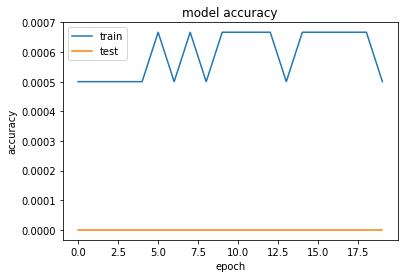

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       266   5            210754.875  232488.838307


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2400 samples, validate on 12 samples
Epoch 1/20
2400/2400 [==============================] - 0s 142us/step - loss: 0.1829 - acc: 4.1667e-04 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 2/20
2400/2400 [==============================] - 0s 47us/step - loss: 0.0966 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 3/20
2400/2400 [==============================] - 0s 41us/step - 

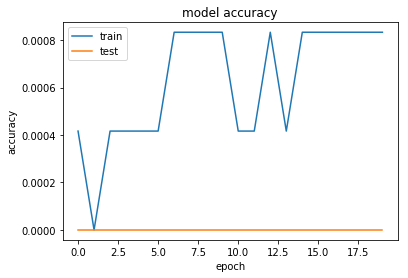

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       266   7         114904.773438  105587.552927


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3600 samples, validate on 18 samples
Epoch 1/20
3600/3600 [==============================] - 0s 102us/step - loss: 0.2641 - acc: 2.7778e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 2/20
3600/3600 [==============================] - 0s 46us/step - loss: 0.0955 - acc: 2.7778e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 3/20
3600/3600 [==============================] - 0s 39us/step - 

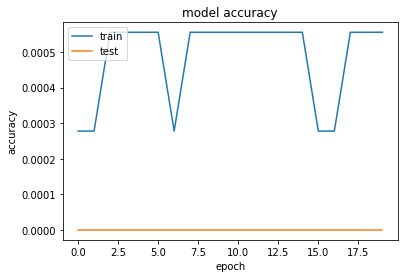

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       266   8           320616.5625  264976.430103


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6030 samples, validate on 30 samples
Epoch 1/20
6030/6030 [==============================] - 0s 77us/step - loss: 0.1291 - acc: 1.6584e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00
Epoch 2/20
6030/6030 [==============================] - 0s 46us/step - loss: 0.0386 - acc: 3.3167e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 3/20
6030/6030 [==============================] - 0s 39us/step - l

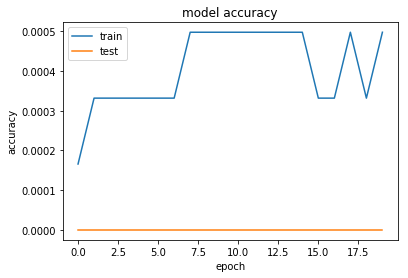

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       267   4          284209.96875  234862.385081


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6030 samples, validate on 30 samples
Epoch 1/20
6030/6030 [==============================] - 0s 73us/step - loss: 0.2260 - acc: 4.9751e-04 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 2/20
6030/6030 [==============================] - 0s 40us/step - loss: 0.0548 - acc: 4.9751e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 3/20
6030/6030 [==============================] - 0s 37us/step - l

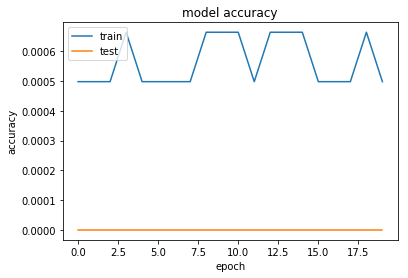

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       267   5         205690.453125  234968.635775


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2412 samples, validate on 12 samples
Epoch 1/20
2412/2412 [==============================] - 0s 132us/step - loss: 0.1115 - acc: 4.1459e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 2/20
2412/2412 [==============================] - 0s 48us/step - loss: 0.0667 - acc: 4.1459e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
2412/2412 [==============================] - 0s 40us/step - 

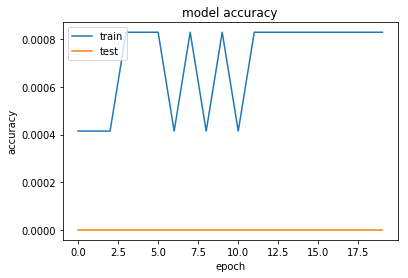

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       267   7         107687.695312  102790.916834


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3618 samples, validate on 18 samples
Epoch 1/20
3618/3618 [==============================] - 0s 103us/step - loss: 0.1242 - acc: 5.5279e-04 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 2/20
3618/3618 [==============================] - 0s 45us/step - loss: 0.0640 - acc: 5.5279e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/20
3618/3618 [==============================] - 0s 41us/step - 

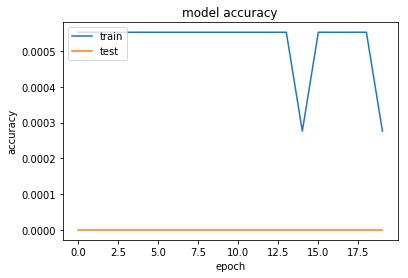

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       267   8              268870.0  242568.323856


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6060 samples, validate on 30 samples
Epoch 1/20
6060/6060 [==============================] - 0s 75us/step - loss: 0.0505 - acc: 3.3003e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 2/20
6060/6060 [==============================] - 0s 43us/step - loss: 0.0138 - acc: 3.3003e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 3/20
6060/6060 [==============================] - 0s 37us/step - l

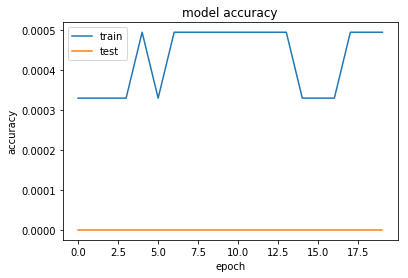

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       268   4          291384.46875  256330.244288


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6060 samples, validate on 30 samples
Epoch 1/20
6060/6060 [==============================] - 0s 76us/step - loss: 0.0972 - acc: 6.6007e-04 - val_loss: 9.7956e-04 - val_acc: 0.0000e+00
Epoch 2/20
6060/6060 [==============================] - 0s 41us/step - loss: 0.0297 - acc: 4.9505e-04 - val_loss: 6.5718e-04 - val_acc: 0.0000e+00
Epoch 3/20
6060/6060 [==============================] - 0s 36us/

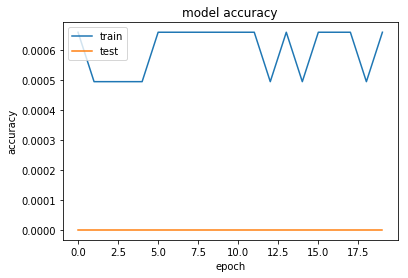

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       268   5         210615.359375  215537.961282


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2424 samples, validate on 12 samples
Epoch 1/20
2424/2424 [==============================] - 0s 133us/step - loss: 0.1552 - acc: 4.1254e-04 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 2/20
2424/2424 [==============================] - 0s 50us/step - loss: 0.0936 - acc: 8.2508e-04 - val_loss: 0.0129 - val_acc: 0.0000e+00
Epoch 3/20
2424/2424 [==============================] - 0s 40us/step - 

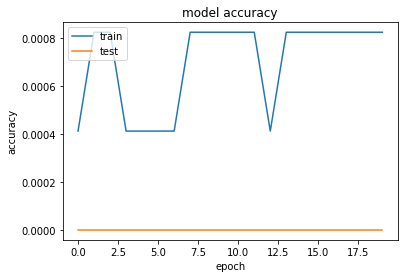

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       268   7         121083.710938  105067.67855


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3636 samples, validate on 18 samples
Epoch 1/20
3636/3636 [==============================] - 0s 99us/step - loss: 0.4010 - acc: 5.5006e-04 - val_loss: 0.0203 - val_acc: 0.0000e+00
Epoch 2/20
3636/3636 [==============================] - 0s 42us/step - loss: 0.1247 - acc: 2.7503e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 3/20
3636/3636 [==============================] - 0s 38us/step - l

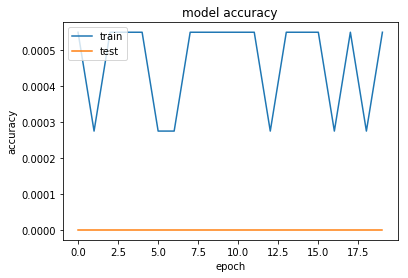

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       268   8             268899.75  264397.156173


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6090 samples, validate on 30 samples
Epoch 1/20
6090/6090 [==============================] - 1s 83us/step - loss: 0.0890 - acc: 4.9261e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 2/20
6090/6090 [==============================] - 0s 46us/step - loss: 0.0232 - acc: 3.2841e-04 - val_loss: 6.9819e-04 - val_acc: 0.0000e+00
Epoch 3/20
6090/6090 [==============================] - 0s 39us/step

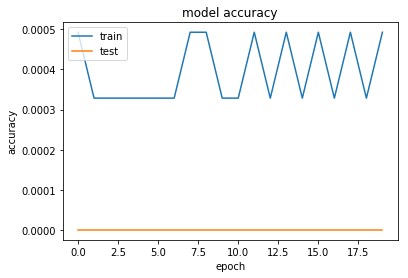

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       269   4          300589.84375  266050.944931


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6090 samples, validate on 30 samples
Epoch 1/20
6090/6090 [==============================] - 0s 75us/step - loss: 0.0656 - acc: 4.9261e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 2/20
6090/6090 [==============================] - 0s 44us/step - loss: 0.0196 - acc: 4.9261e-04 - val_loss: 8.8952e-04 - val_acc: 0.0000e+00
Epoch 3/20
6090/6090 [==============================] - 0s 39us/step

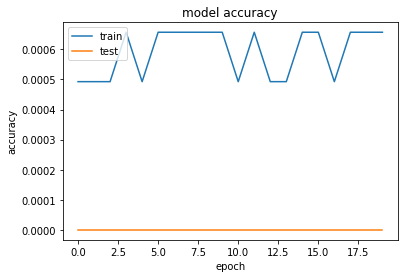

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       269   5            226896.375  212897.281576


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2436 samples, validate on 12 samples
Epoch 1/20
2436/2436 [==============================] - 0s 127us/step - loss: 0.1688 - acc: 8.2102e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 2/20
2436/2436 [==============================] - 0s 46us/step - loss: 0.1103 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 3/20
2436/2436 [==============================] - 0s 42us/step - 

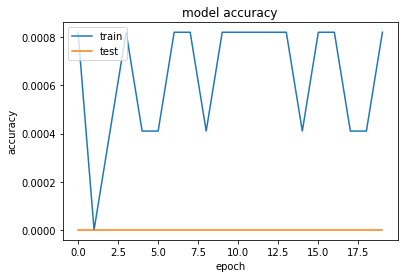

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       269   7          139283.65625  106928.58125


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3654 samples, validate on 18 samples
Epoch 1/20
3654/3654 [==============================] - 0s 98us/step - loss: 0.3910 - acc: 5.4735e-04 - val_loss: 0.0175 - val_acc: 0.0000e+00
Epoch 2/20
3654/3654 [==============================] - 0s 38us/step - loss: 0.1298 - acc: 2.7367e-04 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 3/20
3654/3654 [==============================] - 0s 38us/step - l

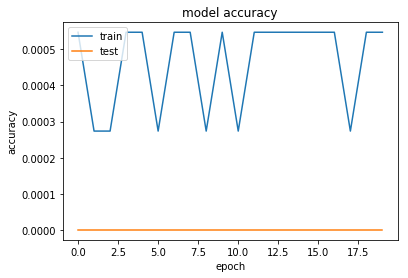

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       269   8          270868.84375  299436.615509


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6120 samples, validate on 30 samples
Epoch 1/20
6120/6120 [==============================] - 0s 79us/step - loss: 0.0760 - acc: 3.2680e-04 - val_loss: 7.1312e-04 - val_acc: 0.0000e+00
Epoch 2/20
6120/6120 [==============================] - 0s 44us/step - loss: 0.0211 - acc: 3.2680e-04 - val_loss: 7.5170e-04 - val_acc: 0.0000e+00
Epoch 3/20
6120/6120 [==============================] - 0s 35us/

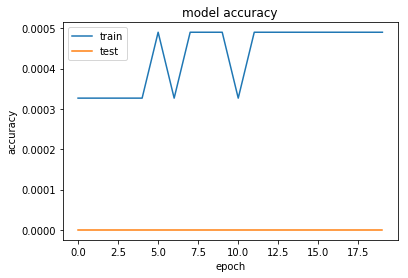

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       270   4          350191.65625  285367.192979


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6120 samples, validate on 30 samples
Epoch 1/20
6120/6120 [==============================] - 0s 74us/step - loss: 0.0899 - acc: 4.9020e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 2/20
6120/6120 [==============================] - 0s 41us/step - loss: 0.0253 - acc: 4.9020e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
6120/6120 [==============================] - 0s 37us/step - l

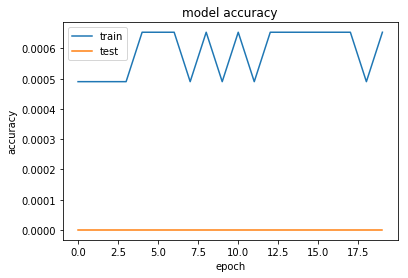

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       270   5         254405.984375  223340.860889


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2448 samples, validate on 12 samples
Epoch 1/20
2448/2448 [==============================] - 0s 115us/step - loss: 0.7420 - acc: 4.0850e-04 - val_loss: 0.3908 - val_acc: 0.0000e+00
Epoch 2/20
2448/2448 [==============================] - 0s 44us/step - loss: 0.3474 - acc: 4.0850e-04 - val_loss: 0.1204 - val_acc: 0.0000e+00
Epoch 3/20
2448/2448 [==============================] - 0s 40us/step - 

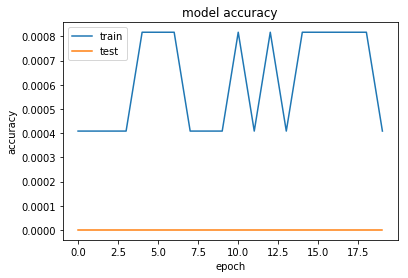

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       270   7         128153.664062  120349.780634


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3672 samples, validate on 18 samples
Epoch 1/20
3672/3672 [==============================] - 0s 98us/step - loss: 0.1072 - acc: 2.7233e-04 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 2/20
3672/3672 [==============================] - 0s 42us/step - loss: 0.0491 - acc: 2.7233e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 3/20
3672/3672 [==============================] - 0s 44us/step - l

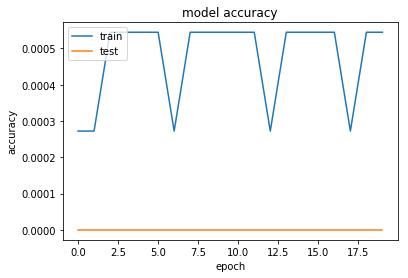

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       270   8          348734.09375  309834.589306


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6150 samples, validate on 30 samples
Epoch 1/20
6150/6150 [==============================] - 0s 72us/step - loss: 0.2540 - acc: 4.8780e-04 - val_loss: 0.0206 - val_acc: 0.0000e+00
Epoch 2/20
6150/6150 [==============================] - 0s 42us/step - loss: 0.0578 - acc: 4.8780e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
6150/6150 [==============================] - 0s 38us/step - l

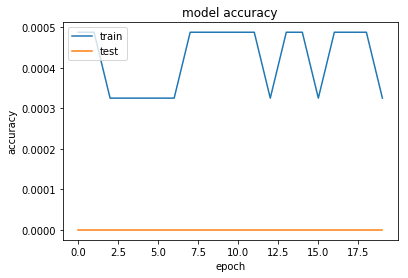

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       271   4           348498.9375  279059.663898


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6150 samples, validate on 30 samples
Epoch 1/20
6150/6150 [==============================] - 0s 70us/step - loss: 0.4351 - acc: 4.8780e-04 - val_loss: 0.1369 - val_acc: 0.0000e+00
Epoch 2/20
6150/6150 [==============================] - 0s 42us/step - loss: 0.0397 - acc: 4.8780e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 3/20
6150/6150 [==============================] - 0s 38us/step - l

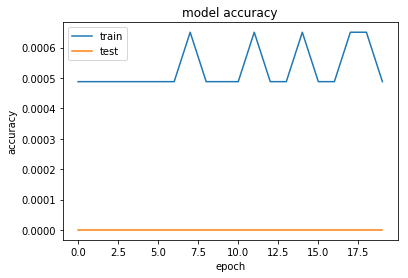

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       271   5         241745.703125  223096.094056


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2460 samples, validate on 12 samples
Epoch 1/20
2460/2460 [==============================] - 0s 144us/step - loss: 0.2744 - acc: 0.0000e+00 - val_loss: 0.0762 - val_acc: 0.0000e+00
Epoch 2/20
2460/2460 [==============================] - 0s 46us/step - loss: 0.1202 - acc: 8.1301e-04 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 3/20
2460/2460 [==============================] - 0s 45us/step - 

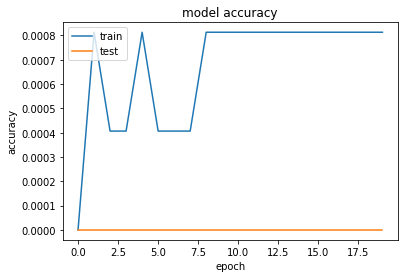

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       271   7         146989.296875  131711.425139


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3690 samples, validate on 18 samples
Epoch 1/20
3690/3690 [==============================] - 0s 102us/step - loss: 0.3540 - acc: 2.7100e-04 - val_loss: 0.0438 - val_acc: 0.0000e+00
Epoch 2/20
3690/3690 [==============================] - 0s 43us/step - loss: 0.0877 - acc: 2.7100e-04 - val_loss: 0.0102 - val_acc: 0.0000e+00
Epoch 3/20
3690/3690 [==============================] - 0s 39us/step - 

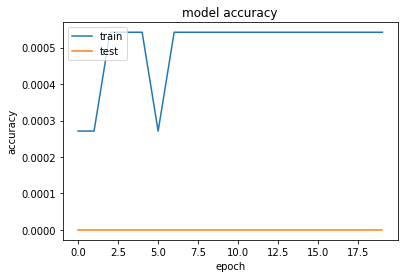

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       271   8          317664.28125  327869.973091


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6180 samples, validate on 30 samples
Epoch 1/20
6180/6180 [==============================] - 0s 78us/step - loss: 0.0850 - acc: 3.2362e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 2/20
6180/6180 [==============================] - 0s 45us/step - loss: 0.0254 - acc: 3.2362e-04 - val_loss: 2.0234e-04 - val_acc: 0.0000e+00
Epoch 3/20
6180/6180 [==============================] - 0s 41us/step

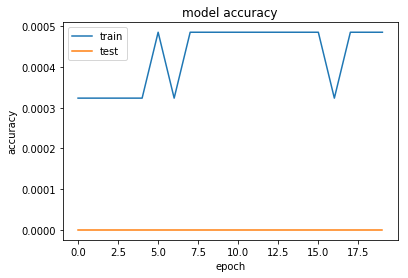

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       272   4          397825.03125  325965.100472


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6180 samples, validate on 30 samples
Epoch 1/20
6180/6180 [==============================] - 0s 78us/step - loss: 0.1233 - acc: 4.8544e-04 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 2/20
6180/6180 [==============================] - 0s 42us/step - loss: 0.0216 - acc: 4.8544e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 3/20
6180/6180 [==============================] - 0s 40us/step - l

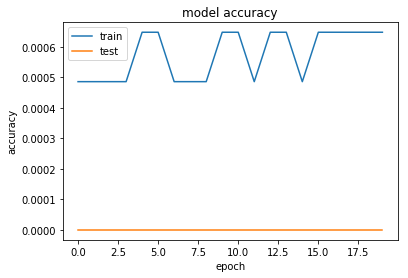

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       272   5           251649.3125  224715.884231


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2472 samples, validate on 12 samples
Epoch 1/20
2472/2472 [==============================] - 0s 123us/step - loss: 0.1810 - acc: 4.0453e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 2/20
2472/2472 [==============================] - 0s 46us/step - loss: 0.1070 - acc: 8.0906e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
2472/2472 [==============================] - 0s 44us/step - 

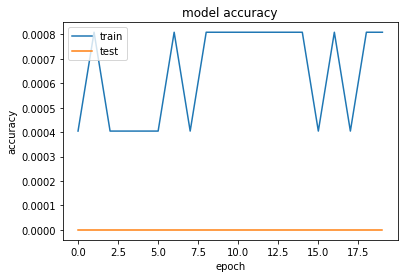

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       272   7         166311.578125  155033.612805


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3708 samples, validate on 18 samples
Epoch 1/20
3708/3708 [==============================] - 0s 94us/step - loss: 0.1107 - acc: 5.3937e-04 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 2/20
3708/3708 [==============================] - 0s 44us/step - loss: 0.0566 - acc: 2.6969e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/20
3708/3708 [==============================] - 0s 38us/step - l

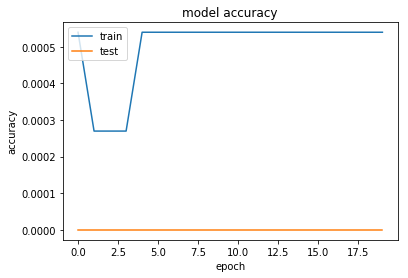

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       272   8          383939.21875  376927.011605


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6210 samples, validate on 30 samples
Epoch 1/20
6210/6210 [==============================] - 0s 76us/step - loss: 0.0606 - acc: 3.2206e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 2/20
6210/6210 [==============================] - 0s 41us/step - loss: 0.0166 - acc: 3.2206e-04 - val_loss: 8.3826e-04 - val_acc: 0.0000e+00
Epoch 3/20
6210/6210 [==============================] - 0s 38us/step

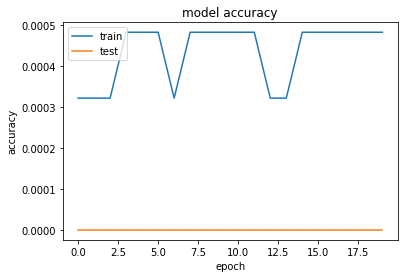

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       273   4              458810.0  436941.402153


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6210 samples, validate on 30 samples
Epoch 1/20
6210/6210 [==============================] - 0s 77us/step - loss: 0.9164 - acc: 3.2206e-04 - val_loss: 0.1920 - val_acc: 0.0000e+00
Epoch 2/20
6210/6210 [==============================] - 0s 41us/step - loss: 0.0630 - acc: 4.8309e-04 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 3/20
6210/6210 [==============================] - 0s 38us/step - l

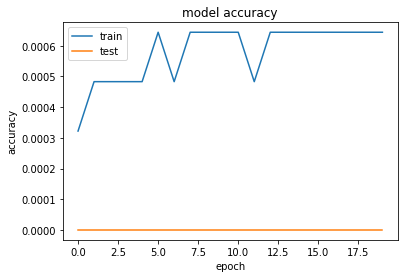

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       273   5          264228.84375  271556.376686


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2484 samples, validate on 12 samples
Epoch 1/20
2484/2484 [==============================] - 0s 125us/step - loss: 0.2295 - acc: 4.0258e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 2/20
2484/2484 [==============================] - 0s 44us/step - loss: 0.0893 - acc: 4.0258e-04 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 3/20
2484/2484 [==============================] - 0s 41us/step - 

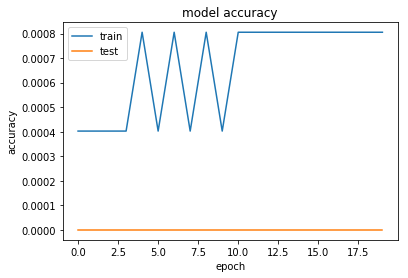

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       273   7             190965.75  203898.356216


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3726 samples, validate on 18 samples
Epoch 1/20
3726/3726 [==============================] - 0s 100us/step - loss: 0.2738 - acc: 0.0000e+00 - val_loss: 0.0804 - val_acc: 0.0000e+00
Epoch 2/20
3726/3726 [==============================] - 0s 42us/step - loss: 0.0498 - acc: 2.6838e-04 - val_loss: 0.0290 - val_acc: 0.0000e+00
Epoch 3/20
3726/3726 [==============================] - 0s 38us/step - 

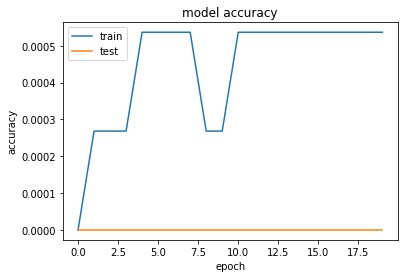

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       273   8          409125.21875  523196.053171


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6240 samples, validate on 30 samples
Epoch 1/20
6240/6240 [==============================] - 0s 75us/step - loss: 0.1018 - acc: 1.6026e-04 - val_loss: 9.7963e-04 - val_acc: 0.0000e+00
Epoch 2/20
6240/6240 [==============================] - 0s 40us/step - loss: 0.0281 - acc: 3.2051e-04 - val_loss: 7.0158e-04 - val_acc: 0.0000e+00
Epoch 3/20
6240/6240 [==============================] - 0s 37us/

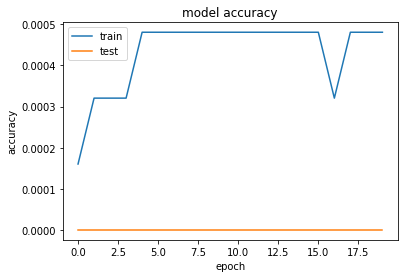

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       274   4          459601.65625  387243.481075


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6240 samples, validate on 30 samples
Epoch 1/20
6240/6240 [==============================] - 0s 70us/step - loss: 0.0849 - acc: 4.8077e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 2/20
6240/6240 [==============================] - 0s 41us/step - loss: 0.0207 - acc: 4.8077e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/20
6240/6240 [==============================] - 0s 37us/step - l

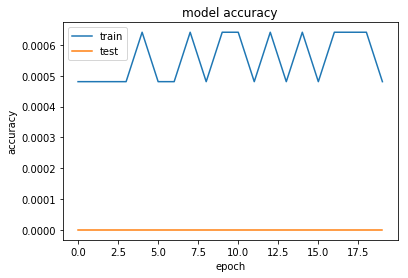

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       274   5         248251.234375  262571.112305


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2496 samples, validate on 12 samples
Epoch 1/20
2496/2496 [==============================] - 0s 130us/step - loss: 0.1592 - acc: 8.0128e-04 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 2/20
2496/2496 [==============================] - 0s 45us/step - loss: 0.0934 - acc: 8.0128e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/20
2496/2496 [==============================] - 0s 43us/step - 

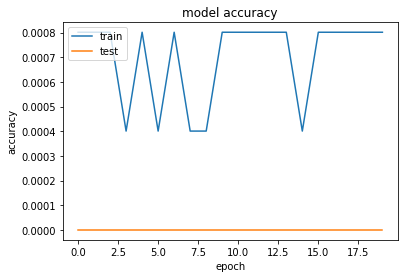

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       274   7         223173.296875  185443.659571


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3744 samples, validate on 18 samples
Epoch 1/20
3744/3744 [==============================] - 0s 98us/step - loss: 0.0723 - acc: 2.6709e-04 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 2/20
3744/3744 [==============================] - 0s 44us/step - loss: 0.0365 - acc: 2.6709e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 3/20
3744/3744 [==============================] - 0s 40us/step - l

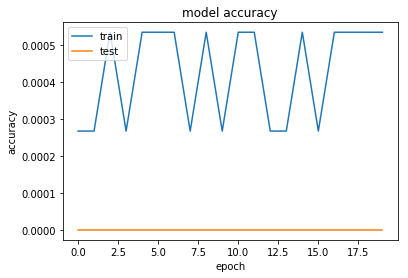

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       274   8           471153.9375  455737.408706


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6270 samples, validate on 30 samples
Epoch 1/20
6270/6270 [==============================] - 0s 75us/step - loss: 1.0520 - acc: 3.1898e-04 - val_loss: 0.1608 - val_acc: 0.0000e+00
Epoch 2/20
6270/6270 [==============================] - 0s 45us/step - loss: 0.0678 - acc: 3.1898e-04 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 3/20
6270/6270 [==============================] - 0s 41us/step - l

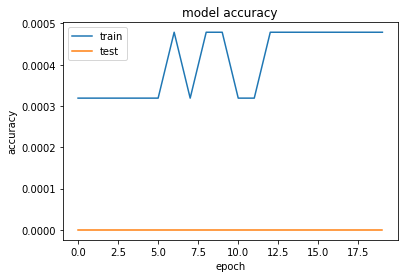

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       275   4              589835.5  436907.90216


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6270 samples, validate on 30 samples
Epoch 1/20
6270/6270 [==============================] - 0s 79us/step - loss: 0.0887 - acc: 4.7847e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 2/20
6270/6270 [==============================] - 0s 43us/step - loss: 0.0246 - acc: 4.7847e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 3/20
6270/6270 [==============================] - 0s 37us/step - l

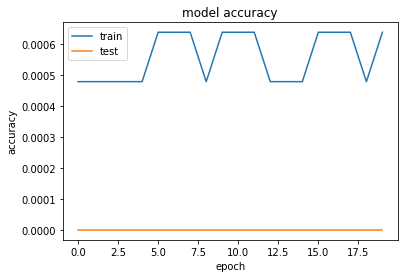

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       275   5          289857.21875  281927.882323


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2508 samples, validate on 12 samples
Epoch 1/20
2508/2508 [==============================] - 0s 125us/step - loss: 0.1185 - acc: 3.9872e-04 - val_loss: 0.0137 - val_acc: 0.0000e+00
Epoch 2/20
2508/2508 [==============================] - 0s 41us/step - loss: 0.0613 - acc: 3.9872e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 3/20
2508/2508 [==============================] - 0s 41us/step - 

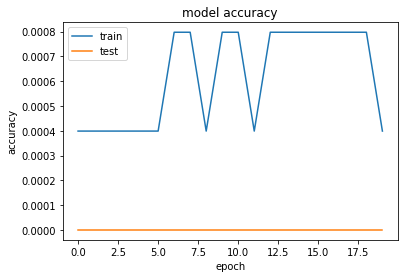

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       275   7         228009.296875  183162.91506


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3762 samples, validate on 18 samples
Epoch 1/20
3762/3762 [==============================] - 0s 101us/step - loss: 0.1518 - acc: 5.3163e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 2/20
3762/3762 [==============================] - 0s 43us/step - loss: 0.0728 - acc: 5.3163e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 3/20
3762/3762 [==============================] - 0s 39us/step - 

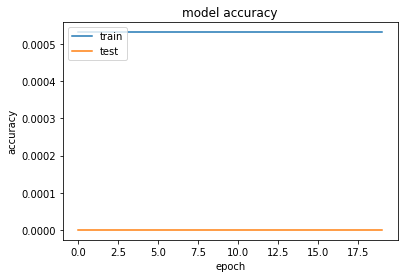

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       275   8           562443.6875  477262.025744


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6300 samples, validate on 30 samples
Epoch 1/20
6300/6300 [==============================] - 0s 76us/step - loss: 0.1042 - acc: 4.7619e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/20
6300/6300 [==============================] - 0s 42us/step - loss: 0.0313 - acc: 3.1746e-04 - val_loss: 8.3035e-04 - val_acc: 0.0000e+00
Epoch 3/20
6300/6300 [==============================] - 0s 38us/step

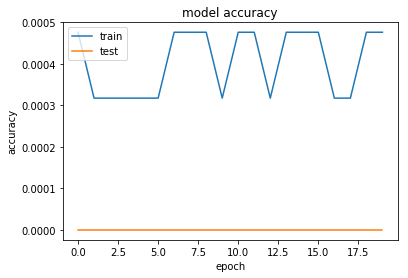

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       276   4            623760.375  451324.449054


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6300 samples, validate on 30 samples
Epoch 1/20
6300/6300 [==============================] - 0s 69us/step - loss: 0.2012 - acc: 4.7619e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 2/20
6300/6300 [==============================] - 0s 43us/step - loss: 0.0347 - acc: 4.7619e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 3/20
6300/6300 [==============================] - 0s 37us/step - l

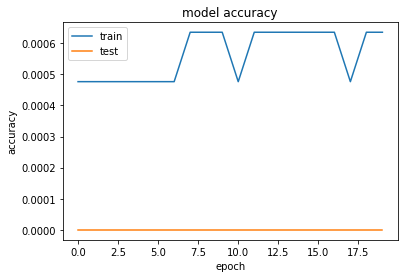

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       276   5          329379.78125  270691.441811


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2520 samples, validate on 12 samples
Epoch 1/20
2520/2520 [==============================] - 0s 127us/step - loss: 0.1517 - acc: 3.9683e-04 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 2/20
2520/2520 [==============================] - 0s 51us/step - loss: 0.0945 - acc: 3.9683e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 3/20
2520/2520 [==============================] - 0s 42us/step - 

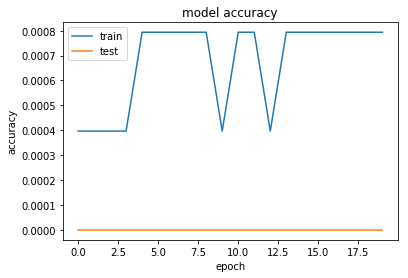

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       276   7         234427.453125  200586.393677


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3780 samples, validate on 18 samples
Epoch 1/20
3780/3780 [==============================] - 0s 101us/step - loss: 0.1187 - acc: 2.6455e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 2/20
3780/3780 [==============================] - 0s 42us/step - loss: 0.0551 - acc: 2.6455e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
3780/3780 [==============================] - 0s 39us/step - 

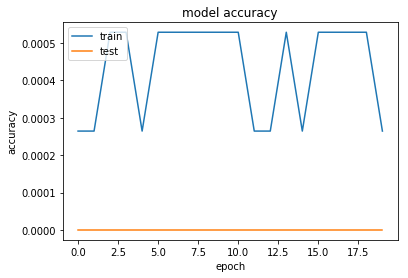

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       276   8           649074.3125  481875.326907


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6330 samples, validate on 30 samples
Epoch 1/20
6330/6330 [==============================] - 0s 76us/step - loss: 0.0851 - acc: 3.1596e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 2/20
6330/6330 [==============================] - 0s 41us/step - loss: 0.0248 - acc: 3.1596e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 3/20
6330/6330 [==============================] - 0s 42us/step - l

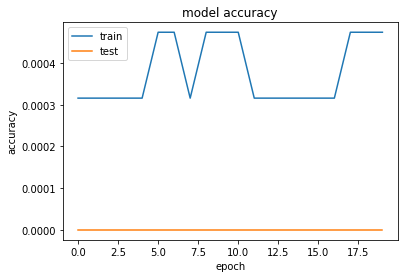

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       277   4              646551.0  622216.48948


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6330 samples, validate on 30 samples
Epoch 1/20
6330/6330 [==============================] - 0s 72us/step - loss: 0.1110 - acc: 4.7393e-04 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 2/20
6330/6330 [==============================] - 0s 40us/step - loss: 0.0291 - acc: 4.7393e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 3/20
6330/6330 [==============================] - 0s 37us/step - l

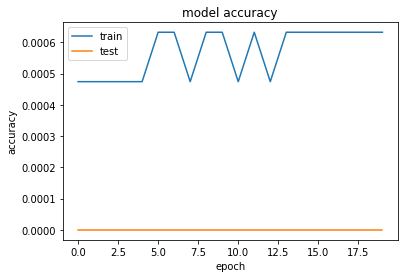

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       277   5           377386.3125  329091.692914


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2532 samples, validate on 12 samples
Epoch 1/20
2532/2532 [==============================] - 0s 131us/step - loss: 0.2088 - acc: 3.9494e-04 - val_loss: 0.0145 - val_acc: 0.0000e+00
Epoch 2/20
2532/2532 [==============================] - 0s 44us/step - loss: 0.1257 - acc: 7.8989e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 3/20
2532/2532 [==============================] - 0s 40us/step - 

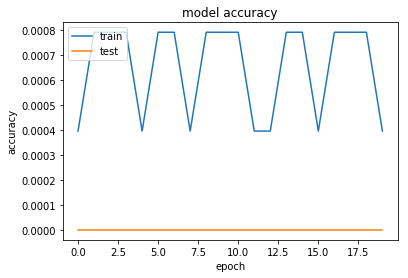

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       277   7          263173.46875  284740.341922


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3798 samples, validate on 18 samples
Epoch 1/20
3798/3798 [==============================] - 0s 99us/step - loss: 0.1722 - acc: 5.2659e-04 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 2/20
3798/3798 [==============================] - 0s 44us/step - loss: 0.0846 - acc: 5.2659e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 3/20
3798/3798 [==============================] - 0s 39us/step - l

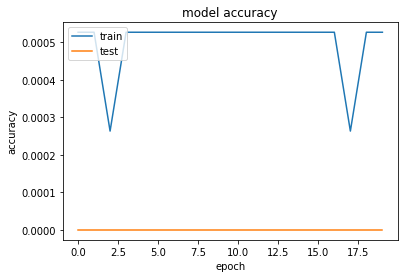

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       277   8              683501.5  636282.798047


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6360 samples, validate on 30 samples
Epoch 1/20
6360/6360 [==============================] - 0s 71us/step - loss: 0.0855 - acc: 3.1447e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 2/20
6360/6360 [==============================] - 0s 42us/step - loss: 0.0236 - acc: 3.1447e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 3/20
6360/6360 [==============================] - 0s 36us/step - l

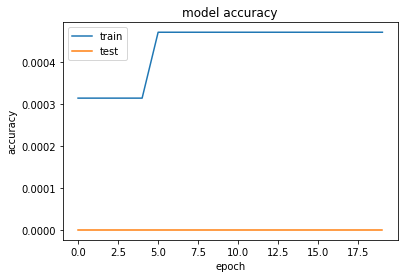

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       278   4            720085.875  707656.075355


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6360 samples, validate on 30 samples
Epoch 1/20
6360/6360 [==============================] - 0s 74us/step - loss: 0.0719 - acc: 4.7170e-04 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 2/20
6360/6360 [==============================] - 0s 41us/step - loss: 0.0191 - acc: 4.7170e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 3/20
6360/6360 [==============================] - 0s 37us/step - l

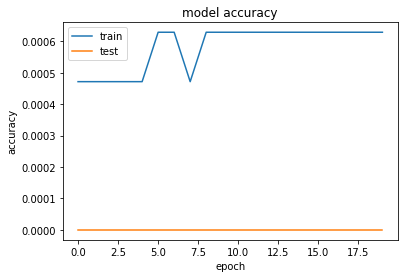

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       278   5          351002.59375  372109.458255


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2544 samples, validate on 12 samples
Epoch 1/20
2544/2544 [==============================] - 0s 130us/step - loss: 0.2182 - acc: 3.9308e-04 - val_loss: 0.1184 - val_acc: 0.0000e+00
Epoch 2/20
2544/2544 [==============================] - 0s 47us/step - loss: 0.1027 - acc: 3.9308e-04 - val_loss: 0.0605 - val_acc: 0.0000e+00
Epoch 3/20
2544/2544 [==============================] - 0s 40us/step - 

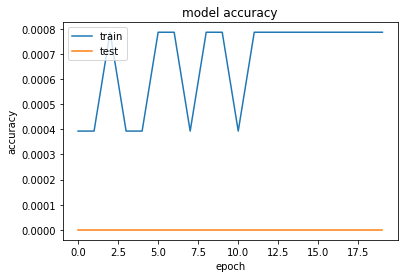

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       278   7           279908.3125  359850.602457


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3816 samples, validate on 18 samples
Epoch 1/20
3816/3816 [==============================] - 0s 92us/step - loss: 0.1868 - acc: 2.6205e-04 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 2/20
3816/3816 [==============================] - 0s 48us/step - loss: 0.0697 - acc: 5.2411e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 3/20
3816/3816 [==============================] - 0s 40us/step - l

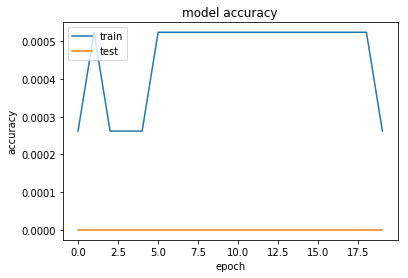

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       278   8           632474.5625  701825.229913


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6390 samples, validate on 30 samples
Epoch 1/20
6390/6390 [==============================] - 0s 76us/step - loss: 0.1032 - acc: 3.1299e-04 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 2/20
6390/6390 [==============================] - 0s 43us/step - loss: 0.0272 - acc: 3.1299e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 3/20
6390/6390 [==============================] - 0s 37us/step - l

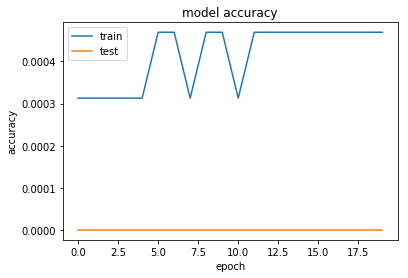

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       279   4            661164.625  850222.924488


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6390 samples, validate on 30 samples
Epoch 1/20
6390/6390 [==============================] - 1s 79us/step - loss: 0.0352 - acc: 4.6948e-04 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 2/20
6390/6390 [==============================] - 0s 45us/step - loss: 0.0109 - acc: 4.6948e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 3/20
6390/6390 [==============================] - 0s 41us/step - l

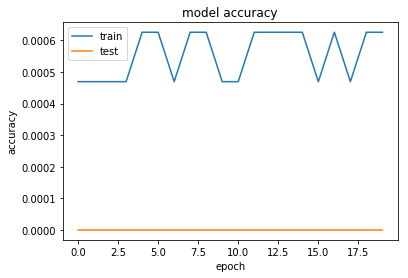

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       279   5          357372.78125  408827.14213


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2556 samples, validate on 12 samples
Epoch 1/20
2556/2556 [==============================] - 0s 121us/step - loss: 0.0792 - acc: 3.9124e-04 - val_loss: 0.0989 - val_acc: 0.0000e+00
Epoch 2/20
2556/2556 [==============================] - 0s 48us/step - loss: 0.0525 - acc: 3.9124e-04 - val_loss: 0.0752 - val_acc: 0.0000e+00
Epoch 3/20
2556/2556 [==============================] - 0s 41us/step - 

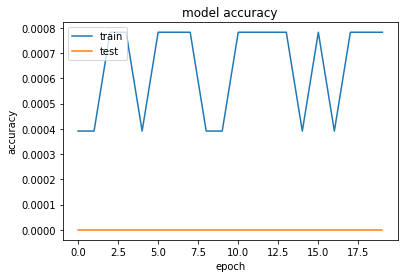

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       279   7          307256.09375  380856.965497


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3834 samples, validate on 18 samples
Epoch 1/20
3834/3834 [==============================] - 0s 106us/step - loss: 0.4734 - acc: 0.0000e+00 - val_loss: 0.1119 - val_acc: 0.0000e+00
Epoch 2/20
3834/3834 [==============================] - 0s 45us/step - loss: 0.0961 - acc: 2.6082e-04 - val_loss: 0.0935 - val_acc: 0.0000e+00
Epoch 3/20
3834/3834 [==============================] - 0s 40us/step - 

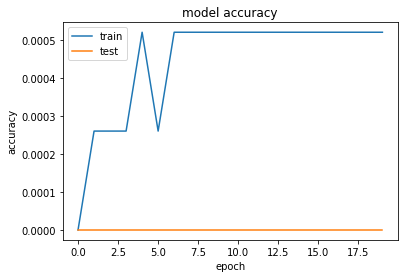

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       279   8              667452.5  785193.878093


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6420 samples, validate on 30 samples
Epoch 1/20
6420/6420 [==============================] - 0s 71us/step - loss: 0.0580 - acc: 3.1153e-04 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 2/20
6420/6420 [==============================] - 0s 42us/step - loss: 0.0148 - acc: 3.1153e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 3/20
6420/6420 [==============================] - 0s 38us/step - l

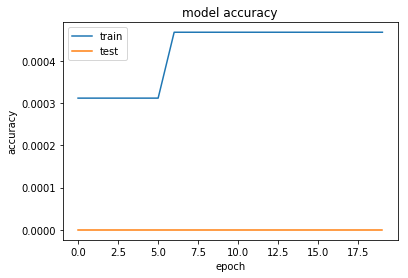

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       280   4              748556.0  965643.135134


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6420 samples, validate on 30 samples
Epoch 1/20
6420/6420 [==============================] - 0s 75us/step - loss: 0.0542 - acc: 4.6729e-04 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 2/20
6420/6420 [==============================] - 0s 43us/step - loss: 0.0144 - acc: 4.6729e-04 - val_loss: 0.0111 - val_acc: 0.0000e+00
Epoch 3/20
6420/6420 [==============================] - 0s 40us/step - l

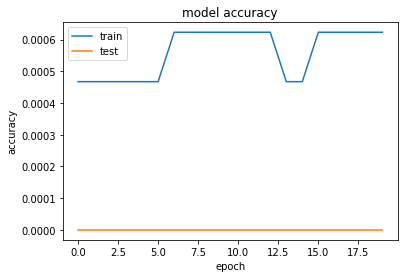

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       280   5           378185.1875  460718.925336


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2568 samples, validate on 12 samples
Epoch 1/20
2568/2568 [==============================] - 0s 124us/step - loss: 0.5879 - acc: 3.8941e-04 - val_loss: 0.4555 - val_acc: 0.0000e+00
Epoch 2/20
2568/2568 [==============================] - 0s 46us/step - loss: 0.1749 - acc: 3.8941e-04 - val_loss: 0.0845 - val_acc: 0.0000e+00
Epoch 3/20
2568/2568 [==============================] - 0s 40us/step - 

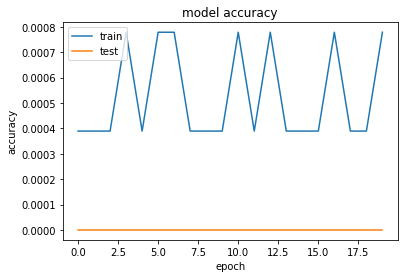

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       280   7            322914.625  417660.815299


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3852 samples, validate on 18 samples
Epoch 1/20
3852/3852 [==============================] - 0s 94us/step - loss: 0.1044 - acc: 2.5961e-04 - val_loss: 0.0681 - val_acc: 0.0000e+00
Epoch 2/20
3852/3852 [==============================] - 0s 41us/step - loss: 0.0443 - acc: 2.5961e-04 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 3/20
3852/3852 [==============================] - 0s 38us/step - l

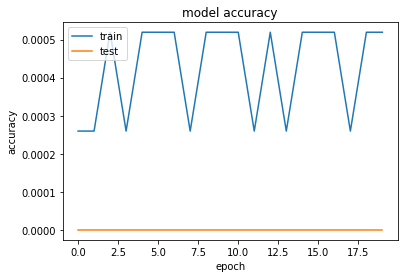

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       280   8           697896.8125  888502.355793


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6450 samples, validate on 30 samples
Epoch 1/20
6450/6450 [==============================] - 0s 74us/step - loss: 0.0578 - acc: 3.1008e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 2/20
6450/6450 [==============================] - 0s 42us/step - loss: 0.0152 - acc: 3.1008e-04 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 3/20
6450/6450 [==============================] - 0s 42us/step - l

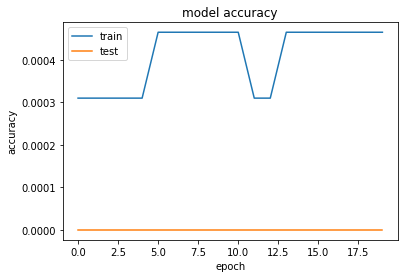

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       281   4           796367.0625  974101.711253


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6450 samples, validate on 30 samples
Epoch 1/20
6450/6450 [==============================] - 1s 78us/step - loss: 0.3328 - acc: 1.5504e-04 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 2/20
6450/6450 [==============================] - 0s 40us/step - loss: 0.0442 - acc: 4.6512e-04 - val_loss: 0.0164 - val_acc: 0.0000e+00
Epoch 3/20
6450/6450 [==============================] - 0s 36us/step - l

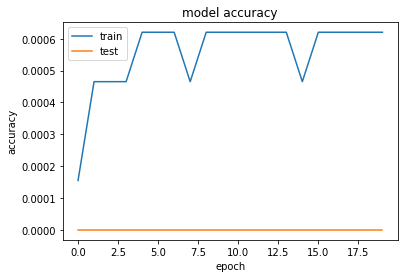

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       281   5            425420.375  473962.081127


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2580 samples, validate on 12 samples
Epoch 1/20
2580/2580 [==============================] - 0s 128us/step - loss: 0.1195 - acc: 3.8760e-04 - val_loss: 0.1174 - val_acc: 0.0000e+00
Epoch 2/20
2580/2580 [==============================] - 0s 45us/step - loss: 0.0661 - acc: 3.8760e-04 - val_loss: 0.0709 - val_acc: 0.0000e+00
Epoch 3/20
2580/2580 [==============================] - 0s 39us/step - 

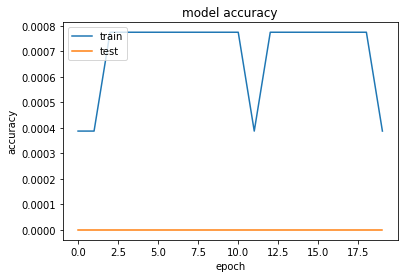

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       281   7           326830.4375  408997.39497


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3870 samples, validate on 18 samples
Epoch 1/20
3870/3870 [==============================] - 0s 98us/step - loss: 0.1924 - acc: 5.1680e-04 - val_loss: 0.0866 - val_acc: 0.0000e+00
Epoch 2/20
3870/3870 [==============================] - 0s 48us/step - loss: 0.0624 - acc: 2.5840e-04 - val_loss: 0.0528 - val_acc: 0.0000e+00
Epoch 3/20
3870/3870 [==============================] - 0s 40us/step - l

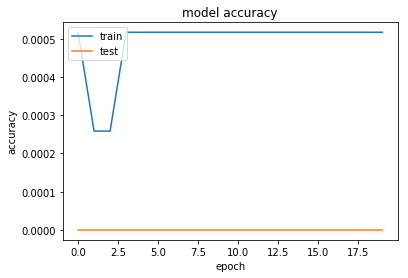

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       281   8             773103.25  911188.576692


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6480 samples, validate on 30 samples
Epoch 1/20
6480/6480 [==============================] - 1s 78us/step - loss: 0.3098 - acc: 3.0864e-04 - val_loss: 0.0730 - val_acc: 0.0000e+00
Epoch 2/20
6480/6480 [==============================] - 0s 42us/step - loss: 0.0228 - acc: 3.0864e-04 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 3/20
6480/6480 [==============================] - 0s 40us/step - l

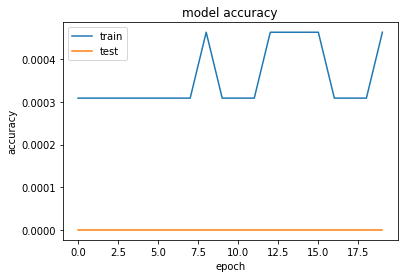

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       282   4             832156.75  916409.057869


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6480 samples, validate on 30 samples
Epoch 1/20
6480/6480 [==============================] - 0s 71us/step - loss: 0.1393 - acc: 4.6296e-04 - val_loss: 0.0123 - val_acc: 0.0000e+00
Epoch 2/20
6480/6480 [==============================] - 0s 42us/step - loss: 0.0370 - acc: 4.6296e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 3/20
6480/6480 [==============================] - 0s 37us/step - l

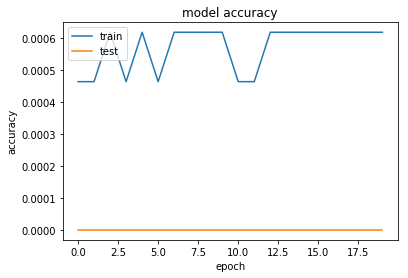

   testWeek  DC  Nplus1CUBEPrediction   Nplus1CUBE
0       282   5          408697.96875  461435.6416


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2592 samples, validate on 12 samples
Epoch 1/20
2592/2592 [==============================] - 0s 121us/step - loss: 0.1301 - acc: 3.8580e-04 - val_loss: 0.0679 - val_acc: 0.0000e+00
Epoch 2/20
2592/2592 [==============================] - 0s 48us/step - loss: 0.0769 - acc: 7.7160e-04 - val_loss: 0.0372 - val_acc: 0.0000e+00
Epoch 3/20
2592/2592 [==============================] - 0s 44us/step - 

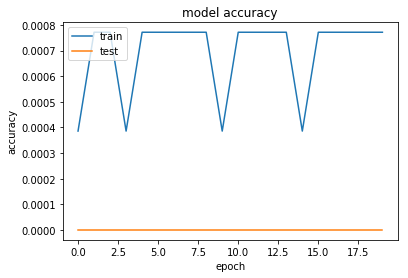

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       282   7          330200.53125  363149.006767


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3888 samples, validate on 18 samples
Epoch 1/20
3888/3888 [==============================] - 0s 104us/step - loss: 0.1014 - acc: 2.5720e-04 - val_loss: 0.0359 - val_acc: 0.0000e+00
Epoch 2/20
3888/3888 [==============================] - 0s 44us/step - loss: 0.0459 - acc: 2.5720e-04 - val_loss: 0.0204 - val_acc: 0.0000e+00
Epoch 3/20
3888/3888 [==============================] - 0s 43us/step - 

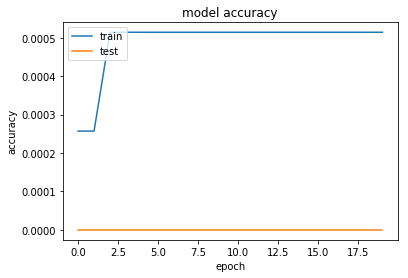

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       282   8             725468.75  713701.498502


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6510 samples, validate on 30 samples
Epoch 1/20
6510/6510 [==============================] - 1s 77us/step - loss: 0.0598 - acc: 3.0722e-04 - val_loss: 0.0129 - val_acc: 0.0000e+00
Epoch 2/20
6510/6510 [==============================] - 0s 42us/step - loss: 0.0165 - acc: 3.0722e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 3/20
6510/6510 [==============================] - 0s 37us/step - l

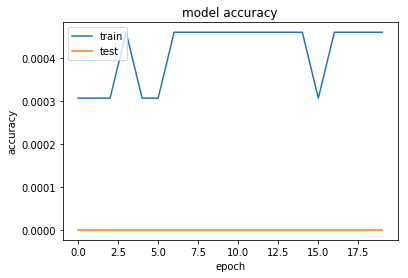

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       283   4           822270.6875  845764.88058


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6510 samples, validate on 30 samples
Epoch 1/20
6510/6510 [==============================] - 0s 74us/step - loss: 0.1575 - acc: 3.0722e-04 - val_loss: 0.0472 - val_acc: 0.0000e+00
Epoch 2/20
6510/6510 [==============================] - 0s 41us/step - loss: 0.0393 - acc: 4.6083e-04 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 3/20
6510/6510 [==============================] - 0s 37us/step - l

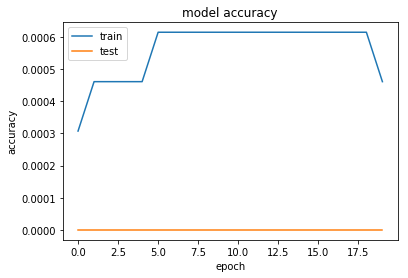

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       283   5          439476.90625  453603.536128


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2604 samples, validate on 12 samples
Epoch 1/20
2604/2604 [==============================] - 0s 126us/step - loss: 0.0976 - acc: 3.8402e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 2/20
2604/2604 [==============================] - 0s 45us/step - loss: 0.0556 - acc: 7.6805e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 3/20
2604/2604 [==============================] - 0s 40us/step - 

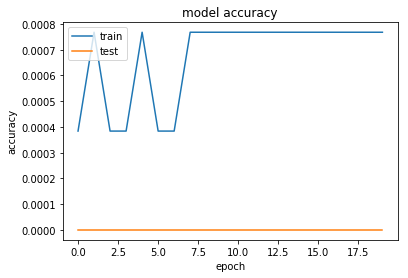

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       283   7            310339.375  266395.134126


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3906 samples, validate on 18 samples
Epoch 1/20
3906/3906 [==============================] - 0s 98us/step - loss: 0.0658 - acc: 2.5602e-04 - val_loss: 0.0320 - val_acc: 0.0000e+00
Epoch 2/20
3906/3906 [==============================] - 0s 46us/step - loss: 0.0311 - acc: 2.5602e-04 - val_loss: 0.0204 - val_acc: 0.0000e+00
Epoch 3/20
3906/3906 [==============================] - 0s 44us/step - l

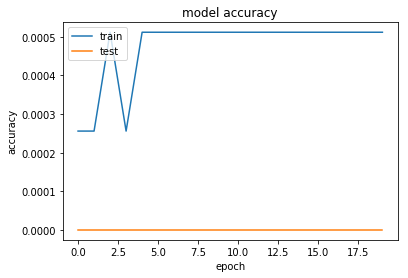

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       283   8           712530.1875  711175.011906


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6540 samples, validate on 30 samples
Epoch 1/20
6540/6540 [==============================] - 1s 77us/step - loss: 0.0967 - acc: 3.0581e-04 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 2/20
6540/6540 [==============================] - 0s 39us/step - loss: 0.0268 - acc: 3.0581e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 3/20
6540/6540 [==============================] - 0s 41us/step - l

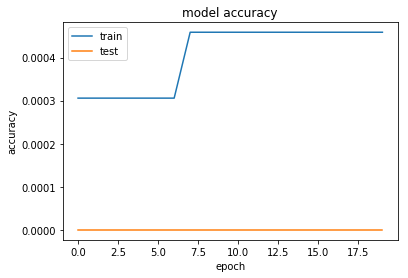

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       284   4           715137.0625  790355.736839


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6540 samples, validate on 30 samples
Epoch 1/20
6540/6540 [==============================] - 0s 74us/step - loss: 0.0976 - acc: 6.1162e-04 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 2/20
6540/6540 [==============================] - 0s 40us/step - loss: 0.0271 - acc: 4.5872e-04 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 3/20
6540/6540 [==============================] - 0s 38us/step - l

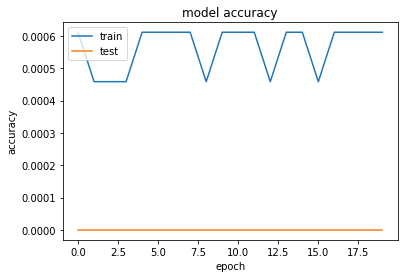

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       284   5           388007.9375  407284.391739


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2616 samples, validate on 12 samples
Epoch 1/20
2616/2616 [==============================] - 0s 126us/step - loss: 0.3129 - acc: 7.6453e-04 - val_loss: 0.0695 - val_acc: 0.0000e+00
Epoch 2/20
2616/2616 [==============================] - 0s 47us/step - loss: 0.1201 - acc: 3.8226e-04 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 3/20
2616/2616 [==============================] - 0s 37us/step - 

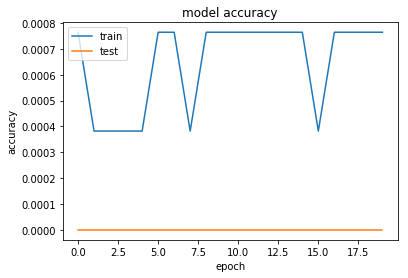

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       284   7            303617.125  305048.629812


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3924 samples, validate on 18 samples
Epoch 1/20
3924/3924 [==============================] - 0s 94us/step - loss: 0.1315 - acc: 2.5484e-04 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 2/20
3924/3924 [==============================] - 0s 43us/step - loss: 0.0314 - acc: 2.5484e-04 - val_loss: 0.0289 - val_acc: 0.0000e+00
Epoch 3/20
3924/3924 [==============================] - 0s 38us/step - l

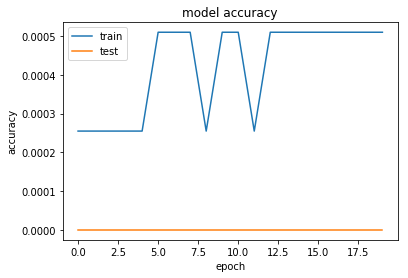

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       284   8            663453.625  721591.215699


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6570 samples, validate on 30 samples
Epoch 1/20
6570/6570 [==============================] - 0s 72us/step - loss: 0.1127 - acc: 3.0441e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/20
6570/6570 [==============================] - 0s 41us/step - loss: 0.0261 - acc: 3.0441e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 3/20
6570/6570 [==============================] - 0s 39us/step - l

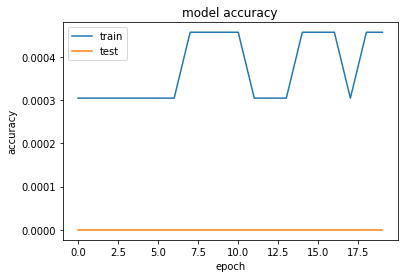

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       285   4            706951.375  711532.018466


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6570 samples, validate on 30 samples
Epoch 1/20
6570/6570 [==============================] - 0s 73us/step - loss: 0.0732 - acc: 4.5662e-04 - val_loss: 0.0100 - val_acc: 0.0000e+00
Epoch 2/20
6570/6570 [==============================] - 0s 41us/step - loss: 0.0188 - acc: 6.0883e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 3/20
6570/6570 [==============================] - 0s 37us/step - l

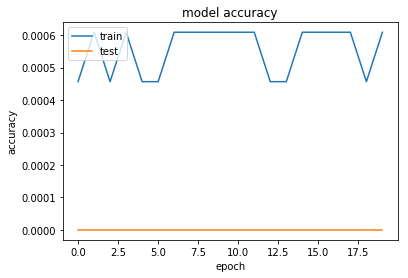

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       285   5          374417.34375  393592.287872


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2628 samples, validate on 12 samples
Epoch 1/20
2628/2628 [==============================] - 0s 130us/step - loss: 0.1602 - acc: 3.8052e-04 - val_loss: 0.0593 - val_acc: 0.0000e+00
Epoch 2/20
2628/2628 [==============================] - 0s 53us/step - loss: 0.0895 - acc: 3.8052e-04 - val_loss: 0.0418 - val_acc: 0.0000e+00
Epoch 3/20
2628/2628 [==============================] - 0s 45us/step - 

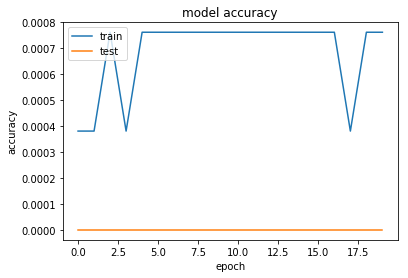

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       285   7            251562.625  293047.585142


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3942 samples, validate on 18 samples
Epoch 1/20
3942/3942 [==============================] - 0s 96us/step - loss: 0.0877 - acc: 2.5368e-04 - val_loss: 0.0124 - val_acc: 0.0000e+00
Epoch 2/20
3942/3942 [==============================] - 0s 42us/step - loss: 0.0412 - acc: 5.0736e-04 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 3/20
3942/3942 [==============================] - 0s 40us/step - l

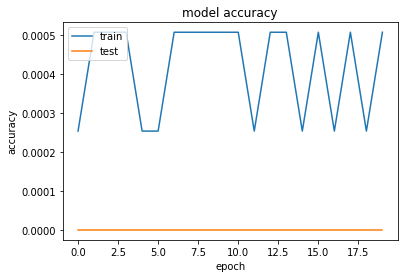

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       285   8             614271.75  729684.565672


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6600 samples, validate on 30 samples
Epoch 1/20
6600/6600 [==============================] - 0s 75us/step - loss: 0.0826 - acc: 3.0303e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 2/20
6600/6600 [==============================] - 0s 40us/step - loss: 0.0234 - acc: 3.0303e-04 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 3/20
6600/6600 [==============================] - 0s 37us/step - l

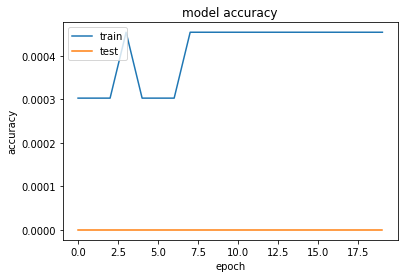

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       286   4             691781.25  698657.460392


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6600 samples, validate on 30 samples
Epoch 1/20
6600/6600 [==============================] - 0s 71us/step - loss: 0.0813 - acc: 3.0303e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 2/20
6600/6600 [==============================] - 0s 41us/step - loss: 0.0221 - acc: 4.5455e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 3/20
6600/6600 [==============================] - 0s 37us/step - l

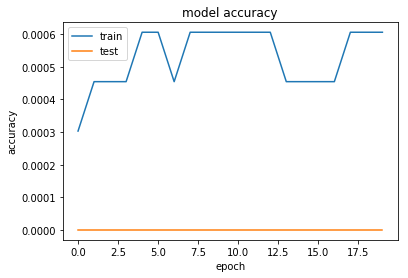

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       286   5          355369.53125  393634.462332


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2640 samples, validate on 12 samples
Epoch 1/20
2640/2640 [==============================] - 0s 117us/step - loss: 0.1050 - acc: 3.7879e-04 - val_loss: 0.0444 - val_acc: 0.0000e+00
Epoch 2/20
2640/2640 [==============================] - 0s 49us/step - loss: 0.0636 - acc: 3.7879e-04 - val_loss: 0.0305 - val_acc: 0.0000e+00
Epoch 3/20
2640/2640 [==============================] - 0s 42us/step - 

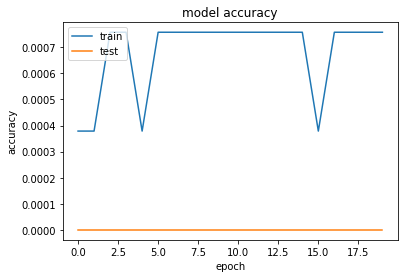

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       286   7           239915.8125  304681.836115


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3960 samples, validate on 18 samples
Epoch 1/20
3960/3960 [==============================] - 0s 97us/step - loss: 0.1597 - acc: 2.5253e-04 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 2/20
3960/3960 [==============================] - 0s 43us/step - loss: 0.0730 - acc: 5.0505e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 3/20
3960/3960 [==============================] - 0s 37us/step - l

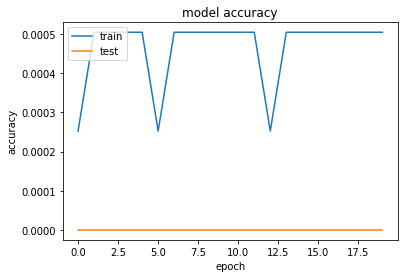

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       286   8            582560.375  683141.250312


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6630 samples, validate on 30 samples
Epoch 1/20
6630/6630 [==============================] - 0s 69us/step - loss: 0.0759 - acc: 3.0166e-04 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 2/20
6630/6630 [==============================] - 0s 42us/step - loss: 0.0197 - acc: 3.0166e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 3/20
6630/6630 [==============================] - 0s 39us/step - l

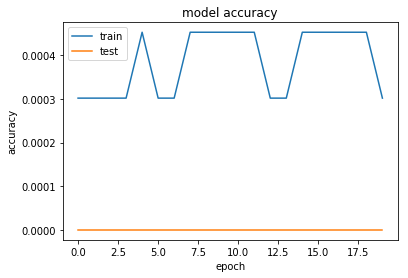

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       287   4           612223.4375  685357.717838


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6630 samples, validate on 30 samples
Epoch 1/20
6630/6630 [==============================] - 0s 70us/step - loss: 0.1847 - acc: 3.0166e-04 - val_loss: 0.0359 - val_acc: 0.0000e+00
Epoch 2/20
6630/6630 [==============================] - 0s 41us/step - loss: 0.0333 - acc: 4.5249e-04 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 3/20
6630/6630 [==============================] - 0s 39us/step - l

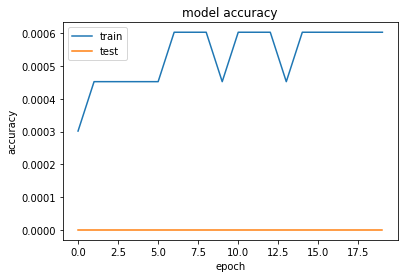

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       287   5            391959.125  419394.112919


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2652 samples, validate on 12 samples
Epoch 1/20
2652/2652 [==============================] - 0s 128us/step - loss: 0.2120 - acc: 7.5415e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 2/20
2652/2652 [==============================] - 0s 48us/step - loss: 0.1148 - acc: 3.7707e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 3/20
2652/2652 [==============================] - 0s 38us/step - 

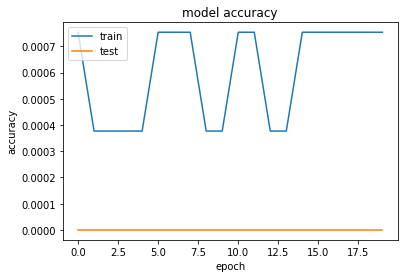

   testWeek  DC  Nplus1CUBEPrediction   Nplus1CUBE
0       287   7          239453.09375  222485.2437


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3978 samples, validate on 18 samples
Epoch 1/20
3978/3978 [==============================] - 0s 96us/step - loss: 0.1069 - acc: 5.0277e-04 - val_loss: 0.0297 - val_acc: 0.0000e+00
Epoch 2/20
3978/3978 [==============================] - 0s 43us/step - loss: 0.0480 - acc: 5.0277e-04 - val_loss: 0.0129 - val_acc: 0.0000e+00
Epoch 3/20
3978/3978 [==============================] - 0s 38us/step - l

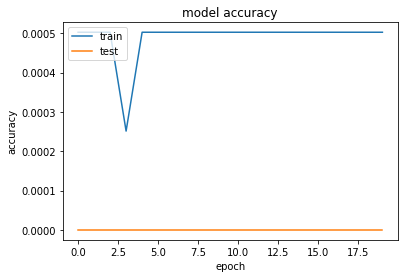

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       287   8            575256.375  591875.110229


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6660 samples, validate on 30 samples
Epoch 1/20
6660/6660 [==============================] - 0s 72us/step - loss: 0.1985 - acc: 3.0030e-04 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 2/20
6660/6660 [==============================] - 0s 40us/step - loss: 0.0363 - acc: 3.0030e-04 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 3/20
6660/6660 [==============================] - 0s 37us/step - l

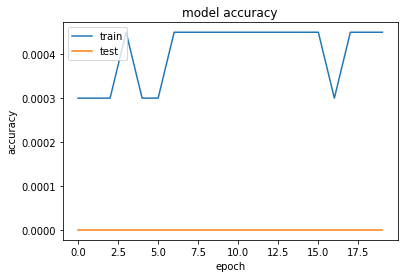

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       288   4           547751.6875  633634.863047


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6660 samples, validate on 30 samples
Epoch 1/20
6660/6660 [==============================] - 0s 74us/step - loss: 0.0493 - acc: 4.5045e-04 - val_loss: 0.0116 - val_acc: 0.0000e+00
Epoch 2/20
6660/6660 [==============================] - 0s 42us/step - loss: 0.0134 - acc: 4.5045e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00
Epoch 3/20
6660/6660 [==============================] - 0s 40us/step - l

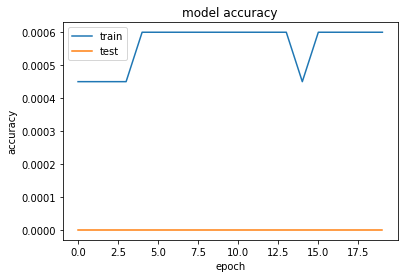

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       288   5              325469.5  398964.913862


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2664 samples, validate on 12 samples
Epoch 1/20
2664/2664 [==============================] - 0s 119us/step - loss: 0.4151 - acc: 3.7538e-04 - val_loss: 0.0926 - val_acc: 0.0000e+00
Epoch 2/20
2664/2664 [==============================] - 0s 49us/step - loss: 0.1123 - acc: 3.7538e-04 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 3/20
2664/2664 [==============================] - 0s 39us/step - 

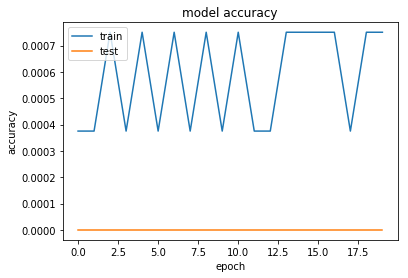

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       288   7          241326.71875  221075.662436


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3996 samples, validate on 18 samples
Epoch 1/20
3996/3996 [==============================] - 0s 97us/step - loss: 0.0882 - acc: 2.5025e-04 - val_loss: 0.0114 - val_acc: 0.0000e+00
Epoch 2/20
3996/3996 [==============================] - 0s 44us/step - loss: 0.0389 - acc: 2.5025e-04 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 3/20
3996/3996 [==============================] - 0s 41us/step - l

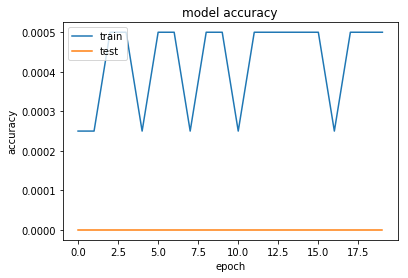

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       288   8           574273.5625  550790.775609


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6690 samples, validate on 30 samples
Epoch 1/20
6690/6690 [==============================] - 0s 69us/step - loss: 0.2126 - acc: 2.9895e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 2/20
6690/6690 [==============================] - 0s 42us/step - loss: 0.0176 - acc: 2.9895e-04 - val_loss: 9.8060e-04 - val_acc: 0.0000e+00
Epoch 3/20
6690/6690 [==============================] - 0s 40us/step

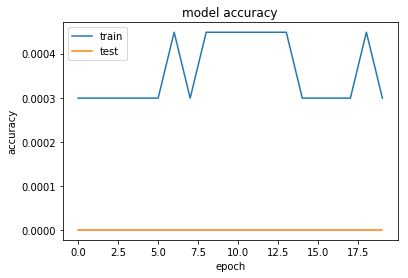

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       289   4             519785.75  523072.146106


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6690 samples, validate on 30 samples
Epoch 1/20
6690/6690 [==============================] - 0s 72us/step - loss: 0.0528 - acc: 4.4843e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 2/20
6690/6690 [==============================] - 0s 40us/step - loss: 0.0135 - acc: 4.4843e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 3/20
6690/6690 [==============================] - 0s 37us/step - l

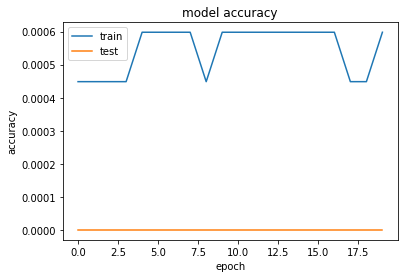

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       289   5          367351.21875  335857.803441


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2676 samples, validate on 12 samples
Epoch 1/20
2676/2676 [==============================] - 0s 126us/step - loss: 0.2042 - acc: 3.7369e-04 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 2/20
2676/2676 [==============================] - 0s 45us/step - loss: 0.1117 - acc: 7.4738e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 3/20
2676/2676 [==============================] - 0s 40us/step - 

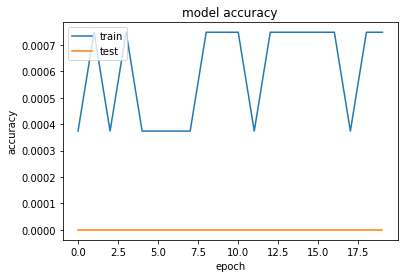

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       289   7         213660.796875  188019.825449


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4014 samples, validate on 18 samples
Epoch 1/20
4014/4014 [==============================] - 0s 91us/step - loss: 0.3702 - acc: 4.9826e-04 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 2/20
4014/4014 [==============================] - 0s 42us/step - loss: 0.1426 - acc: 2.4913e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 3/20
4014/4014 [==============================] - 0s 38us/step - l

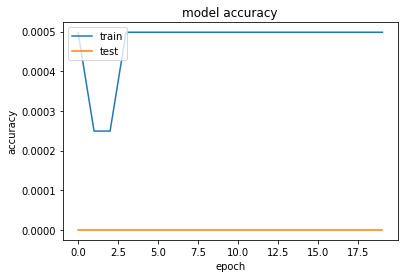

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       289   8           547842.9375  462602.547586


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6720 samples, validate on 30 samples
Epoch 1/20
6720/6720 [==============================] - 1s 77us/step - loss: 0.0838 - acc: 2.9762e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 2/20
6720/6720 [==============================] - 0s 44us/step - loss: 0.0217 - acc: 2.9762e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 3/20
6720/6720 [==============================] - 0s 39us/step - l

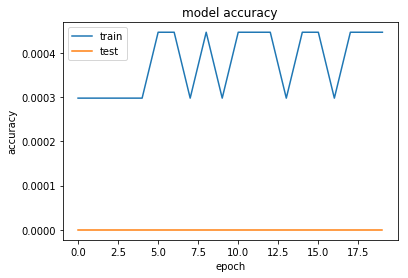

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       290   4              457681.5  460133.286536


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6720 samples, validate on 30 samples
Epoch 1/20
6720/6720 [==============================] - 0s 70us/step - loss: 0.1233 - acc: 4.4643e-04 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 2/20
6720/6720 [==============================] - 0s 40us/step - loss: 0.0260 - acc: 5.9524e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
6720/6720 [==============================] - 0s 42us/step - l

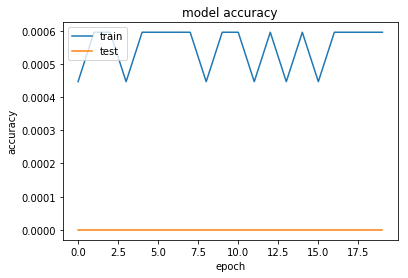

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       290   5          314870.53125  310954.99832


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2688 samples, validate on 12 samples
Epoch 1/20
2688/2688 [==============================] - 0s 122us/step - loss: 0.2019 - acc: 3.7202e-04 - val_loss: 0.0179 - val_acc: 0.0000e+00
Epoch 2/20
2688/2688 [==============================] - 0s 38us/step - loss: 0.0975 - acc: 3.7202e-04 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 3/20
2688/2688 [==============================] - 0s 38us/step - 

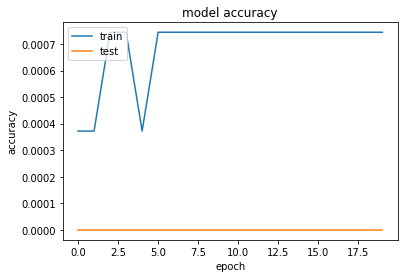

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       290   7         183697.015625  167800.898193


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4032 samples, validate on 18 samples
Epoch 1/20
4032/4032 [==============================] - 0s 96us/step - loss: 0.1403 - acc: 2.4802e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 2/20
4032/4032 [==============================] - 0s 41us/step - loss: 0.0670 - acc: 2.4802e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 3/20
4032/4032 [==============================] - 0s 39us/step - l

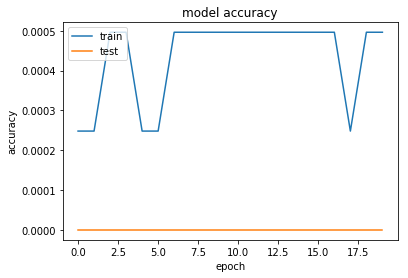

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       290   8           501123.3125  450844.464128


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6750 samples, validate on 30 samples
Epoch 1/20
6750/6750 [==============================] - 1s 75us/step - loss: 0.1978 - acc: 1.4815e-04 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 2/20
6750/6750 [==============================] - 0s 41us/step - loss: 0.0403 - acc: 2.9630e-04 - val_loss: 7.5277e-04 - val_acc: 0.0000e+00
Epoch 3/20
6750/6750 [==============================] - 0s 39us/step

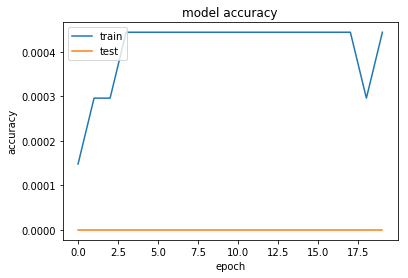

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       291   4           515308.5625  463851.367629


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6750 samples, validate on 30 samples
Epoch 1/20
6750/6750 [==============================] - 0s 74us/step - loss: 0.0824 - acc: 4.4444e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 2/20
6750/6750 [==============================] - 0s 40us/step - loss: 0.0220 - acc: 4.4444e-04 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 3/20
6750/6750 [==============================] - 0s 37us/step - l

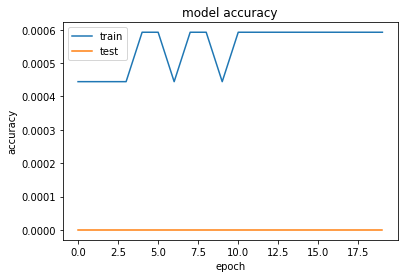

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       291   5          318222.90625  327053.814916


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2700 samples, validate on 12 samples
Epoch 1/20
2700/2700 [==============================] - 0s 125us/step - loss: 0.4928 - acc: 3.7037e-04 - val_loss: 0.1874 - val_acc: 0.0000e+00
Epoch 2/20
2700/2700 [==============================] - 0s 44us/step - loss: 0.1324 - acc: 3.7037e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 3/20
2700/2700 [==============================] - 0s 41us/step - 

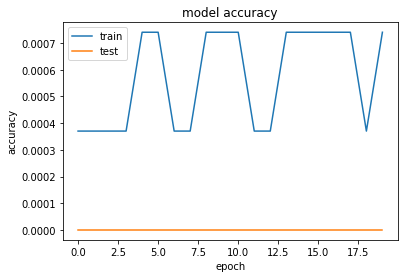

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       291   7         180350.421875  165283.630631


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4050 samples, validate on 18 samples
Epoch 1/20
4050/4050 [==============================] - 0s 95us/step - loss: 0.1655 - acc: 2.4691e-04 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 2/20
4050/4050 [==============================] - 0s 48us/step - loss: 0.0533 - acc: 2.4691e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 3/20
4050/4050 [==============================] - 0s 38us/step - l

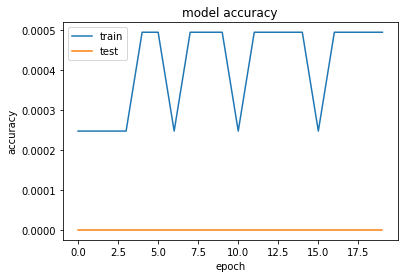

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       291   8           460878.6875  450414.002268


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6780 samples, validate on 30 samples
Epoch 1/20
6780/6780 [==============================] - 0s 71us/step - loss: 0.0853 - acc: 2.9499e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 2/20
6780/6780 [==============================] - 0s 39us/step - loss: 0.0208 - acc: 2.9499e-04 - val_loss: 6.9537e-04 - val_acc: 0.0000e+00
Epoch 3/20
6780/6780 [==============================] - 0s 36us/step

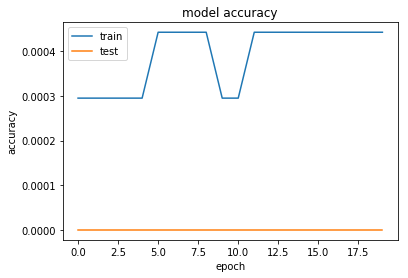

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       292   4           453921.4375  442250.804656


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6780 samples, validate on 30 samples
Epoch 1/20
6780/6780 [==============================] - 1s 78us/step - loss: 0.0740 - acc: 4.4248e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 2/20
6780/6780 [==============================] - 0s 42us/step - loss: 0.0185 - acc: 4.4248e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/20
6780/6780 [==============================] - 0s 37us/step - l

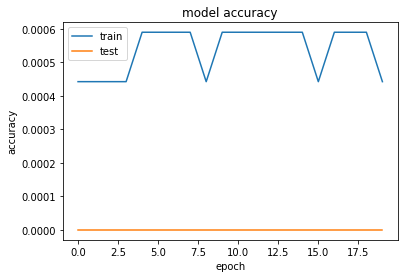

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       292   5           312738.4375  304359.007068


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2712 samples, validate on 12 samples
Epoch 1/20
2712/2712 [==============================] - 0s 124us/step - loss: 0.1609 - acc: 3.6873e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 2/20
2712/2712 [==============================] - 0s 47us/step - loss: 0.0882 - acc: 7.3746e-04 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 3/20
2712/2712 [==============================] - 0s 44us/step - 

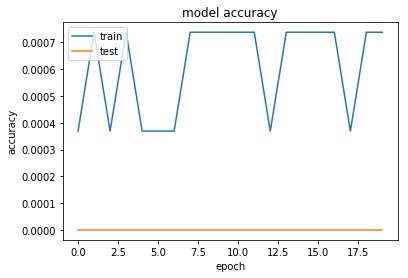

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       292   7         174143.546875  170749.74096


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4068 samples, validate on 18 samples
Epoch 1/20
4068/4068 [==============================] - 0s 99us/step - loss: 1.2837 - acc: 2.4582e-04 - val_loss: 0.3170 - val_acc: 0.0000e+00
Epoch 2/20
4068/4068 [==============================] - 0s 47us/step - loss: 0.2281 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 3/20
4068/4068 [==============================] - 0s 37us/step - l

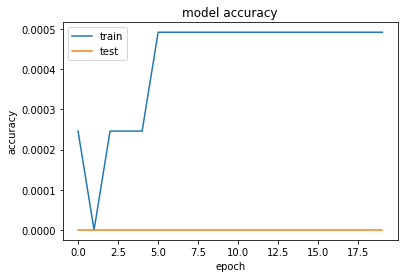

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       292   8            424112.375  422456.397361


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6810 samples, validate on 30 samples
Epoch 1/20
6810/6810 [==============================] - 1s 74us/step - loss: 0.0809 - acc: 1.4684e-04 - val_loss: 9.6454e-04 - val_acc: 0.0000e+00
Epoch 2/20
6810/6810 [==============================] - 0s 42us/step - loss: 0.0199 - acc: 2.9369e-04 - val_loss: 6.8412e-04 - val_acc: 0.0000e+00
Epoch 3/20
6810/6810 [==============================] - 0s 40us/

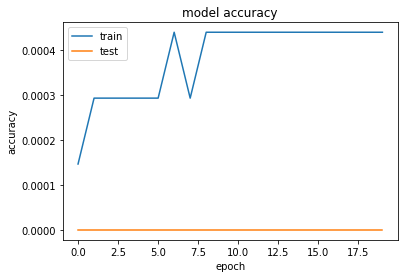

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       293   4           427150.4375  430553.96013


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6810 samples, validate on 30 samples
Epoch 1/20
6810/6810 [==============================] - 1s 74us/step - loss: 0.1162 - acc: 4.4053e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/20
6810/6810 [==============================] - 0s 43us/step - loss: 0.0319 - acc: 4.4053e-04 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 3/20
6810/6810 [==============================] - 0s 38us/step - l

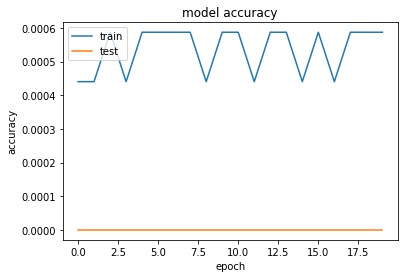

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       293   5          282066.09375  283078.906799


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2724 samples, validate on 12 samples
Epoch 1/20
2724/2724 [==============================] - 0s 115us/step - loss: 0.1798 - acc: 7.3421e-04 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 2/20
2724/2724 [==============================] - 0s 45us/step - loss: 0.1040 - acc: 3.6711e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 3/20
2724/2724 [==============================] - 0s 36us/step - 

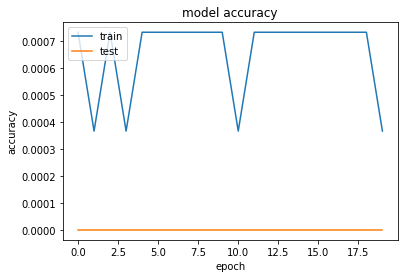

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       293   7         170472.984375  164041.549519


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4086 samples, validate on 18 samples
Epoch 1/20
4086/4086 [==============================] - 0s 87us/step - loss: 0.1066 - acc: 0.0000e+00 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 2/20
4086/4086 [==============================] - 0s 45us/step - loss: 0.0453 - acc: 4.8948e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 3/20
4086/4086 [==============================] - 0s 38us/step - l

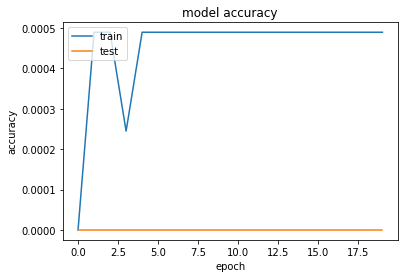

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       293   8          385058.71875  371756.577774


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6840 samples, validate on 30 samples
Epoch 1/20
6840/6840 [==============================] - 0s 71us/step - loss: 0.0778 - acc: 2.9240e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 2/20
6840/6840 [==============================] - 0s 41us/step - loss: 0.0195 - acc: 2.9240e-04 - val_loss: 8.4836e-04 - val_acc: 0.0000e+00
Epoch 3/20
6840/6840 [==============================] - 0s 39us/step

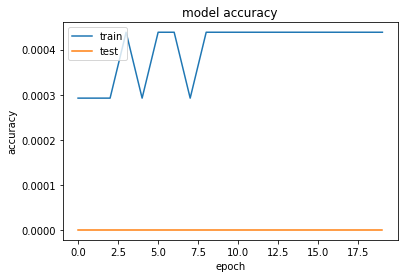

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       294   4          367624.59375  438750.968362


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6840 samples, validate on 30 samples
Epoch 1/20
6840/6840 [==============================] - 0s 73us/step - loss: 0.2008 - acc: 2.9240e-04 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 2/20
6840/6840 [==============================] - 0s 40us/step - loss: 0.0382 - acc: 4.3860e-04 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 3/20
6840/6840 [==============================] - 0s 37us/step - l

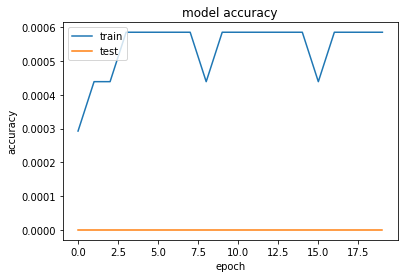

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       294   5           273499.4375  303604.788614


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2736 samples, validate on 12 samples
Epoch 1/20
2736/2736 [==============================] - 0s 121us/step - loss: 0.2088 - acc: 3.6550e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 2/20
2736/2736 [==============================] - 0s 47us/step - loss: 0.1095 - acc: 3.6550e-04 - val_loss: 0.0130 - val_acc: 0.0000e+00
Epoch 3/20
2736/2736 [==============================] - 0s 41us/step - 

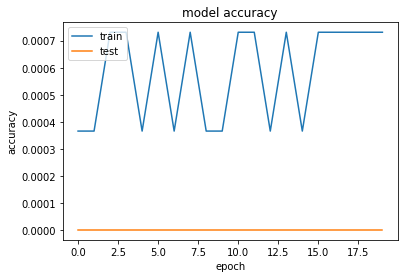

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       294   7            166274.375  181488.343008


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4104 samples, validate on 18 samples
Epoch 1/20
4104/4104 [==============================] - 0s 97us/step - loss: 0.1681 - acc: 2.4366e-04 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 2/20
4104/4104 [==============================] - 0s 47us/step - loss: 0.0739 - acc: 4.8733e-04 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 3/20
4104/4104 [==============================] - 0s 37us/step - l

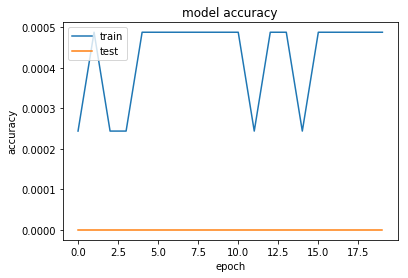

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       294   8          424055.03125  430683.178994


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6870 samples, validate on 30 samples
Epoch 1/20
6870/6870 [==============================] - 1s 78us/step - loss: 0.0822 - acc: 1.4556e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 2/20
6870/6870 [==============================] - 0s 41us/step - loss: 0.0192 - acc: 2.9112e-04 - val_loss: 8.9491e-04 - val_acc: 0.0000e+00
Epoch 3/20
6870/6870 [==============================] - 0s 37us/step

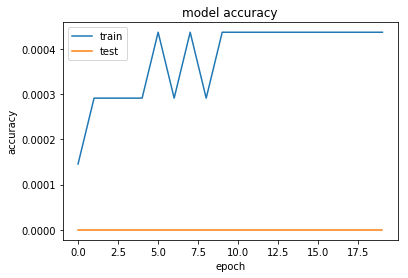

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       295   4          384640.21875  410863.350884


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6870 samples, validate on 30 samples
Epoch 1/20
6870/6870 [==============================] - 0s 68us/step - loss: 0.1069 - acc: 4.3668e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 2/20
6870/6870 [==============================] - 0s 43us/step - loss: 0.0264 - acc: 4.3668e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 3/20
6870/6870 [==============================] - 0s 38us/step - l

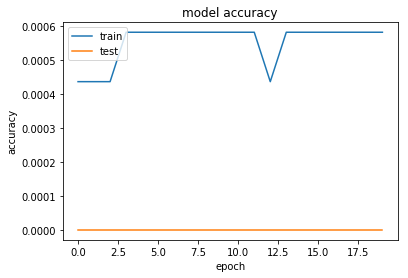

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       295   5          274330.59375  330211.793789


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2748 samples, validate on 12 samples
Epoch 1/20
2748/2748 [==============================] - 0s 116us/step - loss: 0.1013 - acc: 3.6390e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 2/20
2748/2748 [==============================] - 0s 46us/step - loss: 0.0616 - acc: 7.2780e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 3/20
2748/2748 [==============================] - 0s 42us/step - 

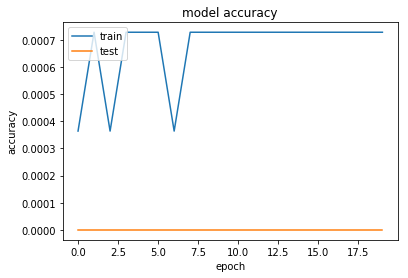

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       295   7         157987.078125  172046.043682


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4122 samples, validate on 18 samples
Epoch 1/20
4122/4122 [==============================] - 0s 99us/step - loss: 0.2473 - acc: 2.4260e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 2/20
4122/4122 [==============================] - 0s 46us/step - loss: 0.0724 - acc: 4.8520e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
4122/4122 [==============================] - 0s 40us/step - l

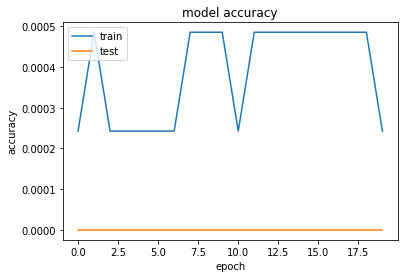

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       295   8           413804.0625  421500.672948


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6900 samples, validate on 30 samples
Epoch 1/20
6900/6900 [==============================] - 1s 79us/step - loss: 0.0354 - acc: 2.8986e-04 - val_loss: 7.3155e-04 - val_acc: 0.0000e+00
Epoch 2/20
6900/6900 [==============================] - 0s 39us/step - loss: 0.0090 - acc: 2.8986e-04 - val_loss: 8.6863e-04 - val_acc: 0.0000e+00
Epoch 3/20
6900/6900 [==============================] - 0s 39us/

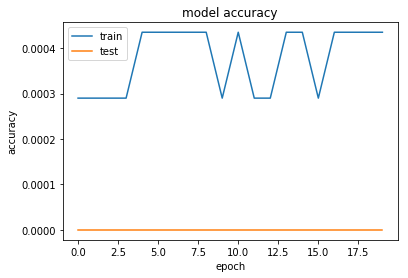

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       296   4          403678.84375  404338.006938


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6900 samples, validate on 30 samples
Epoch 1/20
6900/6900 [==============================] - 1s 73us/step - loss: 0.0581 - acc: 4.3478e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 2/20
6900/6900 [==============================] - 0s 40us/step - loss: 0.0144 - acc: 4.3478e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 3/20
6900/6900 [==============================] - 0s 37us/step - l

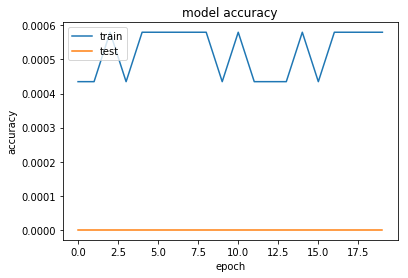

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       296   5          313581.21875  311496.681516


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2760 samples, validate on 12 samples
Epoch 1/20
2760/2760 [==============================] - 0s 120us/step - loss: 0.0748 - acc: 3.6232e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 2/20
2760/2760 [==============================] - 0s 45us/step - loss: 0.0447 - acc: 3.6232e-04 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 3/20
2760/2760 [==============================] - 0s 33us/step - 

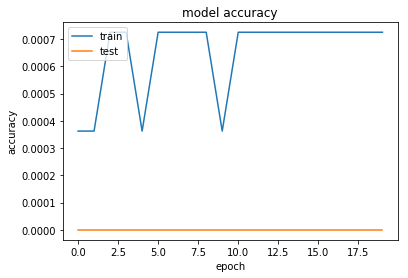

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       296   7         176732.765625  173991.767254


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4140 samples, validate on 18 samples
Epoch 1/20
4140/4140 [==============================] - 0s 95us/step - loss: 0.1646 - acc: 4.8309e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 2/20
4140/4140 [==============================] - 0s 42us/step - loss: 0.0606 - acc: 2.4155e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 3/20
4140/4140 [==============================] - 0s 38us/step - l

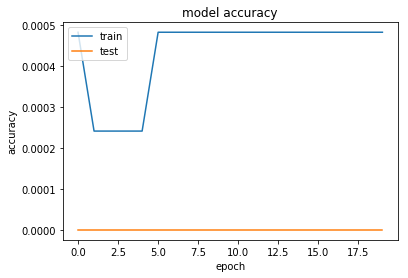

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       296   8           440756.4375  397296.372534


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6930 samples, validate on 30 samples
Epoch 1/20
6930/6930 [==============================] - 1s 76us/step - loss: 0.0660 - acc: 2.8860e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/20
6930/6930 [==============================] - 0s 44us/step - loss: 0.0158 - acc: 2.8860e-04 - val_loss: 8.3126e-04 - val_acc: 0.0000e+00
Epoch 3/20
6930/6930 [==============================] - 0s 43us/step

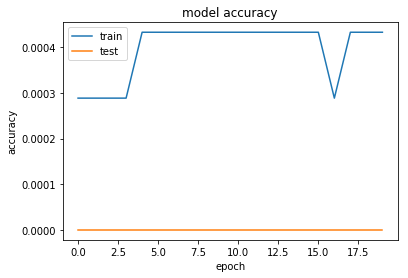

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       297   4          514374.90625  475861.502656


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6930 samples, validate on 30 samples
Epoch 1/20
6930/6930 [==============================] - 1s 77us/step - loss: 0.1158 - acc: 2.8860e-04 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 2/20
6930/6930 [==============================] - 0s 45us/step - loss: 0.0227 - acc: 5.7720e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 3/20
6930/6930 [==============================] - 0s 41us/step - l

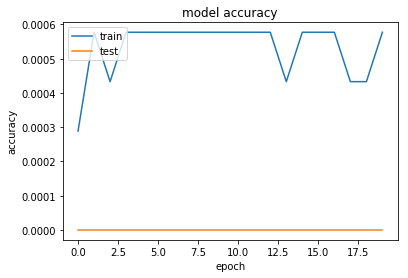

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       297   5          371836.21875  374153.306801


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2772 samples, validate on 12 samples
Epoch 1/20
2772/2772 [==============================] - 0s 116us/step - loss: 0.2034 - acc: 3.6075e-04 - val_loss: 0.0245 - val_acc: 0.0000e+00
Epoch 2/20
2772/2772 [==============================] - 0s 52us/step - loss: 0.0704 - acc: 3.6075e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/20
2772/2772 [==============================] - 0s 44us/step - 

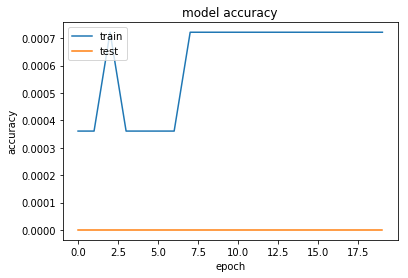

   testWeek  DC  Nplus1CUBEPrediction    Nplus1CUBE
0       297   7           204983.4375  203363.07021


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4158 samples, validate on 18 samples
Epoch 1/20
4158/4158 [==============================] - 0s 100us/step - loss: 0.4161 - acc: 2.4050e-04 - val_loss: 0.0616 - val_acc: 0.0000e+00
Epoch 2/20
4158/4158 [==============================] - 0s 43us/step - loss: 0.1460 - acc: 2.4050e-04 - val_loss: 0.0308 - val_acc: 0.0000e+00
Epoch 3/20
4158/4158 [==============================] - 0s 40us/step - 

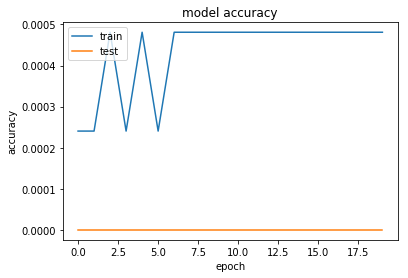

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       297   8           537800.1875  496745.691377


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6960 samples, validate on 30 samples
Epoch 1/20
6960/6960 [==============================] - 1s 74us/step - loss: 0.1275 - acc: 2.8736e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 2/20
6960/6960 [==============================] - 0s 45us/step - loss: 0.0321 - acc: 2.8736e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/20
6960/6960 [==============================] - 0s 39us/step - l

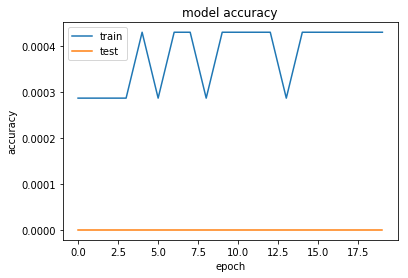

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       298   4          407362.03125  406509.914729


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6960 samples, validate on 30 samples
Epoch 1/20
6960/6960 [==============================] - 0s 70us/step - loss: 0.1231 - acc: 4.3103e-04 - val_loss: 0.0162 - val_acc: 0.0000e+00
Epoch 2/20
6960/6960 [==============================] - 0s 41us/step - loss: 0.0277 - acc: 4.3103e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
6960/6960 [==============================] - 0s 38us/step - l

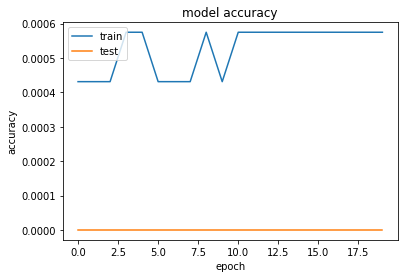

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       298   5          291868.53125  313512.640273


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2784 samples, validate on 12 samples
Epoch 1/20
2784/2784 [==============================] - 0s 111us/step - loss: 0.1727 - acc: 7.1839e-04 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 2/20
2784/2784 [==============================] - 0s 42us/step - loss: 0.1043 - acc: 3.5920e-04 - val_loss: 0.0107 - val_acc: 0.0000e+00
Epoch 3/20
2784/2784 [==============================] - 0s 36us/step - 

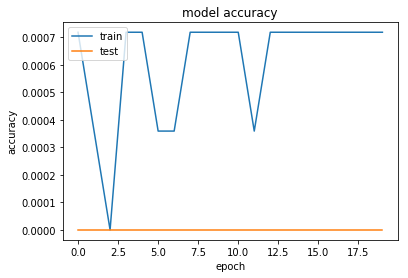

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       298   7          166563.09375  211907.880753


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4176 samples, validate on 18 samples
Epoch 1/20
4176/4176 [==============================] - 0s 89us/step - loss: 0.1038 - acc: 4.7893e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 2/20
4176/4176 [==============================] - 0s 43us/step - loss: 0.0437 - acc: 4.7893e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
4176/4176 [==============================] - 0s 39us/step - l

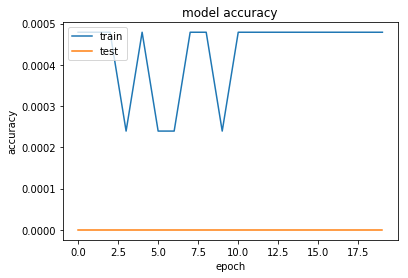

   testWeek  DC  Nplus1CUBEPrediction     Nplus1CUBE
0       298   8          420965.34375  400677.287639


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5430 samples, validate on 30 samples
Epoch 1/20
5430/5430 [==============================] - 0s 86us/step - loss: 0.2745 - acc: 1.8416e-04 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 2/20
5430/5430 [==============================] - 0s 45us/step - loss: 0.0434 - acc: 3.6832e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 3/20
5430/5430 [==============================] - 0s 38us/step - l

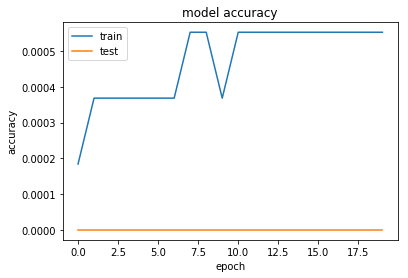

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       247   4          427624.96875  382216.414893


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5430 samples, validate on 30 samples
Epoch 1/20
5430/5430 [==============================] - 0s 81us/step - loss: 0.0887 - acc: 5.5249e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 2/20
5430/5430 [==============================] - 0s 43us/step - loss: 0.0292 - acc: 7.3665e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
5430/5430 [==============================] - 0s 38us/step - l

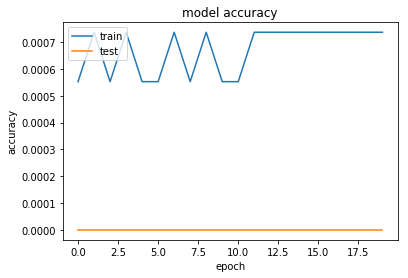

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       247   5          324364.40625  315313.392527


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2172 samples, validate on 12 samples
Epoch 1/20
2172/2172 [==============================] - 0s 138us/step - loss: 0.2065 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 2/20
2172/2172 [==============================] - 0s 42us/step - loss: 0.1232 - acc: 9.2081e-04 - val_loss: 0.0186 - val_acc: 0.0000e+00
Epoch 3/20
2172/2172 [==============================] - 0s 40us/step - 

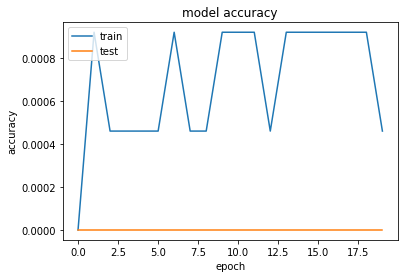

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       247   7          191720.96875  224483.515719


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3258 samples, validate on 18 samples
Epoch 1/20
3258/3258 [==============================] - 0s 112us/step - loss: 0.1213 - acc: 3.0694e-04 - val_loss: 0.0137 - val_acc: 0.0000e+00
Epoch 2/20
3258/3258 [==============================] - 0s 44us/step - loss: 0.0603 - acc: 6.1387e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 3/20
3258/3258 [==============================] - 0s 42us/step - 

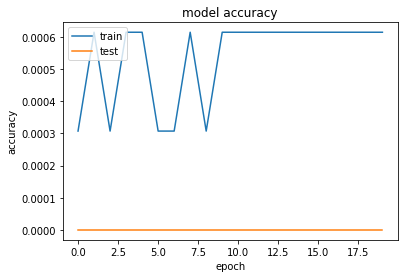

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       247   8           459781.3125  485248.742811


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5460 samples, validate on 30 samples
Epoch 1/20
5460/5460 [==============================] - 0s 79us/step - loss: 0.3198 - acc: 3.6630e-04 - val_loss: 0.0226 - val_acc: 0.0000e+00
Epoch 2/20
5460/5460 [==============================] - 0s 43us/step - loss: 0.0511 - acc: 5.4945e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
5460/5460 [==============================] - 0s 38us/step - l

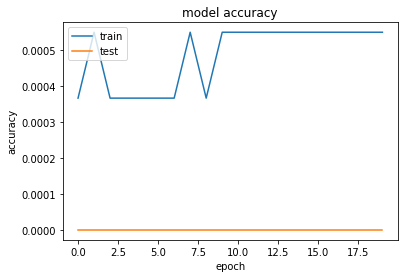

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       248   4          401067.34375  385696.502809


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5460 samples, validate on 30 samples
Epoch 1/20
5460/5460 [==============================] - 0s 84us/step - loss: 0.0916 - acc: 5.4945e-04 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 2/20
5460/5460 [==============================] - 0s 43us/step - loss: 0.0318 - acc: 7.3260e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/20
5460/5460 [==============================] - 0s 44us/step - l

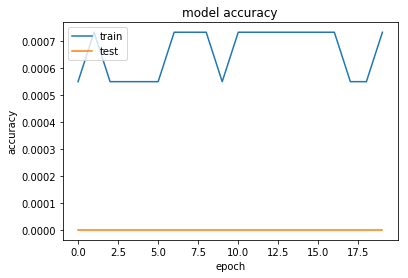

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       248   5          301405.90625  374914.918715


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2184 samples, validate on 12 samples
Epoch 1/20
2184/2184 [==============================] - 0s 147us/step - loss: 0.3076 - acc: 9.1575e-04 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 2/20
2184/2184 [==============================] - 0s 46us/step - loss: 0.1418 - acc: 4.5788e-04 - val_loss: 0.0325 - val_acc: 0.0000e+00
Epoch 3/20
2184/2184 [==============================] - 0s 41us/step - 

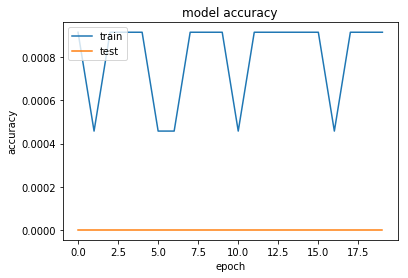

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       248   7         199909.671875  247279.128852


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3276 samples, validate on 18 samples
Epoch 1/20
3276/3276 [==============================] - 0s 102us/step - loss: 0.1211 - acc: 3.0525e-04 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 2/20
3276/3276 [==============================] - 0s 46us/step - loss: 0.0685 - acc: 6.1050e-04 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 3/20
3276/3276 [==============================] - 0s 42us/step - 

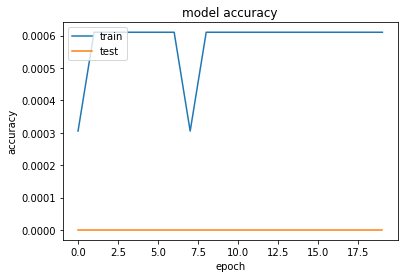

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       248   8           455116.0625  501448.675138


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5490 samples, validate on 30 samples
Epoch 1/20
5490/5490 [==============================] - 0s 91us/step - loss: 0.0797 - acc: 1.8215e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 2/20
5490/5490 [==============================] - 0s 43us/step - loss: 0.0267 - acc: 3.6430e-04 - val_loss: 6.7870e-04 - val_acc: 0.0000e+00
Epoch 3/20
5490/5490 [==============================] - 0s 41us/step

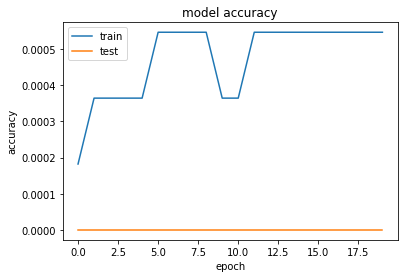

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       249   4          423557.84375  367261.048299


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5490 samples, validate on 30 samples
Epoch 1/20
5490/5490 [==============================] - 0s 79us/step - loss: 0.1630 - acc: 3.6430e-04 - val_loss: 0.0154 - val_acc: 0.0000e+00
Epoch 2/20
5490/5490 [==============================] - 0s 45us/step - loss: 0.0358 - acc: 5.4645e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 3/20
5490/5490 [==============================] - 0s 41us/step - l

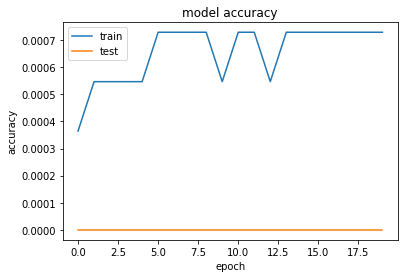

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       249   5           293146.3125  363849.087691


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2196 samples, validate on 12 samples
Epoch 1/20
2196/2196 [==============================] - 0s 143us/step - loss: 0.2604 - acc: 0.0000e+00 - val_loss: 0.0589 - val_acc: 0.0000e+00
Epoch 2/20
2196/2196 [==============================] - 0s 43us/step - loss: 0.1118 - acc: 4.5537e-04 - val_loss: 0.0279 - val_acc: 0.0000e+00
Epoch 3/20
2196/2196 [==============================] - 0s 40us/step - 

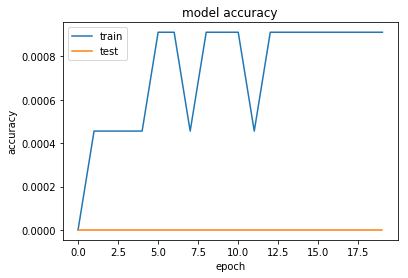

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       249   7          189794.34375  231177.166646


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3294 samples, validate on 18 samples
Epoch 1/20
3294/3294 [==============================] - 0s 107us/step - loss: 0.1739 - acc: 3.0358e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 2/20
3294/3294 [==============================] - 0s 45us/step - loss: 0.0656 - acc: 3.0358e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 3/20
3294/3294 [==============================] - 0s 38us/step - 

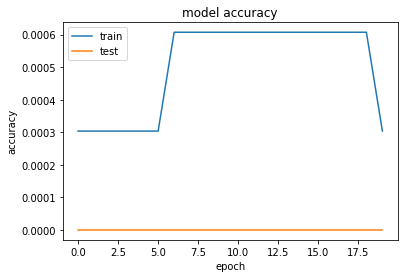

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       249   8            441922.625  500732.678063


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5520 samples, validate on 30 samples
Epoch 1/20
5520/5520 [==============================] - 0s 84us/step - loss: 0.3534 - acc: 1.8116e-04 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 2/20
5520/5520 [==============================] - 0s 46us/step - loss: 0.0328 - acc: 3.6232e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 3/20
5520/5520 [==============================] - 0s 39us/step - l

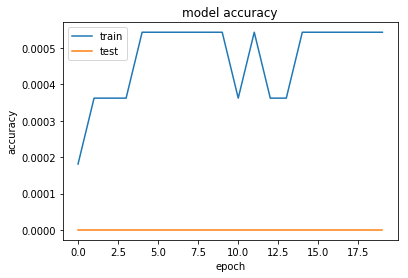

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       250   4          415909.53125  386100.800524


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5520 samples, validate on 30 samples
Epoch 1/20
5520/5520 [==============================] - 0s 80us/step - loss: 0.0638 - acc: 5.4348e-04 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 2/20
5520/5520 [==============================] - 0s 47us/step - loss: 0.0209 - acc: 5.4348e-04 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 3/20
5520/5520 [==============================] - 0s 42us/step - l

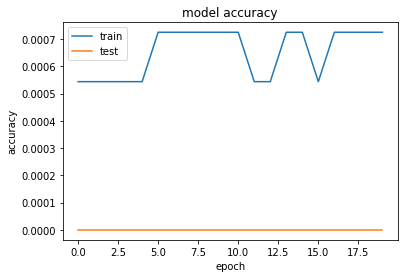

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       250   5            305594.375  345010.055232


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2208 samples, validate on 12 samples
Epoch 1/20
2208/2208 [==============================] - 0s 135us/step - loss: 0.0999 - acc: 4.5290e-04 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 2/20
2208/2208 [==============================] - 0s 47us/step - loss: 0.0699 - acc: 4.5290e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 3/20
2208/2208 [==============================] - 0s 51us/step - 

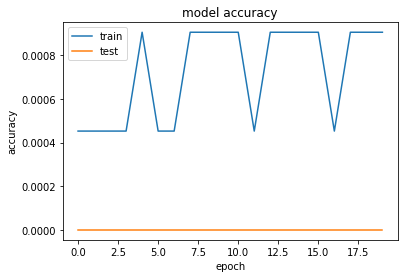

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       250   7          212603.96875  209428.669305


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3312 samples, validate on 18 samples
Epoch 1/20
3312/3312 [==============================] - 0s 100us/step - loss: 0.0937 - acc: 3.0193e-04 - val_loss: 0.0186 - val_acc: 0.0000e+00
Epoch 2/20
3312/3312 [==============================] - 0s 45us/step - loss: 0.0410 - acc: 3.0193e-04 - val_loss: 0.0100 - val_acc: 0.0000e+00
Epoch 3/20
3312/3312 [==============================] - 0s 38us/step - 

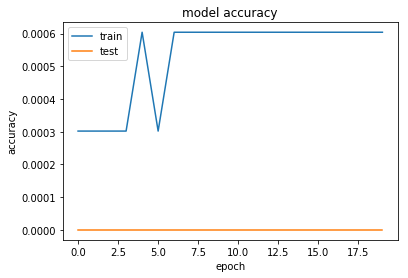

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       250   8           479810.9375  479238.363084


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5550 samples, validate on 30 samples
Epoch 1/20
5550/5550 [==============================] - 0s 77us/step - loss: 0.1406 - acc: 3.6036e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 2/20
5550/5550 [==============================] - 0s 45us/step - loss: 0.0437 - acc: 3.6036e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 3/20
5550/5550 [==============================] - 0s 37us/step - l

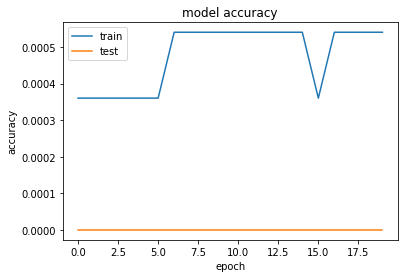

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       251   4          450694.21875  441412.33314


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5550 samples, validate on 30 samples
Epoch 1/20
5550/5550 [==============================] - 0s 84us/step - loss: 0.0522 - acc: 5.4054e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 2/20
5550/5550 [==============================] - 0s 45us/step - loss: 0.0161 - acc: 5.4054e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 3/20
5550/5550 [==============================] - 0s 39us/step - l

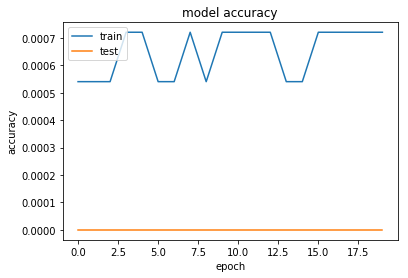

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       251   5           354347.5625  349684.938083


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2220 samples, validate on 12 samples
Epoch 1/20
2220/2220 [==============================] - 0s 143us/step - loss: 0.2698 - acc: 4.5045e-04 - val_loss: 0.0663 - val_acc: 0.0000e+00
Epoch 2/20
2220/2220 [==============================] - 0s 46us/step - loss: 0.1558 - acc: 4.5045e-04 - val_loss: 0.0311 - val_acc: 0.0000e+00
Epoch 3/20
2220/2220 [==============================] - 0s 46us/step - 

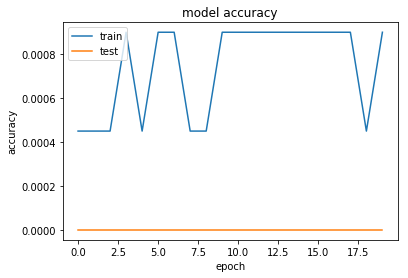

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       251   7         225057.015625  238148.544917


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3330 samples, validate on 18 samples
Epoch 1/20
3330/3330 [==============================] - 0s 108us/step - loss: 0.1422 - acc: 6.0060e-04 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 2/20
3330/3330 [==============================] - 0s 44us/step - loss: 0.0707 - acc: 6.0060e-04 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 3/20
3330/3330 [==============================] - 0s 40us/step - 

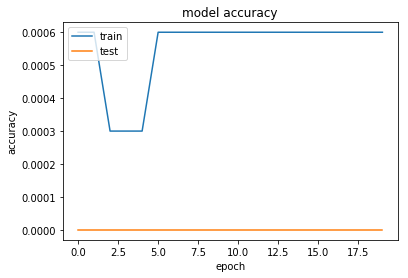

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       251   8           556353.6875  509310.53053


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5580 samples, validate on 30 samples
Epoch 1/20
5580/5580 [==============================] - 0s 78us/step - loss: 0.1129 - acc: 3.5842e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 2/20
5580/5580 [==============================] - 0s 39us/step - loss: 0.0343 - acc: 3.5842e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 3/20
5580/5580 [==============================] - 0s 45us/step - l

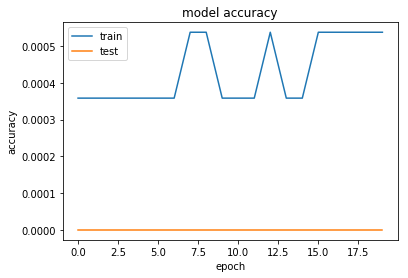

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       252   4          430170.71875  534140.26915


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5580 samples, validate on 30 samples
Epoch 1/20
5580/5580 [==============================] - 0s 74us/step - loss: 0.1666 - acc: 5.3763e-04 - val_loss: 0.0124 - val_acc: 0.0000e+00
Epoch 2/20
5580/5580 [==============================] - 0s 43us/step - loss: 0.0312 - acc: 5.3763e-04 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 3/20
5580/5580 [==============================] - 0s 37us/step - l

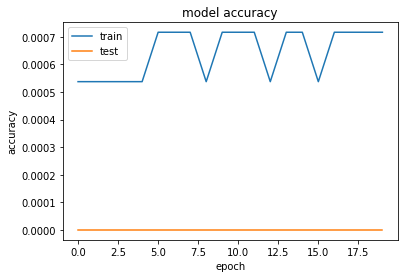

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       252   5              347162.0  355037.302606


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2232 samples, validate on 12 samples
Epoch 1/20
2232/2232 [==============================] - 0s 154us/step - loss: 0.2401 - acc: 4.4803e-04 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 2/20
2232/2232 [==============================] - 0s 46us/step - loss: 0.1453 - acc: 4.4803e-04 - val_loss: 0.0323 - val_acc: 0.0000e+00
Epoch 3/20
2232/2232 [==============================] - 0s 42us/step - 

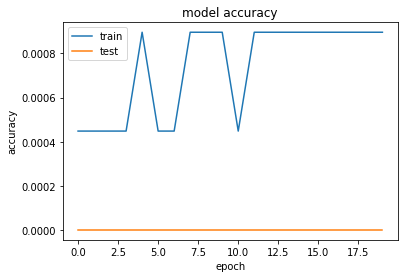

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       252   7           238138.8125  305185.522585


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3348 samples, validate on 18 samples
Epoch 1/20
3348/3348 [==============================] - 0s 106us/step - loss: 0.1060 - acc: 2.9869e-04 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 2/20
3348/3348 [==============================] - 0s 51us/step - loss: 0.0535 - acc: 2.9869e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/20
3348/3348 [==============================] - 0s 41us/step - 

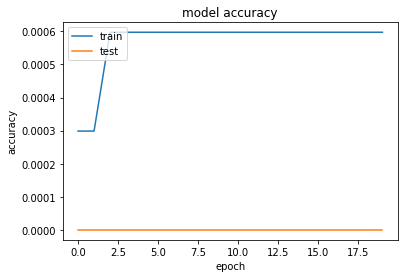

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       252   8           569401.6875  538431.10415


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5610 samples, validate on 30 samples
Epoch 1/20
5610/5610 [==============================] - 0s 81us/step - loss: 0.0614 - acc: 3.5651e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 2/20
5610/5610 [==============================] - 0s 43us/step - loss: 0.0203 - acc: 3.5651e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 3/20
5610/5610 [==============================] - 0s 40us/step - l

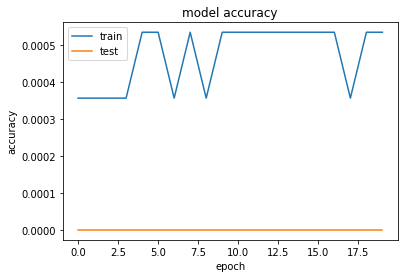

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       253   4          491402.28125  528980.609369


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5610 samples, validate on 30 samples
Epoch 1/20
5610/5610 [==============================] - 0s 80us/step - loss: 0.7623 - acc: 3.5651e-04 - val_loss: 0.0731 - val_acc: 0.0000e+00
Epoch 2/20
5610/5610 [==============================] - 0s 45us/step - loss: 0.0763 - acc: 5.3476e-04 - val_loss: 0.0164 - val_acc: 0.0000e+00
Epoch 3/20
5610/5610 [==============================] - 0s 38us/step - l

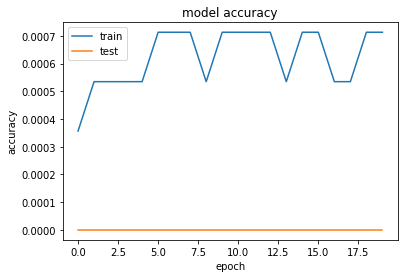

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       253   5           363105.1875  359818.29793


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2244 samples, validate on 12 samples
Epoch 1/20
2244/2244 [==============================] - 0s 138us/step - loss: 0.1959 - acc: 8.9127e-04 - val_loss: 0.0355 - val_acc: 0.0000e+00
Epoch 2/20
2244/2244 [==============================] - 0s 49us/step - loss: 0.1280 - acc: 8.9127e-04 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 3/20
2244/2244 [==============================] - 0s 42us/step - 

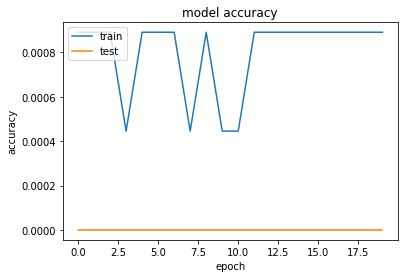

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       253   7          209505.28125  239333.363073


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3366 samples, validate on 18 samples
Epoch 1/20
3366/3366 [==============================] - 0s 104us/step - loss: 0.1902 - acc: 2.9709e-04 - val_loss: 0.0365 - val_acc: 0.0000e+00
Epoch 2/20
3366/3366 [==============================] - 0s 42us/step - loss: 0.0758 - acc: 2.9709e-04 - val_loss: 0.0149 - val_acc: 0.0000e+00
Epoch 3/20
3366/3366 [==============================] - 0s 38us/step - 

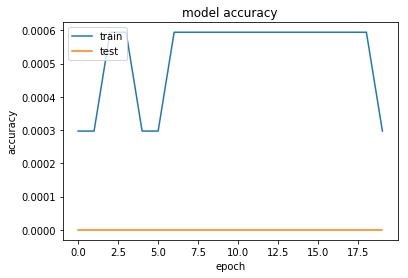

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       253   8           531977.1875  533092.625787


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5640 samples, validate on 30 samples
Epoch 1/20
5640/5640 [==============================] - 0s 77us/step - loss: 0.0951 - acc: 3.5461e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 2/20
5640/5640 [==============================] - 0s 44us/step - loss: 0.0301 - acc: 3.5461e-04 - val_loss: 9.1732e-04 - val_acc: 0.0000e+00
Epoch 3/20
5640/5640 [==============================] - 0s 37us/step

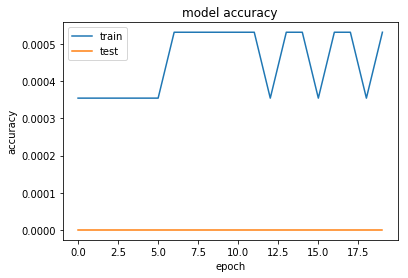

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       254   4           486845.6875  518252.502101


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5640 samples, validate on 30 samples
Epoch 1/20
5640/5640 [==============================] - 0s 78us/step - loss: 0.3151 - acc: 5.3191e-04 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 2/20
5640/5640 [==============================] - 0s 42us/step - loss: 0.0381 - acc: 5.3191e-04 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 3/20
5640/5640 [==============================] - 0s 38us/step - l

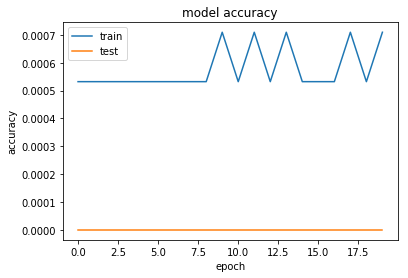

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       254   5          331547.59375  341731.405426


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2256 samples, validate on 12 samples
Epoch 1/20
2256/2256 [==============================] - 0s 137us/step - loss: 0.1244 - acc: 4.4326e-04 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 2/20
2256/2256 [==============================] - 0s 50us/step - loss: 0.0733 - acc: 4.4326e-04 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 3/20
2256/2256 [==============================] - 0s 44us/step - 

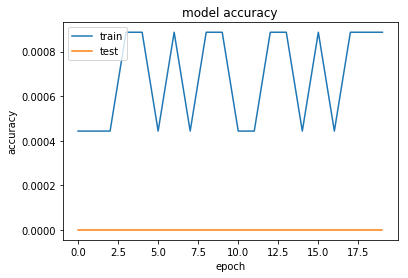

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       254   7           229259.4375  226416.821761


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3384 samples, validate on 18 samples
Epoch 1/20
3384/3384 [==============================] - 0s 101us/step - loss: 0.1127 - acc: 5.9102e-04 - val_loss: 0.0114 - val_acc: 0.0000e+00
Epoch 2/20
3384/3384 [==============================] - 0s 47us/step - loss: 0.0580 - acc: 5.9102e-04 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 3/20
3384/3384 [==============================] - 0s 39us/step - 

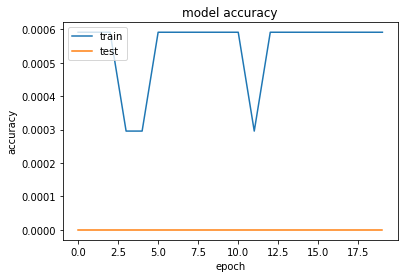

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       254   8           524770.6875  542291.850877


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5670 samples, validate on 30 samples
Epoch 1/20
5670/5670 [==============================] - 0s 82us/step - loss: 0.1785 - acc: 3.5273e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 2/20
5670/5670 [==============================] - 0s 42us/step - loss: 0.0317 - acc: 3.5273e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/20
5670/5670 [==============================] - 0s 37us/step - l

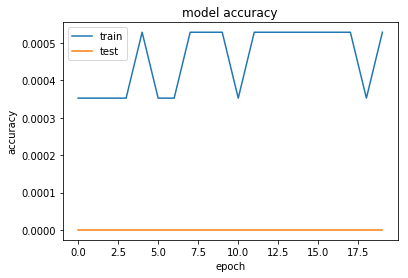

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       255   4            537053.875  548315.358245


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5670 samples, validate on 30 samples
Epoch 1/20
5670/5670 [==============================] - 0s 75us/step - loss: 0.1303 - acc: 5.2910e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 2/20
5670/5670 [==============================] - 0s 44us/step - loss: 0.0439 - acc: 5.2910e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 3/20
5670/5670 [==============================] - 0s 38us/step - l

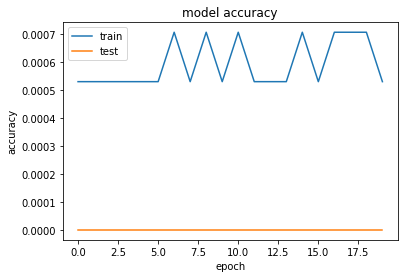

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       255   5           361212.6875  426552.681887


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2268 samples, validate on 12 samples
Epoch 1/20
2268/2268 [==============================] - 0s 137us/step - loss: 0.1499 - acc: 4.4092e-04 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 2/20
2268/2268 [==============================] - 0s 42us/step - loss: 0.0880 - acc: 4.4092e-04 - val_loss: 0.0226 - val_acc: 0.0000e+00
Epoch 3/20
2268/2268 [==============================] - 0s 39us/step - 

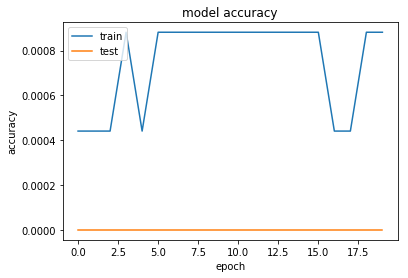

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       255   7           249684.9375  283494.627649


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3402 samples, validate on 18 samples
Epoch 1/20
3402/3402 [==============================] - 0s 108us/step - loss: 0.0785 - acc: 2.9394e-04 - val_loss: 0.0231 - val_acc: 0.0000e+00
Epoch 2/20
3402/3402 [==============================] - 0s 44us/step - loss: 0.0422 - acc: 2.9394e-04 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 3/20
3402/3402 [==============================] - 0s 38us/step - 

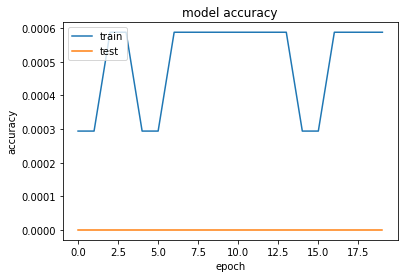

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       255   8             589775.75  680014.004637


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5700 samples, validate on 30 samples
Epoch 1/20
5700/5700 [==============================] - 0s 83us/step - loss: 0.1933 - acc: 3.5088e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 2/20
5700/5700 [==============================] - 0s 43us/step - loss: 0.0525 - acc: 3.5088e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 3/20
5700/5700 [==============================] - 0s 39us/step - l

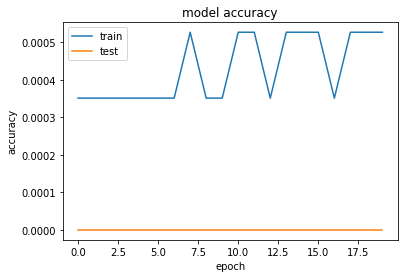

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       256   4          502614.84375  452273.940298


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5700 samples, validate on 30 samples
Epoch 1/20
5700/5700 [==============================] - 0s 75us/step - loss: 0.0627 - acc: 7.0175e-04 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 2/20
5700/5700 [==============================] - 0s 44us/step - loss: 0.0196 - acc: 5.2632e-04 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 3/20
5700/5700 [==============================] - 0s 38us/step - l

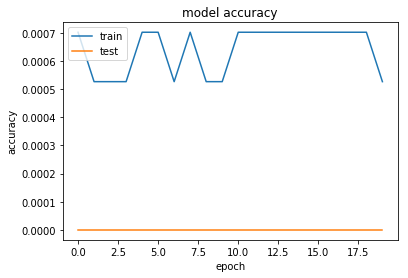

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       256   5              353378.5  395721.268829


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2280 samples, validate on 12 samples
Epoch 1/20
2280/2280 [==============================] - 0s 148us/step - loss: 0.1370 - acc: 4.3860e-04 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 2/20
2280/2280 [==============================] - 0s 45us/step - loss: 0.0776 - acc: 4.3860e-04 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 3/20
2280/2280 [==============================] - 0s 44us/step - 

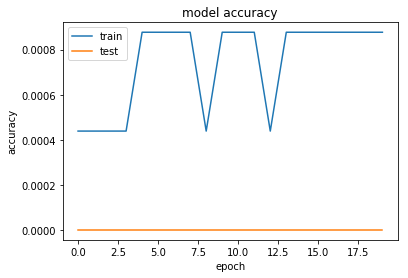

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       256   7           252882.3125  202821.868648


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3420 samples, validate on 18 samples
Epoch 1/20
3420/3420 [==============================] - 0s 102us/step - loss: 0.2191 - acc: 2.9240e-04 - val_loss: 0.0245 - val_acc: 0.0000e+00
Epoch 2/20
3420/3420 [==============================] - 0s 46us/step - loss: 0.1171 - acc: 5.8480e-04 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 3/20
3420/3420 [==============================] - 0s 41us/step - 

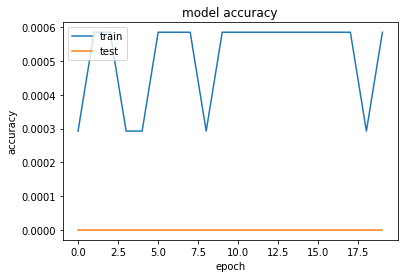

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       256   8           564744.6875  598207.481108


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5730 samples, validate on 30 samples
Epoch 1/20
5730/5730 [==============================] - 0s 85us/step - loss: 0.1090 - acc: 3.4904e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
5730/5730 [==============================] - 0s 42us/step - loss: 0.0355 - acc: 3.4904e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 3/20
5730/5730 [==============================] - 0s 39us/step - l

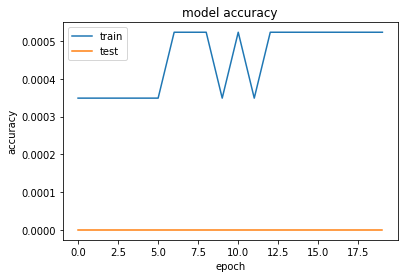

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       257   4          441197.03125  342788.333017


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5730 samples, validate on 30 samples
Epoch 1/20
5730/5730 [==============================] - 0s 83us/step - loss: 0.0955 - acc: 5.2356e-04 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 2/20
5730/5730 [==============================] - 0s 42us/step - loss: 0.0299 - acc: 5.2356e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 3/20
5730/5730 [==============================] - 0s 40us/step - l

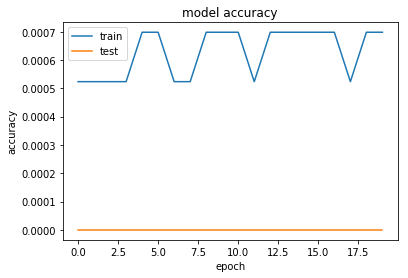

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       257   5          346884.84375  339361.409582


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2292 samples, validate on 12 samples
Epoch 1/20
2292/2292 [==============================] - 0s 146us/step - loss: 0.0855 - acc: 4.3630e-04 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 2/20
2292/2292 [==============================] - 0s 50us/step - loss: 0.0531 - acc: 4.3630e-04 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 3/20
2292/2292 [==============================] - 0s 40us/step - 

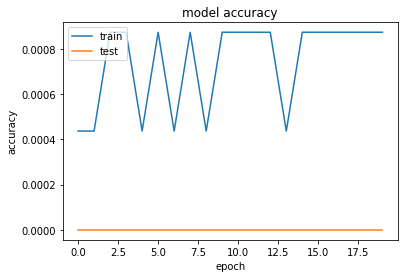

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       257   7         227507.640625  155423.62104


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3438 samples, validate on 18 samples
Epoch 1/20
3438/3438 [==============================] - 0s 104us/step - loss: 0.0730 - acc: 0.0000e+00 - val_loss: 0.0130 - val_acc: 0.0000e+00
Epoch 2/20
3438/3438 [==============================] - 0s 41us/step - loss: 0.0365 - acc: 2.9087e-04 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 3/20
3438/3438 [==============================] - 0s 39us/step - 

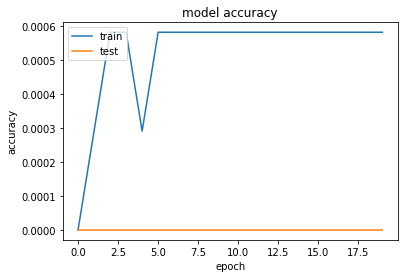

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       257   8          510961.34375  492495.53611


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5760 samples, validate on 30 samples
Epoch 1/20
5760/5760 [==============================] - 0s 77us/step - loss: 0.2213 - acc: 1.7361e-04 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 2/20
5760/5760 [==============================] - 0s 42us/step - loss: 0.0567 - acc: 3.4722e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 3/20
5760/5760 [==============================] - 0s 37us/step - l

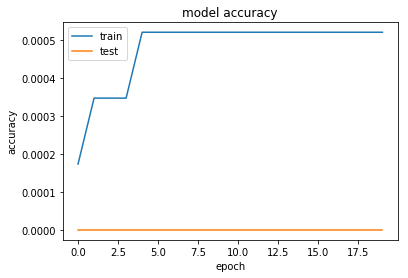

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       258   4           367363.4375  428171.958509


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5760 samples, validate on 30 samples
Epoch 1/20
5760/5760 [==============================] - 0s 79us/step - loss: 0.2103 - acc: 5.2083e-04 - val_loss: 0.0178 - val_acc: 0.0000e+00
Epoch 2/20
5760/5760 [==============================] - 0s 41us/step - loss: 0.0345 - acc: 5.2083e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 3/20
5760/5760 [==============================] - 0s 38us/step - l

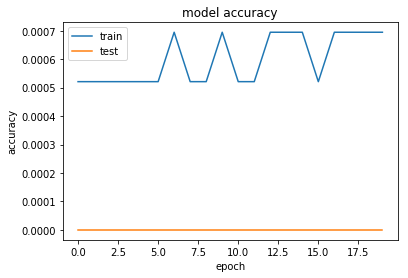

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       258   5           340828.0625  399373.784141


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2304 samples, validate on 12 samples
Epoch 1/20
2304/2304 [==============================] - 0s 137us/step - loss: 0.3469 - acc: 4.3403e-04 - val_loss: 0.0352 - val_acc: 0.0000e+00
Epoch 2/20
2304/2304 [==============================] - 0s 51us/step - loss: 0.1438 - acc: 4.3403e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 3/20
2304/2304 [==============================] - 0s 42us/step - 

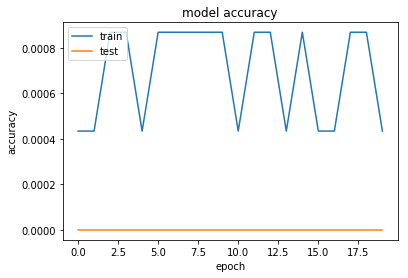

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       258   7           194022.5625  174791.415957


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3456 samples, validate on 18 samples
Epoch 1/20
3456/3456 [==============================] - 0s 106us/step - loss: 0.1444 - acc: 5.7870e-04 - val_loss: 0.0379 - val_acc: 0.0000e+00
Epoch 2/20
3456/3456 [==============================] - 0s 44us/step - loss: 0.0645 - acc: 5.7870e-04 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 3/20
3456/3456 [==============================] - 0s 40us/step - 

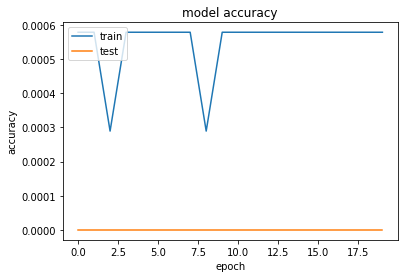

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       258   8            501043.625  633240.218663


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5790 samples, validate on 30 samples
Epoch 1/20
5790/5790 [==============================] - 0s 80us/step - loss: 0.0832 - acc: 5.1813e-04 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 2/20
5790/5790 [==============================] - 0s 44us/step - loss: 0.0223 - acc: 3.4542e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
5790/5790 [==============================] - 0s 40us/step - l

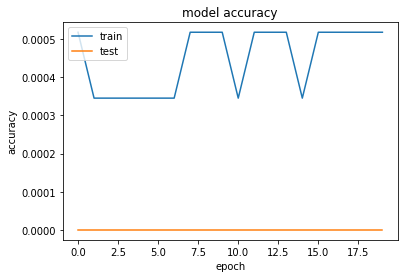

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       259   4              331252.0  377791.942762


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5790 samples, validate on 30 samples
Epoch 1/20
5790/5790 [==============================] - 0s 78us/step - loss: 0.0629 - acc: 5.1813e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
5790/5790 [==============================] - 0s 43us/step - loss: 0.0211 - acc: 5.1813e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
5790/5790 [==============================] - 0s 37us/step - l

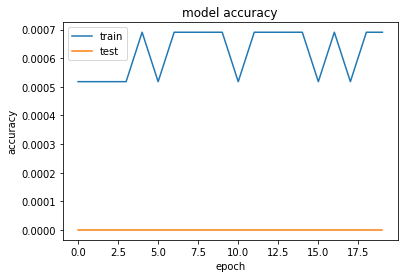

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       259   5           293794.1875  275472.578259


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2316 samples, validate on 12 samples
Epoch 1/20
2316/2316 [==============================] - 0s 145us/step - loss: 0.2048 - acc: 4.3178e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 2/20
2316/2316 [==============================] - 0s 49us/step - loss: 0.1301 - acc: 4.3178e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 3/20
2316/2316 [==============================] - 0s 40us/step - 

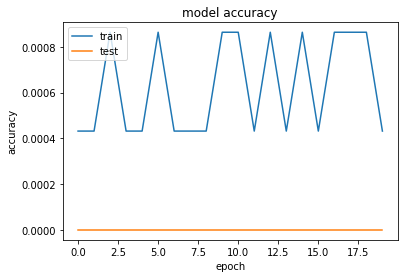

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       259   7            186858.125  153640.894671


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3474 samples, validate on 18 samples
Epoch 1/20
3474/3474 [==============================] - 0s 102us/step - loss: 0.5618 - acc: 2.8785e-04 - val_loss: 0.3336 - val_acc: 0.0000e+00
Epoch 2/20
3474/3474 [==============================] - 0s 46us/step - loss: 0.2063 - acc: 2.8785e-04 - val_loss: 0.0718 - val_acc: 0.0000e+00
Epoch 3/20
3474/3474 [==============================] - 0s 38us/step - 

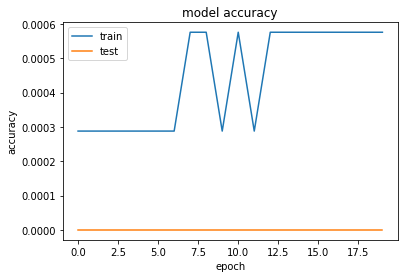

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       259   8          433379.03125  419388.936094


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5820 samples, validate on 30 samples
Epoch 1/20
5820/5820 [==============================] - 0s 74us/step - loss: 0.0540 - acc: 3.4364e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
5820/5820 [==============================] - 0s 41us/step - loss: 0.0162 - acc: 5.1546e-04 - val_loss: 9.4322e-04 - val_acc: 0.0000e+00
Epoch 3/20
5820/5820 [==============================] - 0s 37us/step

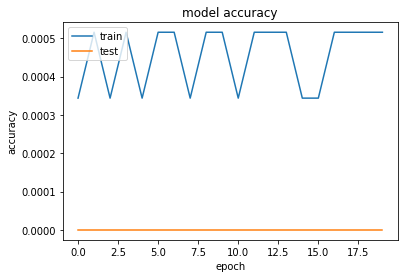

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       260   4           317410.4375  359791.125812


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5820 samples, validate on 30 samples
Epoch 1/20
5820/5820 [==============================] - 0s 79us/step - loss: 0.1344 - acc: 5.1546e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 2/20
5820/5820 [==============================] - 0s 42us/step - loss: 0.0393 - acc: 6.8729e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 3/20
5820/5820 [==============================] - 0s 37us/step - l

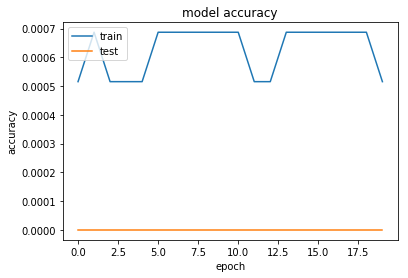

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       260   5              265765.0  258341.937887


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2328 samples, validate on 12 samples
Epoch 1/20
2328/2328 [==============================] - 0s 128us/step - loss: 0.1127 - acc: 4.2955e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 2/20
2328/2328 [==============================] - 0s 44us/step - loss: 0.0685 - acc: 4.2955e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 3/20
2328/2328 [==============================] - 0s 47us/step - 

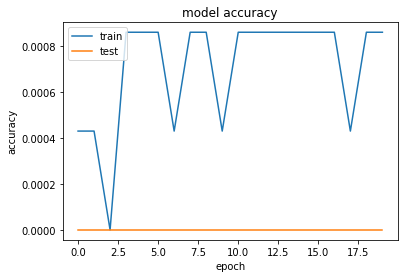

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       260   7         158372.453125  134344.015361


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3492 samples, validate on 18 samples
Epoch 1/20
3492/3492 [==============================] - 0s 100us/step - loss: 0.1080 - acc: 2.8637e-04 - val_loss: 0.0113 - val_acc: 0.0000e+00
Epoch 2/20
3492/3492 [==============================] - 0s 49us/step - loss: 0.0543 - acc: 5.7274e-04 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 3/20
3492/3492 [==============================] - 0s 45us/step - 

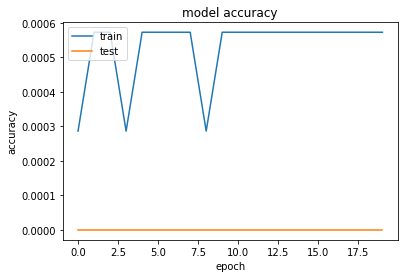

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       260   8           380765.9375  365104.338922


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5850 samples, validate on 30 samples
Epoch 1/20
5850/5850 [==============================] - 1s 95us/step - loss: 0.0264 - acc: 3.4188e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
5850/5850 [==============================] - 0s 42us/step - loss: 0.0091 - acc: 3.4188e-04 - val_loss: 9.4660e-04 - val_acc: 0.0000e+00
Epoch 3/20
5850/5850 [==============================] - 0s 35us/step

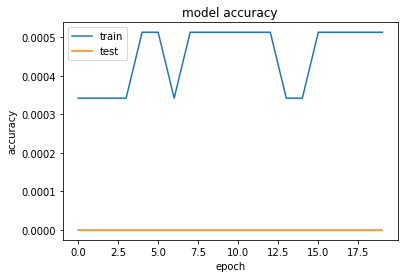

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       261   4          332788.15625  363505.81961


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5850 samples, validate on 30 samples
Epoch 1/20
5850/5850 [==============================] - 0s 74us/step - loss: 0.2697 - acc: 1.7094e-04 - val_loss: 0.0128 - val_acc: 0.0000e+00
Epoch 2/20
5850/5850 [==============================] - 0s 43us/step - loss: 0.0639 - acc: 3.4188e-04 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 3/20
5850/5850 [==============================] - 0s 38us/step - l

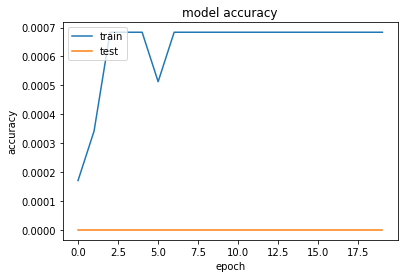

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       261   5         248110.640625  242855.735436


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2340 samples, validate on 12 samples
Epoch 1/20
2340/2340 [==============================] - 0s 129us/step - loss: 0.1943 - acc: 4.2735e-04 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 2/20
2340/2340 [==============================] - 0s 47us/step - loss: 0.1312 - acc: 4.2735e-04 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 3/20
2340/2340 [==============================] - 0s 39us/step - 

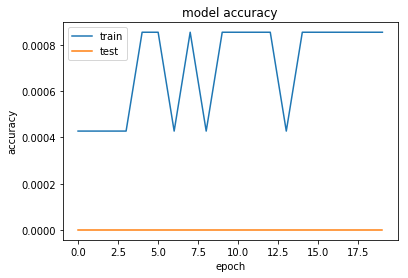

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       261   7         141337.828125  122577.459255


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3510 samples, validate on 18 samples
Epoch 1/20
3510/3510 [==============================] - 0s 112us/step - loss: 0.2924 - acc: 0.0000e+00 - val_loss: 0.0700 - val_acc: 0.0000e+00
Epoch 2/20
3510/3510 [==============================] - 0s 43us/step - loss: 0.0829 - acc: 2.8490e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 3/20
3510/3510 [==============================] - 0s 40us/step - 

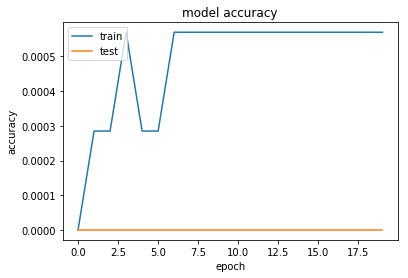

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       261   8          332238.34375  298707.170916


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5880 samples, validate on 30 samples
Epoch 1/20
5880/5880 [==============================] - 0s 82us/step - loss: 0.1028 - acc: 3.4014e-04 - val_loss: 8.7340e-04 - val_acc: 0.0000e+00
Epoch 2/20
5880/5880 [==============================] - 0s 47us/step - loss: 0.0310 - acc: 3.4014e-04 - val_loss: 3.4172e-04 - val_acc: 0.0000e+00
Epoch 3/20
5880/5880 [==============================] - 0s 39us/

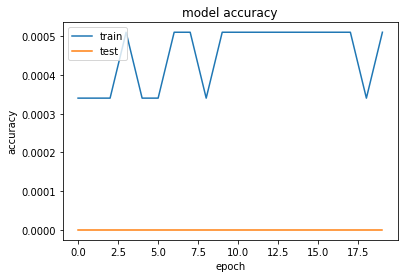

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       262   4             337113.75  318812.568643


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5880 samples, validate on 30 samples
Epoch 1/20
5880/5880 [==============================] - 0s 74us/step - loss: 0.0633 - acc: 5.1020e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 2/20
5880/5880 [==============================] - 0s 46us/step - loss: 0.0196 - acc: 5.1020e-04 - val_loss: 9.0851e-04 - val_acc: 0.0000e+00
Epoch 3/20
5880/5880 [==============================] - 0s 41us/step

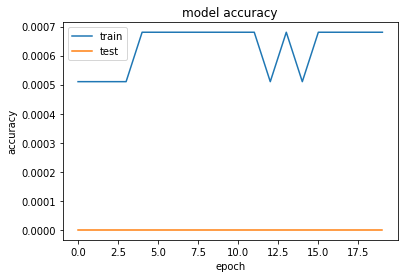

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       262   5          225653.28125  234152.627589


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2352 samples, validate on 12 samples
Epoch 1/20
2352/2352 [==============================] - 0s 129us/step - loss: 0.6259 - acc: 4.2517e-04 - val_loss: 0.2739 - val_acc: 0.0000e+00
Epoch 2/20
2352/2352 [==============================] - 0s 43us/step - loss: 0.2152 - acc: 4.2517e-04 - val_loss: 0.0461 - val_acc: 0.0000e+00
Epoch 3/20
2352/2352 [==============================] - 0s 45us/step - 

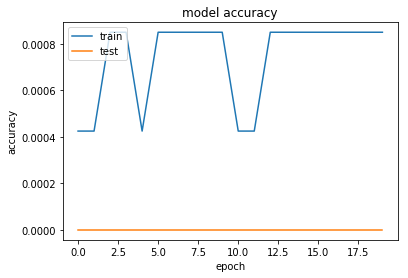

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       262   7         139215.015625  116871.112081


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3528 samples, validate on 18 samples
Epoch 1/20
3528/3528 [==============================] - 0s 94us/step - loss: 0.1389 - acc: 2.8345e-04 - val_loss: 0.0293 - val_acc: 0.0000e+00
Epoch 2/20
3528/3528 [==============================] - 0s 44us/step - loss: 0.0762 - acc: 2.8345e-04 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 3/20
3528/3528 [==============================] - 0s 39us/step - l

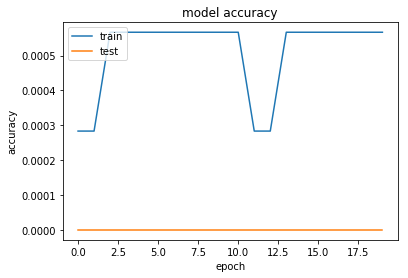

   testWeek  DC  Nplus2CUBEPrediction  Nplus2CUBE
0       262   8          376209.34375    383201.6


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5910 samples, validate on 30 samples
Epoch 1/20
5910/5910 [==============================] - 0s 77us/step - loss: 0.1057 - acc: 3.3841e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 2/20
5910/5910 [==============================] - 0s 42us/step - loss: 0.0317 - acc: 3.3841e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
5910/5910 [==============================] - 0s 37us/step - l

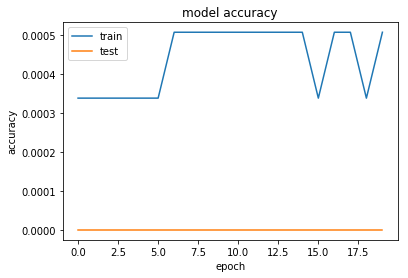

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       263   4          269008.34375  283821.890919


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5910 samples, validate on 30 samples
Epoch 1/20
5910/5910 [==============================] - 0s 79us/step - loss: 0.3941 - acc: 1.6920e-04 - val_loss: 0.0338 - val_acc: 0.0000e+00
Epoch 2/20
5910/5910 [==============================] - 0s 41us/step - loss: 0.0657 - acc: 5.0761e-04 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 3/20
5910/5910 [==============================] - 0s 38us/step - l

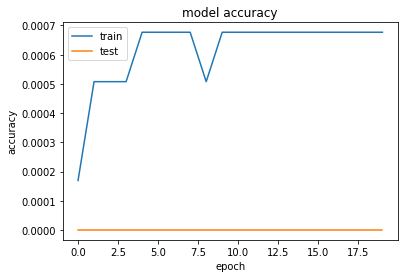

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       263   5         214790.953125  214768.462203


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2364 samples, validate on 12 samples
Epoch 1/20
2364/2364 [==============================] - 0s 140us/step - loss: 0.3351 - acc: 4.2301e-04 - val_loss: 0.0217 - val_acc: 0.0000e+00
Epoch 2/20
2364/2364 [==============================] - 0s 39us/step - loss: 0.1433 - acc: 4.2301e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 3/20
2364/2364 [==============================] - 0s 40us/step - 

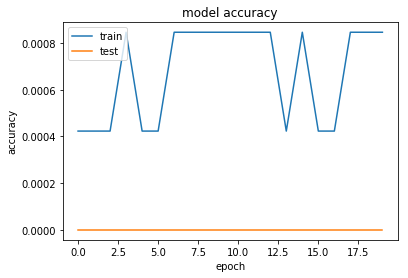

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       263   7         141806.984375  115275.593662


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3546 samples, validate on 18 samples
Epoch 1/20
3546/3546 [==============================] - 0s 105us/step - loss: 0.1413 - acc: 2.8201e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 2/20
3546/3546 [==============================] - 0s 44us/step - loss: 0.0707 - acc: 5.6402e-04 - val_loss: 8.4881e-04 - val_acc: 0.0000e+00
Epoch 3/20
3546/3546 [==============================] - 0s 41us/ste

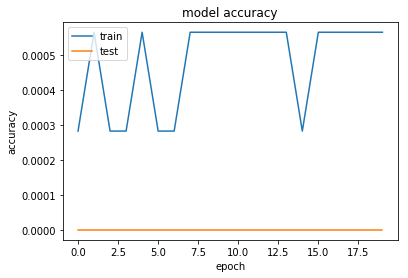

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       263   8          315041.90625  357074.447027


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5940 samples, validate on 30 samples
Epoch 1/20
5940/5940 [==============================] - 0s 75us/step - loss: 0.2293 - acc: 3.3670e-04 - val_loss: 0.0171 - val_acc: 0.0000e+00
Epoch 2/20
5940/5940 [==============================] - 0s 42us/step - loss: 0.0319 - acc: 3.3670e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/20
5940/5940 [==============================] - 0s 38us/step - l

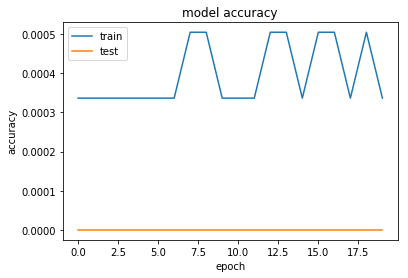

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       264   4           361378.4375  299040.15713


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5940 samples, validate on 30 samples
Epoch 1/20
5940/5940 [==============================] - 0s 74us/step - loss: 0.1000 - acc: 5.0505e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 2/20
5940/5940 [==============================] - 0s 45us/step - loss: 0.0250 - acc: 5.0505e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
5940/5940 [==============================] - 0s 38us/step - l

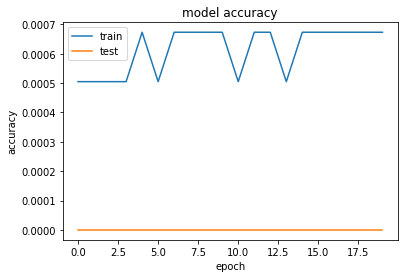

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       264   5          219858.34375  207377.661968


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2376 samples, validate on 12 samples
Epoch 1/20
2376/2376 [==============================] - 0s 134us/step - loss: 0.1937 - acc: 4.2088e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 2/20
2376/2376 [==============================] - 0s 43us/step - loss: 0.0768 - acc: 4.2088e-04 - val_loss: 5.9747e-04 - val_acc: 0.0000e+00
Epoch 3/20
2376/2376 [==============================] - 0s 45us/ste

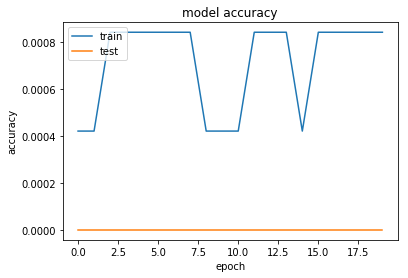

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       264   7         130202.648438  127986.550962


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3564 samples, validate on 18 samples
Epoch 1/20
3564/3564 [==============================] - 0s 102us/step - loss: 0.0854 - acc: 5.6117e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 2/20
3564/3564 [==============================] - 0s 44us/step - loss: 0.0440 - acc: 5.6117e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 3/20
3564/3564 [==============================] - 0s 38us/step - 

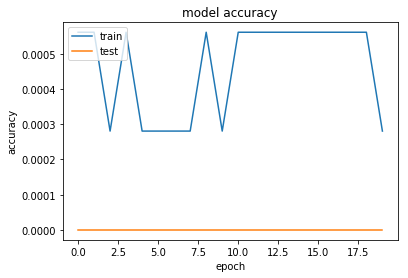

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       264   8          302305.71875  350075.848447


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5970 samples, validate on 30 samples
Epoch 1/20
5970/5970 [==============================] - 0s 76us/step - loss: 0.1007 - acc: 3.3501e-04 - val_loss: 9.7001e-04 - val_acc: 0.0000e+00
Epoch 2/20
5970/5970 [==============================] - 0s 45us/step - loss: 0.0324 - acc: 3.3501e-04 - val_loss: 4.0523e-04 - val_acc: 0.0000e+00
Epoch 3/20
5970/5970 [==============================] - 0s 38us/

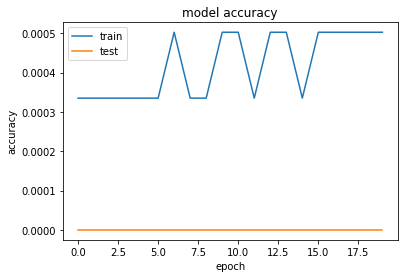

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       265   4          308330.28125  265555.613642


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 5970 samples, validate on 30 samples
Epoch 1/20
5970/5970 [==============================] - 0s 80us/step - loss: 0.1763 - acc: 5.0251e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 2/20
5970/5970 [==============================] - 0s 43us/step - loss: 0.0498 - acc: 5.0251e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 3/20
5970/5970 [==============================] - 0s 42us/step - l

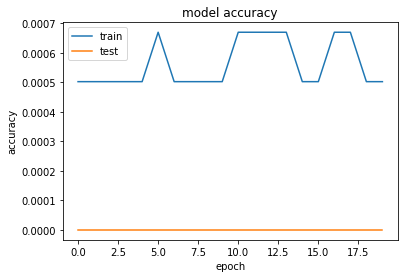

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       265   5           208947.0625  232488.838307


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2388 samples, validate on 12 samples
Epoch 1/20
2388/2388 [==============================] - 0s 128us/step - loss: 0.3948 - acc: 4.1876e-04 - val_loss: 0.0697 - val_acc: 0.0000e+00
Epoch 2/20
2388/2388 [==============================] - 0s 42us/step - loss: 0.1310 - acc: 4.1876e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 3/20
2388/2388 [==============================] - 0s 39us/step - 

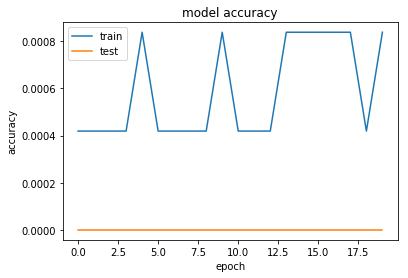

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       265   7          128325.15625  105587.552927


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3582 samples, validate on 18 samples
Epoch 1/20
3582/3582 [==============================] - 0s 113us/step - loss: 0.2315 - acc: 2.7917e-04 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 2/20
3582/3582 [==============================] - 0s 45us/step - loss: 0.0684 - acc: 2.7917e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
3582/3582 [==============================] - 0s 39us/step - 

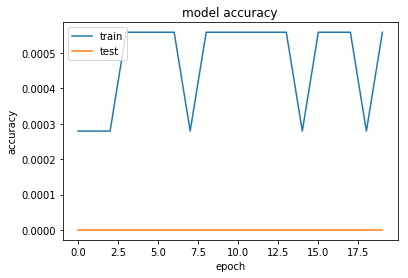

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       265   8           335352.6875  264976.430103


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 30 samples
Epoch 1/20
6000/6000 [==============================] - 0s 77us/step - loss: 0.2243 - acc: 3.3333e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 2/20
6000/6000 [==============================] - 0s 47us/step - loss: 0.0418 - acc: 3.3333e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
6000/6000 [==============================] - 0s 37us/step - l

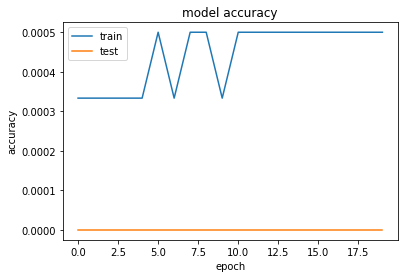

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       266   4          267131.46875  234862.385081


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 30 samples
Epoch 1/20
6000/6000 [==============================] - 0s 77us/step - loss: 0.1481 - acc: 1.6667e-04 - val_loss: 0.0154 - val_acc: 0.0000e+00
Epoch 2/20
6000/6000 [==============================] - 0s 43us/step - loss: 0.0382 - acc: 5.0000e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 3/20
6000/6000 [==============================] - 0s 39us/step - l

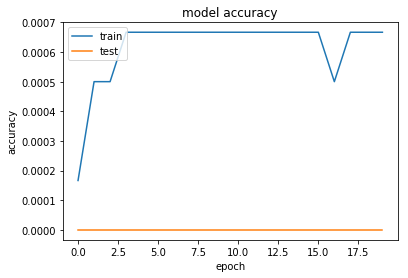

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       266   5         196448.140625  234968.635775


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2400 samples, validate on 12 samples
Epoch 1/20
2400/2400 [==============================] - 0s 137us/step - loss: 0.1697 - acc: 4.1667e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 2/20
2400/2400 [==============================] - 0s 49us/step - loss: 0.1034 - acc: 4.1667e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
2400/2400 [==============================] - 0s 43us/step - 

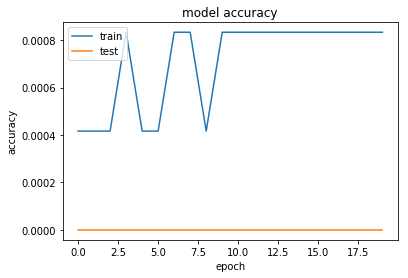

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       266   7         111710.257812  102790.916834


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3600 samples, validate on 18 samples
Epoch 1/20
3600/3600 [==============================] - 0s 106us/step - loss: 0.1875 - acc: 2.7778e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 2/20
3600/3600 [==============================] - 0s 41us/step - loss: 0.0654 - acc: 5.5556e-04 - val_loss: 8.6575e-04 - val_acc: 0.0000e+00
Epoch 3/20
3600/3600 [==============================] - 0s 40us/ste

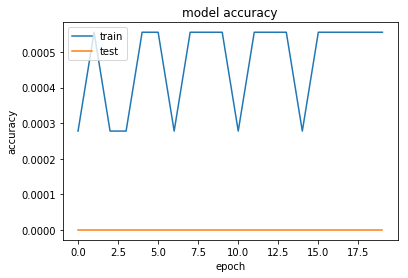

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       266   8           316785.8125  242568.323856


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6030 samples, validate on 30 samples
Epoch 1/20
6030/6030 [==============================] - 0s 72us/step - loss: 0.0870 - acc: 3.3167e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 2/20
6030/6030 [==============================] - 0s 44us/step - loss: 0.0257 - acc: 3.3167e-04 - val_loss: 9.2701e-04 - val_acc: 0.0000e+00
Epoch 3/20
6030/6030 [==============================] - 0s 36us/step

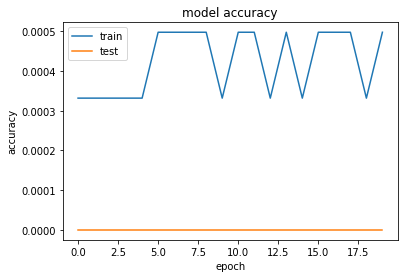

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       267   4           240630.3125  256330.244288


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6030 samples, validate on 30 samples
Epoch 1/20
6030/6030 [==============================] - 0s 75us/step - loss: 0.1520 - acc: 3.3167e-04 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 2/20
6030/6030 [==============================] - 0s 41us/step - loss: 0.0431 - acc: 4.9751e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 3/20
6030/6030 [==============================] - 0s 38us/step - l

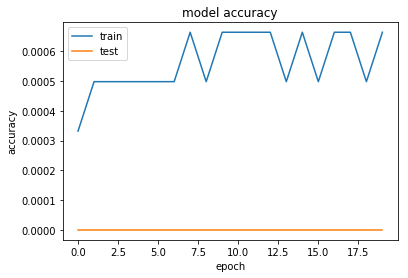

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       267   5           201296.0625  215537.961282


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2412 samples, validate on 12 samples
Epoch 1/20
2412/2412 [==============================] - 0s 132us/step - loss: 0.2705 - acc: 4.1459e-04 - val_loss: 0.0158 - val_acc: 0.0000e+00
Epoch 2/20
2412/2412 [==============================] - 0s 41us/step - loss: 0.1128 - acc: 4.1459e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 3/20
2412/2412 [==============================] - 0s 44us/step - 

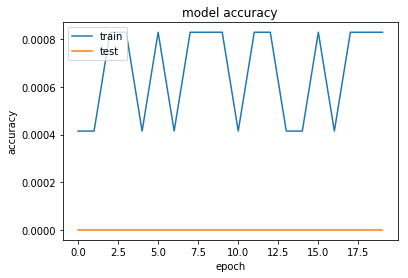

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       267   7         123482.539062  105067.67855


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3618 samples, validate on 18 samples
Epoch 1/20
3618/3618 [==============================] - 0s 106us/step - loss: 0.1068 - acc: 2.7640e-04 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 2/20
3618/3618 [==============================] - 0s 46us/step - loss: 0.0482 - acc: 2.7640e-04 - val_loss: 9.6611e-04 - val_acc: 0.0000e+00
Epoch 3/20
3618/3618 [==============================] - 0s 38us/ste

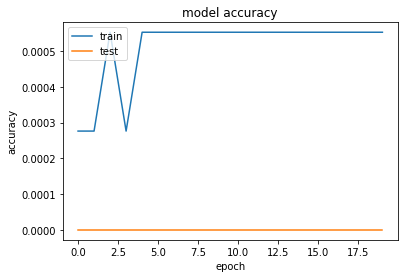

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       267   8         247611.109375  264397.156173


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6060 samples, validate on 30 samples
Epoch 1/20
6060/6060 [==============================] - 0s 77us/step - loss: 0.1404 - acc: 3.3003e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 2/20
6060/6060 [==============================] - 0s 42us/step - loss: 0.0319 - acc: 3.3003e-04 - val_loss: 4.3855e-04 - val_acc: 0.0000e+00
Epoch 3/20
6060/6060 [==============================] - 0s 42us/step

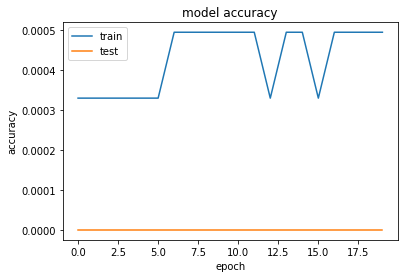

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       268   4           302770.8125  266050.944931


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6060 samples, validate on 30 samples
Epoch 1/20
6060/6060 [==============================] - 0s 74us/step - loss: 0.2423 - acc: 4.9505e-04 - val_loss: 0.0282 - val_acc: 0.0000e+00
Epoch 2/20
6060/6060 [==============================] - 0s 42us/step - loss: 0.0410 - acc: 4.9505e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 3/20
6060/6060 [==============================] - 0s 37us/step - l

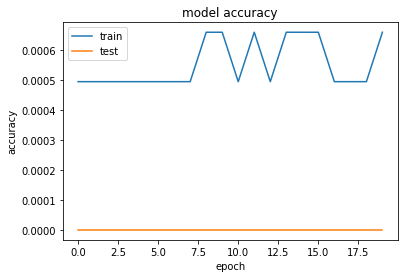

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       268   5              232033.0  212897.281576


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2424 samples, validate on 12 samples
Epoch 1/20
2424/2424 [==============================] - 0s 135us/step - loss: 0.1481 - acc: 4.1254e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 2/20
2424/2424 [==============================] - 0s 46us/step - loss: 0.0882 - acc: 4.1254e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
2424/2424 [==============================] - 0s 38us/step - 

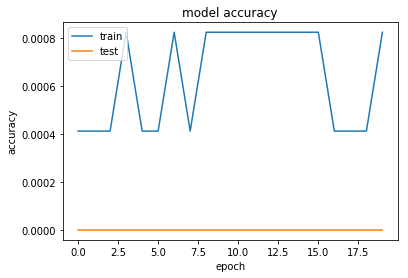

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       268   7           119342.5625  106928.58125


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3636 samples, validate on 18 samples
Epoch 1/20
3636/3636 [==============================] - 0s 102us/step - loss: 0.1055 - acc: 2.7503e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 2/20
3636/3636 [==============================] - 0s 45us/step - loss: 0.0532 - acc: 2.7503e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/20
3636/3636 [==============================] - 0s 39us/step - 

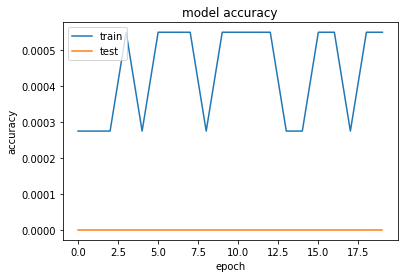

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       268   8            286412.875  299436.615509


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6090 samples, validate on 30 samples
Epoch 1/20
6090/6090 [==============================] - 0s 79us/step - loss: 0.0761 - acc: 1.6420e-04 - val_loss: 4.7160e-04 - val_acc: 0.0000e+00
Epoch 2/20
6090/6090 [==============================] - 0s 44us/step - loss: 0.0212 - acc: 3.2841e-04 - val_loss: 1.8933e-04 - val_acc: 0.0000e+00
Epoch 3/20
6090/6090 [==============================] - 0s 40us/

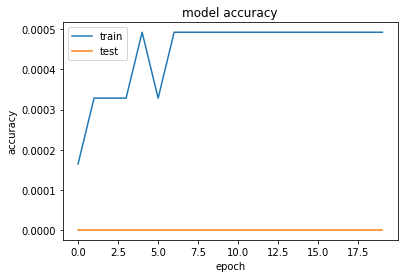

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       269   4          342104.15625  285367.192979


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6090 samples, validate on 30 samples
Epoch 1/20
6090/6090 [==============================] - 0s 78us/step - loss: 0.3159 - acc: 4.9261e-04 - val_loss: 0.0421 - val_acc: 0.0000e+00
Epoch 2/20
6090/6090 [==============================] - 0s 42us/step - loss: 0.0332 - acc: 6.5681e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 3/20
6090/6090 [==============================] - 0s 39us/step - l

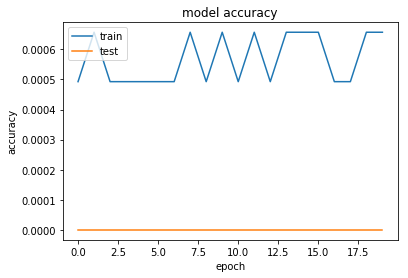

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       269   5            270903.625  223340.860889


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2436 samples, validate on 12 samples
Epoch 1/20
2436/2436 [==============================] - 0s 139us/step - loss: 0.1414 - acc: 4.1051e-04 - val_loss: 0.0365 - val_acc: 0.0000e+00
Epoch 2/20
2436/2436 [==============================] - 0s 41us/step - loss: 0.0827 - acc: 4.1051e-04 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 3/20
2436/2436 [==============================] - 0s 44us/step - 

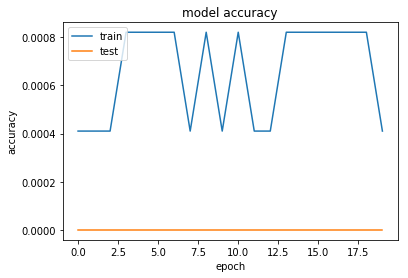

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       269   7         130778.554688  120349.780634


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3654 samples, validate on 18 samples
Epoch 1/20
3654/3654 [==============================] - 0s 96us/step - loss: 0.1303 - acc: 2.7367e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 2/20
3654/3654 [==============================] - 0s 47us/step - loss: 0.0643 - acc: 5.4735e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 3/20
3654/3654 [==============================] - 0s 44us/step - l

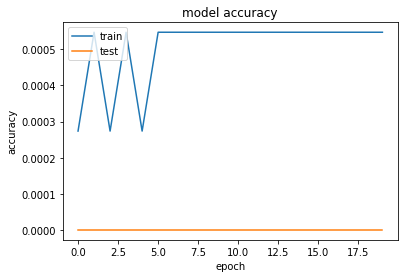

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       269   8           305981.5625  309834.589306


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6120 samples, validate on 30 samples
Epoch 1/20
6120/6120 [==============================] - 0s 74us/step - loss: 0.0689 - acc: 3.2680e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 2/20
6120/6120 [==============================] - 0s 42us/step - loss: 0.0195 - acc: 3.2680e-04 - val_loss: 5.2875e-04 - val_acc: 0.0000e+00
Epoch 3/20
6120/6120 [==============================] - 0s 41us/step

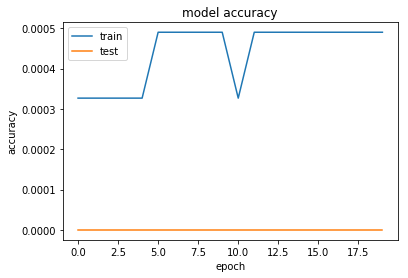

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       270   4          373912.09375  279059.663898


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6120 samples, validate on 30 samples
Epoch 1/20
6120/6120 [==============================] - 0s 76us/step - loss: 0.0689 - acc: 3.2680e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/20
6120/6120 [==============================] - 0s 42us/step - loss: 0.0200 - acc: 4.9020e-04 - val_loss: 4.8341e-04 - val_acc: 0.0000e+00
Epoch 3/20
6120/6120 [==============================] - 0s 39us/step

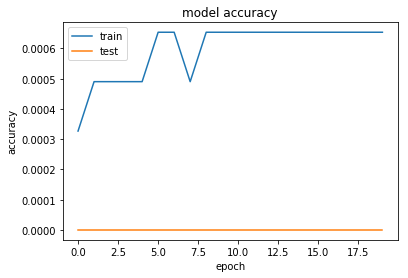

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       270   5         253769.046875  223096.094056


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2448 samples, validate on 12 samples
Epoch 1/20
2448/2448 [==============================] - 0s 135us/step - loss: 0.2832 - acc: 8.1699e-04 - val_loss: 0.0383 - val_acc: 0.0000e+00
Epoch 2/20
2448/2448 [==============================] - 0s 48us/step - loss: 0.1222 - acc: 8.1699e-04 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 3/20
2448/2448 [==============================] - 0s 42us/step - 

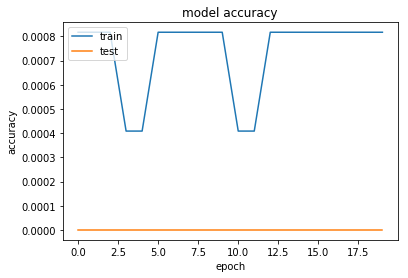

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       270   7          141068.71875  131711.425139


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3672 samples, validate on 18 samples
Epoch 1/20
3672/3672 [==============================] - 0s 100us/step - loss: 0.1279 - acc: 2.7233e-04 - val_loss: 0.0106 - val_acc: 0.0000e+00
Epoch 2/20
3672/3672 [==============================] - 0s 46us/step - loss: 0.0600 - acc: 2.7233e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 3/20
3672/3672 [==============================] - 0s 38us/step - 

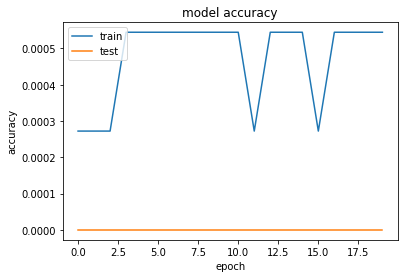

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       270   8             342245.25  327869.973091


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6150 samples, validate on 30 samples
Epoch 1/20
6150/6150 [==============================] - 0s 77us/step - loss: 0.1339 - acc: 3.2520e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 2/20
6150/6150 [==============================] - 0s 45us/step - loss: 0.0328 - acc: 3.2520e-04 - val_loss: 7.3273e-04 - val_acc: 0.0000e+00
Epoch 3/20
6150/6150 [==============================] - 0s 41us/step

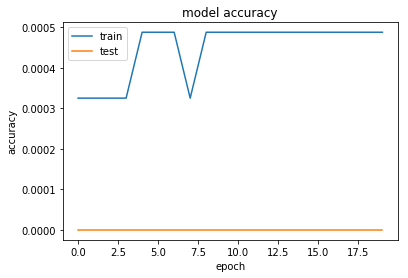

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       271   4          362605.96875  325965.100472


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6150 samples, validate on 30 samples
Epoch 1/20
6150/6150 [==============================] - 0s 74us/step - loss: 0.0639 - acc: 4.8780e-04 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 2/20
6150/6150 [==============================] - 0s 43us/step - loss: 0.0178 - acc: 4.8780e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 3/20
6150/6150 [==============================] - 0s 38us/step - l

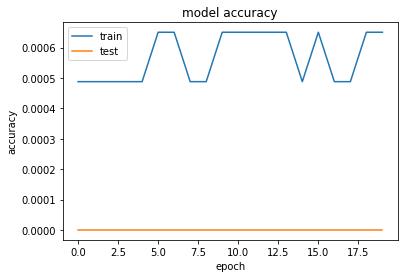

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       271   5           243587.1875  224715.884231


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2460 samples, validate on 12 samples
Epoch 1/20
2460/2460 [==============================] - 0s 125us/step - loss: 0.1954 - acc: 4.0650e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 2/20
2460/2460 [==============================] - 0s 44us/step - loss: 0.1114 - acc: 4.0650e-04 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 3/20
2460/2460 [==============================] - 0s 41us/step - 

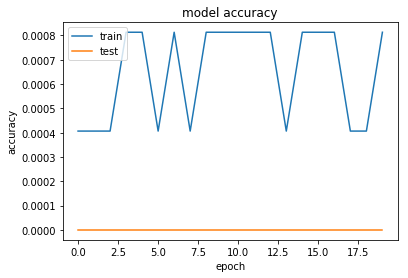

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       271   7         163535.265625  155033.612805


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3690 samples, validate on 18 samples
Epoch 1/20
3690/3690 [==============================] - 0s 93us/step - loss: 0.1516 - acc: 2.7100e-04 - val_loss: 0.0193 - val_acc: 0.0000e+00
Epoch 2/20
3690/3690 [==============================] - 0s 45us/step - loss: 0.0750 - acc: 2.7100e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 3/20
3690/3690 [==============================] - 0s 37us/step - l

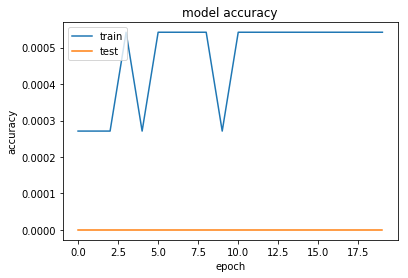

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       271   8           359801.6875  376927.011605


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6180 samples, validate on 30 samples
Epoch 1/20
6180/6180 [==============================] - 0s 79us/step - loss: 0.1554 - acc: 3.2362e-04 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 2/20
6180/6180 [==============================] - 0s 40us/step - loss: 0.0449 - acc: 3.2362e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 3/20
6180/6180 [==============================] - 0s 37us/step - l

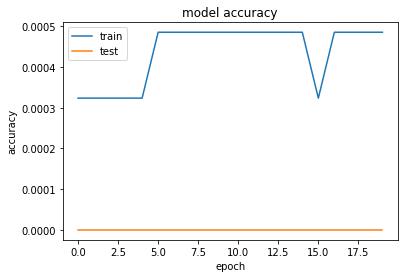

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       272   4          407761.40625  436941.402153


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6180 samples, validate on 30 samples
Epoch 1/20
6180/6180 [==============================] - 0s 74us/step - loss: 0.1411 - acc: 4.8544e-04 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 2/20
6180/6180 [==============================] - 0s 41us/step - loss: 0.0374 - acc: 4.8544e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/20
6180/6180 [==============================] - 0s 37us/step - l

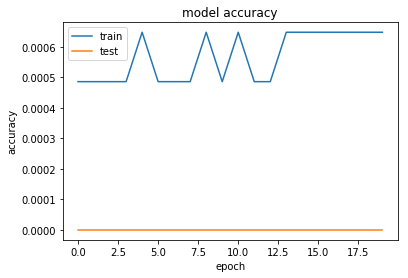

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       272   5           263408.1875  271556.376686


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2472 samples, validate on 12 samples
Epoch 1/20
2472/2472 [==============================] - 0s 137us/step - loss: 0.5279 - acc: 4.0453e-04 - val_loss: 0.1355 - val_acc: 0.0000e+00
Epoch 2/20
2472/2472 [==============================] - 0s 41us/step - loss: 0.2009 - acc: 4.0453e-04 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 3/20
2472/2472 [==============================] - 0s 45us/step - 

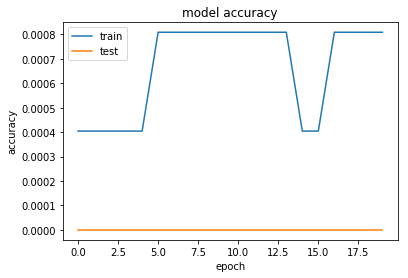

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       272   7          185589.53125  203898.356216


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3708 samples, validate on 18 samples
Epoch 1/20
3708/3708 [==============================] - 0s 102us/step - loss: 0.3390 - acc: 5.3937e-04 - val_loss: 0.0361 - val_acc: 0.0000e+00
Epoch 2/20
3708/3708 [==============================] - 0s 43us/step - loss: 0.1004 - acc: 5.3937e-04 - val_loss: 0.0229 - val_acc: 0.0000e+00
Epoch 3/20
3708/3708 [==============================] - 0s 38us/step - 

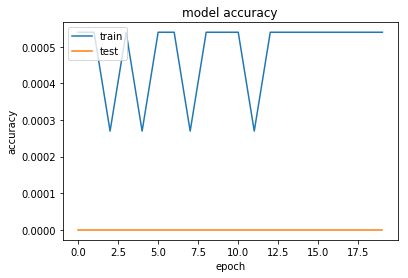

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       272   8          407811.78125  523196.053171


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6210 samples, validate on 30 samples
Epoch 1/20
6210/6210 [==============================] - 0s 71us/step - loss: 0.0680 - acc: 4.8309e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 2/20
6210/6210 [==============================] - 0s 43us/step - loss: 0.0197 - acc: 3.2206e-04 - val_loss: 6.6981e-04 - val_acc: 0.0000e+00
Epoch 3/20
6210/6210 [==============================] - 0s 38us/step

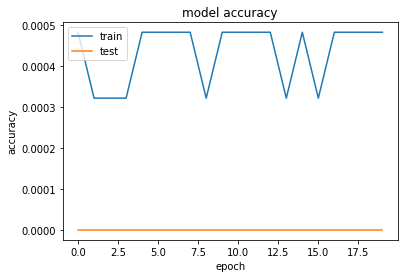

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       273   4             427887.25  387243.481075


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6210 samples, validate on 30 samples
Epoch 1/20
6210/6210 [==============================] - 0s 75us/step - loss: 0.0889 - acc: 4.8309e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 2/20
6210/6210 [==============================] - 0s 42us/step - loss: 0.0245 - acc: 4.8309e-04 - val_loss: 8.0020e-04 - val_acc: 0.0000e+00
Epoch 3/20
6210/6210 [==============================] - 0s 38us/step

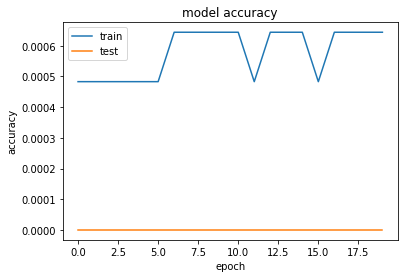

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       273   5           269193.3125  262571.112305


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2484 samples, validate on 12 samples
Epoch 1/20
2484/2484 [==============================] - 0s 123us/step - loss: 0.2150 - acc: 8.0515e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 2/20
2484/2484 [==============================] - 0s 42us/step - loss: 0.1028 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 3/20
2484/2484 [==============================] - 0s 43us/step - 

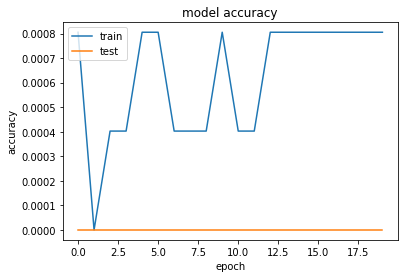

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       273   7           232212.0625  185443.659571


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3726 samples, validate on 18 samples
Epoch 1/20
3726/3726 [==============================] - 0s 105us/step - loss: 0.2494 - acc: 2.6838e-04 - val_loss: 0.0638 - val_acc: 0.0000e+00
Epoch 2/20
3726/3726 [==============================] - 0s 46us/step - loss: 0.0475 - acc: 2.6838e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 3/20
3726/3726 [==============================] - 0s 40us/step - 

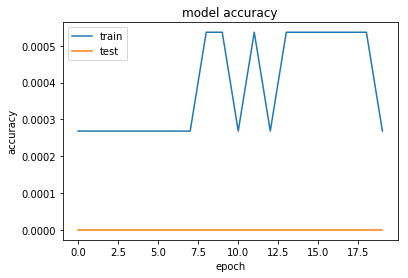

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       273   8          432600.28125  455737.408706


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6240 samples, validate on 30 samples
Epoch 1/20
6240/6240 [==============================] - 0s 76us/step - loss: 0.0776 - acc: 3.2051e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 2/20
6240/6240 [==============================] - 0s 41us/step - loss: 0.0205 - acc: 3.2051e-04 - val_loss: 9.2452e-04 - val_acc: 0.0000e+00
Epoch 3/20
6240/6240 [==============================] - 0s 39us/step

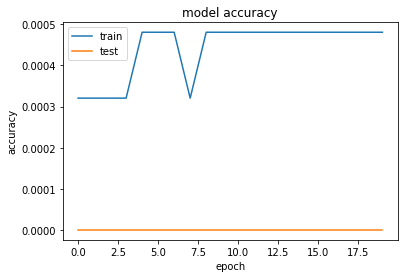

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       274   4           572320.0625  436907.90216


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6240 samples, validate on 30 samples
Epoch 1/20
6240/6240 [==============================] - 1s 82us/step - loss: 0.1936 - acc: 6.4103e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 2/20
6240/6240 [==============================] - 0s 44us/step - loss: 0.0384 - acc: 4.8077e-04 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 3/20
6240/6240 [==============================] - 0s 41us/step - l

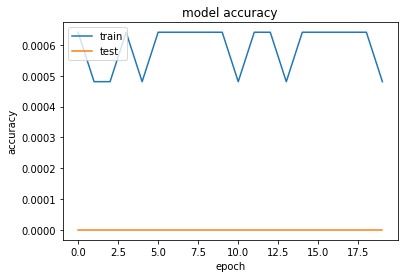

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       274   5           312757.3125  281927.882323


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2496 samples, validate on 12 samples
Epoch 1/20
2496/2496 [==============================] - 0s 149us/step - loss: 0.1419 - acc: 8.0128e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 2/20
2496/2496 [==============================] - 0s 45us/step - loss: 0.0842 - acc: 4.0064e-04 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 3/20
2496/2496 [==============================] - 0s 39us/step - 

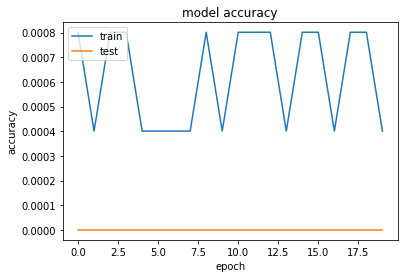

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       274   7         230408.671875  183162.91506


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3744 samples, validate on 18 samples
Epoch 1/20
3744/3744 [==============================] - 0s 102us/step - loss: 0.1043 - acc: 2.6709e-04 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 2/20
3744/3744 [==============================] - 0s 40us/step - loss: 0.0427 - acc: 2.6709e-04 - val_loss: 0.0118 - val_acc: 0.0000e+00
Epoch 3/20
3744/3744 [==============================] - 0s 39us/step - 

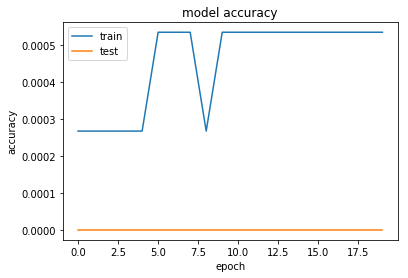

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       274   8             570118.25  477262.025744


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6270 samples, validate on 30 samples
Epoch 1/20
6270/6270 [==============================] - 0s 77us/step - loss: 0.0671 - acc: 3.1898e-04 - val_loss: 8.0301e-04 - val_acc: 0.0000e+00
Epoch 2/20
6270/6270 [==============================] - 0s 42us/step - loss: 0.0185 - acc: 3.1898e-04 - val_loss: 5.5342e-04 - val_acc: 0.0000e+00
Epoch 3/20
6270/6270 [==============================] - 0s 41us/

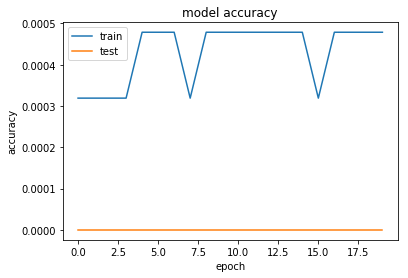

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       275   4            625172.625  451324.449054


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6270 samples, validate on 30 samples
Epoch 1/20
6270/6270 [==============================] - 0s 78us/step - loss: 0.0777 - acc: 4.7847e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/20
6270/6270 [==============================] - 0s 44us/step - loss: 0.0239 - acc: 4.7847e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/20
6270/6270 [==============================] - 0s 38us/step - l

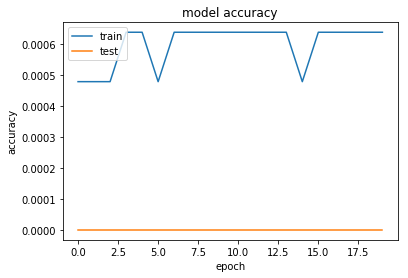

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       275   5           306862.0625  270691.441811


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2508 samples, validate on 12 samples
Epoch 1/20
2508/2508 [==============================] - 0s 129us/step - loss: 0.2457 - acc: 0.0000e+00 - val_loss: 0.0985 - val_acc: 0.0000e+00
Epoch 2/20
2508/2508 [==============================] - 0s 49us/step - loss: 0.0897 - acc: 7.9745e-04 - val_loss: 0.0442 - val_acc: 0.0000e+00
Epoch 3/20
2508/2508 [==============================] - 0s 39us/step - 

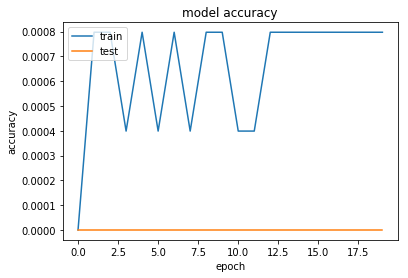

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       275   7          278292.84375  200586.393677


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3762 samples, validate on 18 samples
Epoch 1/20
3762/3762 [==============================] - 0s 101us/step - loss: 0.0691 - acc: 5.3163e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 2/20
3762/3762 [==============================] - 0s 42us/step - loss: 0.0343 - acc: 5.3163e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 3/20
3762/3762 [==============================] - 0s 39us/step - 

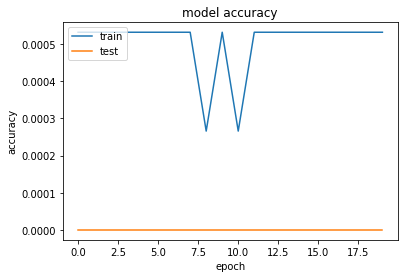

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       275   8            644652.625  481875.326907


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6300 samples, validate on 30 samples
Epoch 1/20
6300/6300 [==============================] - 0s 73us/step - loss: 0.0916 - acc: 1.5873e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 2/20
6300/6300 [==============================] - 0s 40us/step - loss: 0.0214 - acc: 3.1746e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/20
6300/6300 [==============================] - 0s 38us/step - l

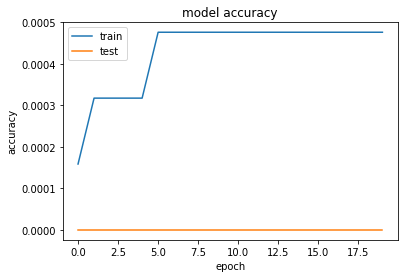

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       276   4             721271.75  622216.48948


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6300 samples, validate on 30 samples
Epoch 1/20
6300/6300 [==============================] - 0s 73us/step - loss: 0.4534 - acc: 4.7619e-04 - val_loss: 0.1219 - val_acc: 0.0000e+00
Epoch 2/20
6300/6300 [==============================] - 0s 45us/step - loss: 0.0396 - acc: 4.7619e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 3/20
6300/6300 [==============================] - 0s 40us/step - l

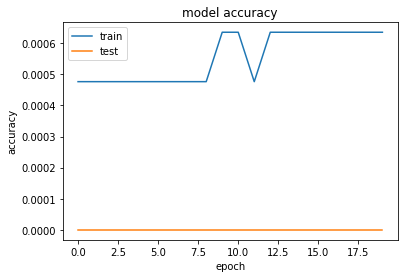

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       276   5          363023.84375  329091.692914


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2520 samples, validate on 12 samples
Epoch 1/20
2520/2520 [==============================] - 0s 138us/step - loss: 0.1279 - acc: 3.9683e-04 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 2/20
2520/2520 [==============================] - 0s 46us/step - loss: 0.0766 - acc: 3.9683e-04 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 3/20
2520/2520 [==============================] - 0s 39us/step - 

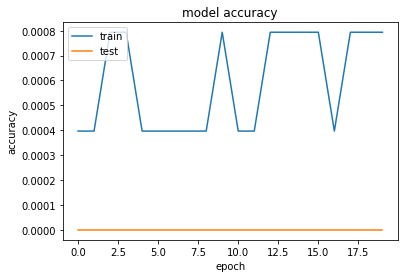

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       276   7          257589.46875  284740.341922


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3780 samples, validate on 18 samples
Epoch 1/20
3780/3780 [==============================] - 0s 103us/step - loss: 0.8896 - acc: 2.6455e-04 - val_loss: 0.2614 - val_acc: 0.0000e+00
Epoch 2/20
3780/3780 [==============================] - 0s 40us/step - loss: 0.1722 - acc: 2.6455e-04 - val_loss: 0.0715 - val_acc: 0.0000e+00
Epoch 3/20
3780/3780 [==============================] - 0s 41us/step - 

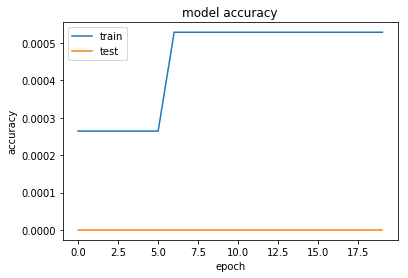

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       276   8           743832.6875  636282.798047


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6330 samples, validate on 30 samples
Epoch 1/20
6330/6330 [==============================] - 0s 76us/step - loss: 0.2056 - acc: 1.5798e-04 - val_loss: 0.0175 - val_acc: 0.0000e+00
Epoch 2/20
6330/6330 [==============================] - 0s 45us/step - loss: 0.0337 - acc: 1.5798e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 3/20
6330/6330 [==============================] - 0s 41us/step - l

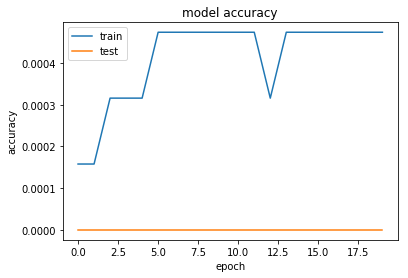

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       277   4           723964.3125  707656.075355


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6330 samples, validate on 30 samples
Epoch 1/20
6330/6330 [==============================] - 0s 76us/step - loss: 0.1118 - acc: 4.7393e-04 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 2/20
6330/6330 [==============================] - 0s 43us/step - loss: 0.0298 - acc: 4.7393e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 3/20
6330/6330 [==============================] - 0s 38us/step - l

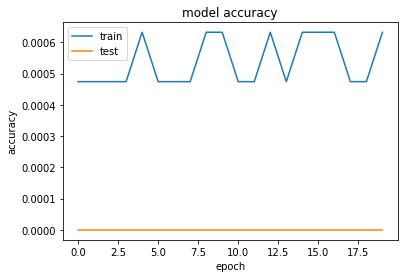

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       277   5           349062.9375  372109.458255


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2532 samples, validate on 12 samples
Epoch 1/20
2532/2532 [==============================] - 0s 139us/step - loss: 0.1523 - acc: 3.9494e-04 - val_loss: 0.0774 - val_acc: 0.0000e+00
Epoch 2/20
2532/2532 [==============================] - 0s 45us/step - loss: 0.0885 - acc: 3.9494e-04 - val_loss: 0.0594 - val_acc: 0.0000e+00
Epoch 3/20
2532/2532 [==============================] - 0s 41us/step - 

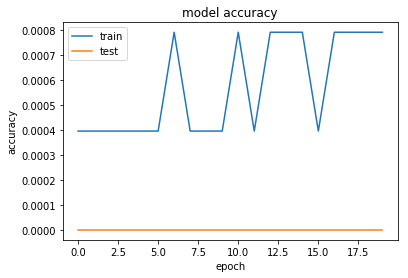

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       277   7           264014.5625  359850.602457


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3798 samples, validate on 18 samples
Epoch 1/20
3798/3798 [==============================] - 0s 94us/step - loss: 0.0938 - acc: 2.6330e-04 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 2/20
3798/3798 [==============================] - 0s 43us/step - loss: 0.0451 - acc: 2.6330e-04 - val_loss: 0.0195 - val_acc: 0.0000e+00
Epoch 3/20
3798/3798 [==============================] - 0s 41us/step - l

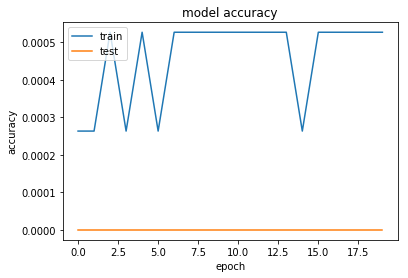

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       277   8             669871.25  701825.229913


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6360 samples, validate on 30 samples
Epoch 1/20
6360/6360 [==============================] - 0s 74us/step - loss: 0.4051 - acc: 3.1447e-04 - val_loss: 0.0902 - val_acc: 0.0000e+00
Epoch 2/20
6360/6360 [==============================] - 0s 39us/step - loss: 0.0319 - acc: 3.1447e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 3/20
6360/6360 [==============================] - 0s 38us/step - l

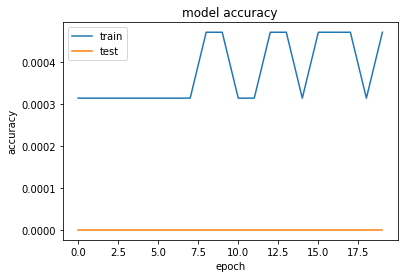

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       278   4            663620.375  850222.924488


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6360 samples, validate on 30 samples
Epoch 1/20
6360/6360 [==============================] - 0s 77us/step - loss: 0.2704 - acc: 4.7170e-04 - val_loss: 0.0330 - val_acc: 0.0000e+00
Epoch 2/20
6360/6360 [==============================] - 0s 43us/step - loss: 0.0462 - acc: 4.7170e-04 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 3/20
6360/6360 [==============================] - 0s 39us/step - l

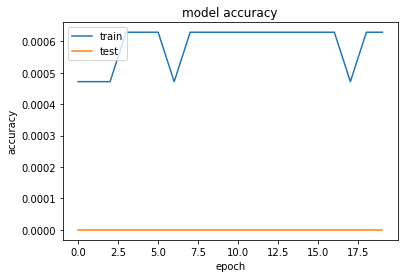

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       278   5          376968.28125  408827.14213


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2544 samples, validate on 12 samples
Epoch 1/20
2544/2544 [==============================] - 0s 122us/step - loss: 0.8268 - acc: 3.9308e-04 - val_loss: 0.9718 - val_acc: 0.0000e+00
Epoch 2/20
2544/2544 [==============================] - 0s 51us/step - loss: 0.4628 - acc: 3.9308e-04 - val_loss: 0.5579 - val_acc: 0.0000e+00
Epoch 3/20
2544/2544 [==============================] - 0s 40us/step - 

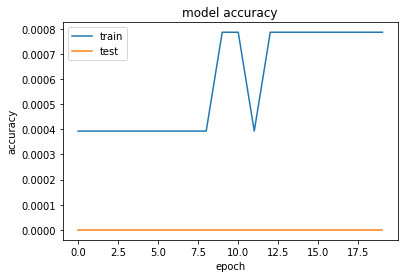

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       278   7          298355.09375  380856.965497


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3816 samples, validate on 18 samples
Epoch 1/20
3816/3816 [==============================] - 0s 101us/step - loss: 0.3169 - acc: 0.0000e+00 - val_loss: 0.0916 - val_acc: 0.0000e+00
Epoch 2/20
3816/3816 [==============================] - 0s 46us/step - loss: 0.0608 - acc: 2.6205e-04 - val_loss: 0.0781 - val_acc: 0.0000e+00
Epoch 3/20
3816/3816 [==============================] - 0s 45us/step - 

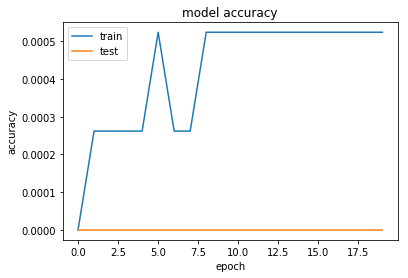

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       278   8           714136.9375  785193.878093


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6390 samples, validate on 30 samples
Epoch 1/20
6390/6390 [==============================] - 0s 77us/step - loss: 0.5249 - acc: 1.5649e-04 - val_loss: 0.0481 - val_acc: 0.0000e+00
Epoch 2/20
6390/6390 [==============================] - 0s 42us/step - loss: 0.0616 - acc: 3.1299e-04 - val_loss: 0.0215 - val_acc: 0.0000e+00
Epoch 3/20
6390/6390 [==============================] - 0s 40us/step - l

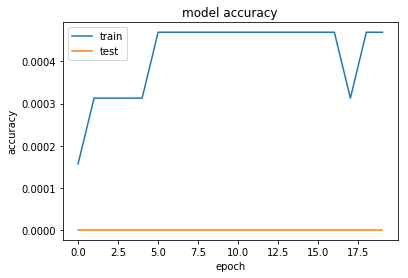

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       279   4           708769.4375  965643.135134


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6390 samples, validate on 30 samples
Epoch 1/20
6390/6390 [==============================] - 0s 71us/step - loss: 0.1644 - acc: 4.6948e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 2/20
6390/6390 [==============================] - 0s 43us/step - loss: 0.0445 - acc: 4.6948e-04 - val_loss: 0.0096 - val_acc: 0.0000e+00
Epoch 3/20
6390/6390 [==============================] - 0s 38us/step - l

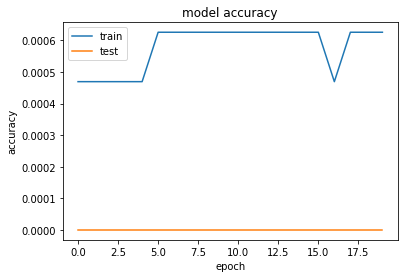

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       279   5           353340.5625  460718.925336


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2556 samples, validate on 12 samples
Epoch 1/20
2556/2556 [==============================] - 0s 133us/step - loss: 0.0876 - acc: 3.9124e-04 - val_loss: 0.1190 - val_acc: 0.0000e+00
Epoch 2/20
2556/2556 [==============================] - 0s 48us/step - loss: 0.0535 - acc: 0.0000e+00 - val_loss: 0.0912 - val_acc: 0.0000e+00
Epoch 3/20
2556/2556 [==============================] - 0s 38us/step - 

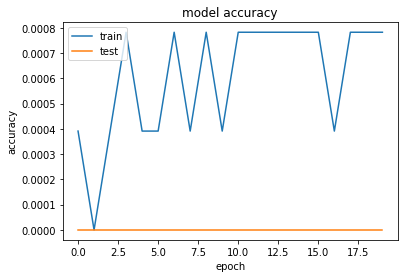

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       279   7          303735.71875  417660.815299


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3834 samples, validate on 18 samples
Epoch 1/20
3834/3834 [==============================] - 0s 96us/step - loss: 0.1814 - acc: 2.6082e-04 - val_loss: 0.0486 - val_acc: 0.0000e+00
Epoch 2/20
3834/3834 [==============================] - 0s 43us/step - loss: 0.0891 - acc: 2.6082e-04 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 3/20
3834/3834 [==============================] - 0s 40us/step - l

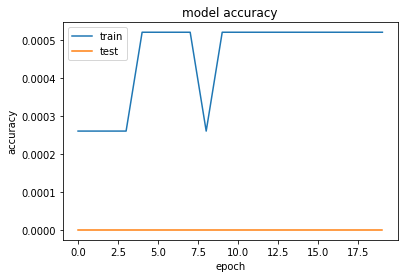

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       279   8           643625.3125  888502.355793


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6420 samples, validate on 30 samples
Epoch 1/20
6420/6420 [==============================] - 0s 75us/step - loss: 0.1122 - acc: 4.6729e-04 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 2/20
6420/6420 [==============================] - 0s 45us/step - loss: 0.0311 - acc: 3.1153e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 3/20
6420/6420 [==============================] - 0s 40us/step - l

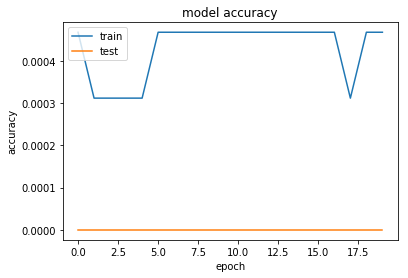

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       280   4             761528.25  974101.711253


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6420 samples, validate on 30 samples
Epoch 1/20
6420/6420 [==============================] - 0s 74us/step - loss: 0.1021 - acc: 3.1153e-04 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 2/20
6420/6420 [==============================] - 0s 43us/step - loss: 0.0260 - acc: 4.6729e-04 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 3/20
6420/6420 [==============================] - 0s 40us/step - l

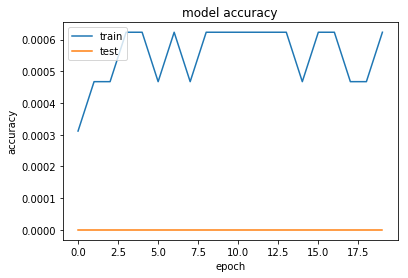

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       280   5          397355.90625  473962.081127


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2568 samples, validate on 12 samples
Epoch 1/20
2568/2568 [==============================] - 0s 125us/step - loss: 0.1115 - acc: 3.8941e-04 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 2/20
2568/2568 [==============================] - 0s 45us/step - loss: 0.0708 - acc: 0.0000e+00 - val_loss: 0.0461 - val_acc: 0.0000e+00
Epoch 3/20
2568/2568 [==============================] - 0s 39us/step - 

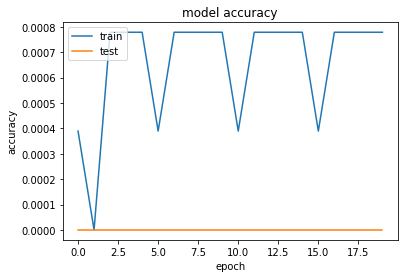

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       280   7           352578.6875  408997.39497


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3852 samples, validate on 18 samples
Epoch 1/20
3852/3852 [==============================] - 0s 92us/step - loss: 0.1524 - acc: 0.0000e+00 - val_loss: 0.0511 - val_acc: 0.0000e+00
Epoch 2/20
3852/3852 [==============================] - 0s 45us/step - loss: 0.0682 - acc: 2.5961e-04 - val_loss: 0.0356 - val_acc: 0.0000e+00
Epoch 3/20
3852/3852 [==============================] - 0s 38us/step - l

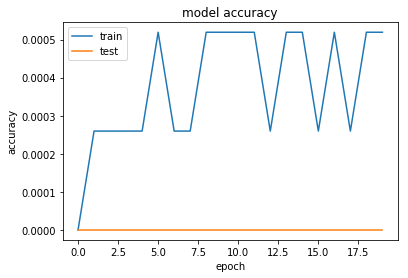

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       280   8             709755.75  911188.576692


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6450 samples, validate on 30 samples
Epoch 1/20
6450/6450 [==============================] - 0s 73us/step - loss: 0.0822 - acc: 3.1008e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 2/20
6450/6450 [==============================] - 0s 43us/step - loss: 0.0215 - acc: 3.1008e-04 - val_loss: 0.0091 - val_acc: 0.0000e+00
Epoch 3/20
6450/6450 [==============================] - 0s 41us/step - l

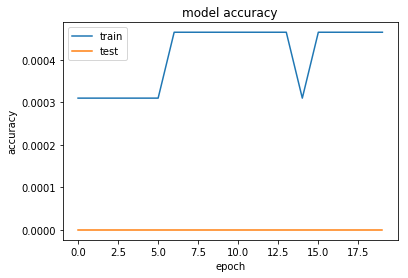

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       281   4            831367.375  916409.057869


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6450 samples, validate on 30 samples
Epoch 1/20
6450/6450 [==============================] - 0s 70us/step - loss: 0.1790 - acc: 4.6512e-04 - val_loss: 0.0246 - val_acc: 0.0000e+00
Epoch 2/20
6450/6450 [==============================] - 0s 42us/step - loss: 0.0497 - acc: 4.6512e-04 - val_loss: 0.0116 - val_acc: 0.0000e+00
Epoch 3/20
6450/6450 [==============================] - 0s 37us/step - l

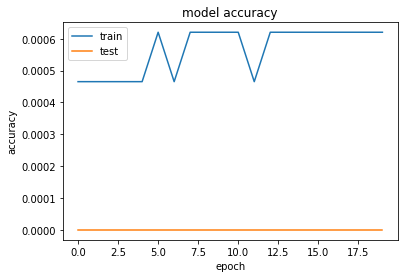

   testWeek  DC  Nplus2CUBEPrediction   Nplus2CUBE
0       281   5          411040.90625  461435.6416


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2580 samples, validate on 12 samples
Epoch 1/20
2580/2580 [==============================] - 0s 129us/step - loss: 0.2967 - acc: 3.8760e-04 - val_loss: 0.1302 - val_acc: 0.0000e+00
Epoch 2/20
2580/2580 [==============================] - 0s 52us/step - loss: 0.0990 - acc: 3.8760e-04 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 3/20
2580/2580 [==============================] - 0s 39us/step - 

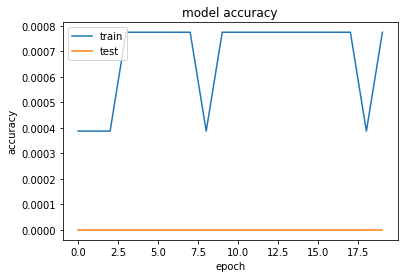

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       281   7           329914.0625  363149.006767


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3870 samples, validate on 18 samples
Epoch 1/20
3870/3870 [==============================] - 0s 98us/step - loss: 0.1503 - acc: 2.5840e-04 - val_loss: 0.0221 - val_acc: 0.0000e+00
Epoch 2/20
3870/3870 [==============================] - 0s 42us/step - loss: 0.0692 - acc: 2.5840e-04 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 3/20
3870/3870 [==============================] - 0s 38us/step - l

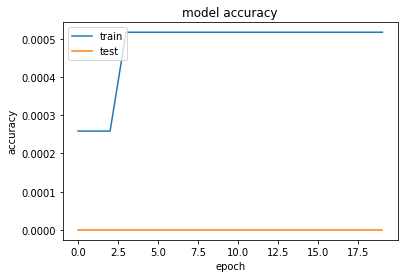

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       281   8              688197.5  713701.498502


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6480 samples, validate on 30 samples
Epoch 1/20
6480/6480 [==============================] - 0s 70us/step - loss: 0.1464 - acc: 3.0864e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 2/20
6480/6480 [==============================] - 0s 44us/step - loss: 0.0418 - acc: 3.0864e-04 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 3/20
6480/6480 [==============================] - 0s 38us/step - l

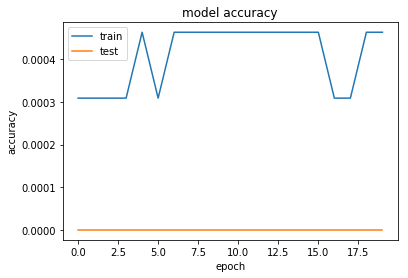

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       282   4            779781.125  845764.88058


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6480 samples, validate on 30 samples
Epoch 1/20
6480/6480 [==============================] - 0s 72us/step - loss: 0.1231 - acc: 4.6296e-04 - val_loss: 0.0325 - val_acc: 0.0000e+00
Epoch 2/20
6480/6480 [==============================] - 0s 41us/step - loss: 0.0238 - acc: 4.6296e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 3/20
6480/6480 [==============================] - 0s 38us/step - l

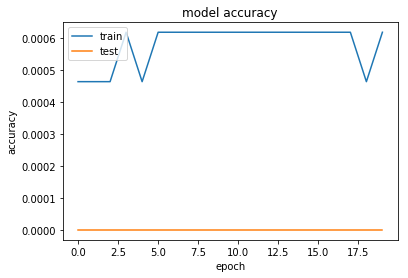

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       282   5          404273.15625  453603.536128


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2592 samples, validate on 12 samples
Epoch 1/20
2592/2592 [==============================] - 0s 128us/step - loss: 0.1608 - acc: 3.8580e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 2/20
2592/2592 [==============================] - 0s 46us/step - loss: 0.0863 - acc: 3.8580e-04 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 3/20
2592/2592 [==============================] - 0s 39us/step - 

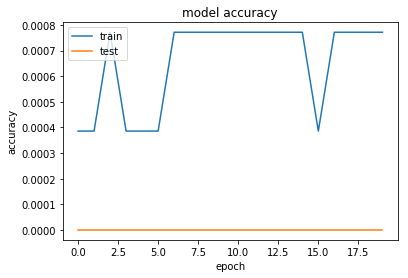

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       282   7           314571.9375  266395.134126


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3888 samples, validate on 18 samples
Epoch 1/20
3888/3888 [==============================] - 0s 96us/step - loss: 0.1181 - acc: 5.1440e-04 - val_loss: 0.0138 - val_acc: 0.0000e+00
Epoch 2/20
3888/3888 [==============================] - 0s 46us/step - loss: 0.0527 - acc: 2.5720e-04 - val_loss: 0.0149 - val_acc: 0.0000e+00
Epoch 3/20
3888/3888 [==============================] - 0s 39us/step - l

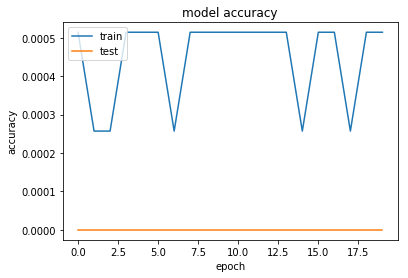

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       282   8           710962.6875  711175.011906


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6510 samples, validate on 30 samples
Epoch 1/20
6510/6510 [==============================] - 0s 73us/step - loss: 0.2208 - acc: 3.0722e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/20
6510/6510 [==============================] - 0s 42us/step - loss: 0.0441 - acc: 4.6083e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/20
6510/6510 [==============================] - 0s 41us/step - l

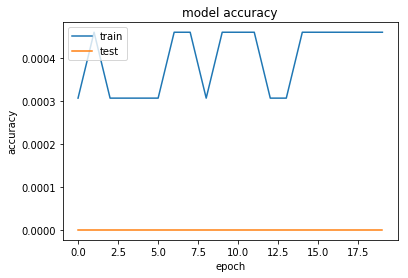

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       283   4           742678.3125  790355.736839


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6510 samples, validate on 30 samples
Epoch 1/20
6510/6510 [==============================] - 1s 78us/step - loss: 0.0722 - acc: 4.6083e-04 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 2/20
6510/6510 [==============================] - 0s 44us/step - loss: 0.0192 - acc: 4.6083e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 3/20
6510/6510 [==============================] - 0s 41us/step - l

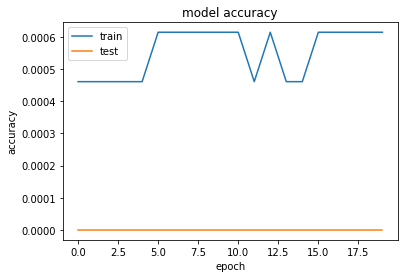

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       283   5           417913.0625  407284.391739


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2604 samples, validate on 12 samples
Epoch 1/20
2604/2604 [==============================] - 0s 121us/step - loss: 0.1820 - acc: 7.6805e-04 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 2/20
2604/2604 [==============================] - 0s 45us/step - loss: 0.1033 - acc: 3.8402e-04 - val_loss: 0.0179 - val_acc: 0.0000e+00
Epoch 3/20
2604/2604 [==============================] - 0s 41us/step - 

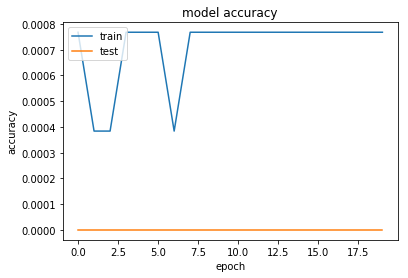

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       283   7          331218.09375  305048.629812


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3906 samples, validate on 18 samples
Epoch 1/20
3906/3906 [==============================] - 0s 95us/step - loss: 0.2695 - acc: 2.5602e-04 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 2/20
3906/3906 [==============================] - 0s 39us/step - loss: 0.0641 - acc: 2.5602e-04 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 3/20
3906/3906 [==============================] - 0s 40us/step - l

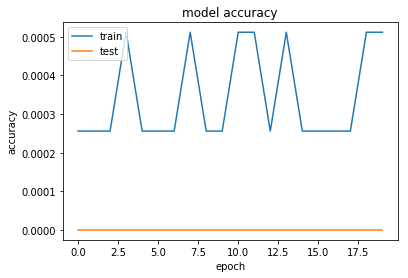

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       283   8            640839.375  721591.215699


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6540 samples, validate on 30 samples
Epoch 1/20
6540/6540 [==============================] - 1s 77us/step - loss: 0.1917 - acc: 3.0581e-04 - val_loss: 0.0266 - val_acc: 0.0000e+00
Epoch 2/20
6540/6540 [==============================] - 0s 40us/step - loss: 0.0279 - acc: 3.0581e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 3/20
6540/6540 [==============================] - 0s 40us/step - l

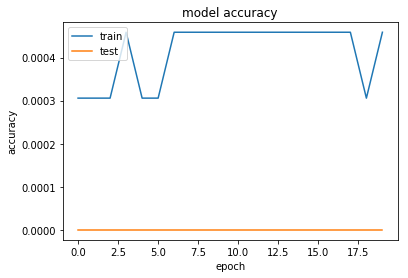

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       284   4            698376.625  711532.018466


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6540 samples, validate on 30 samples
Epoch 1/20
6540/6540 [==============================] - 0s 76us/step - loss: 0.0793 - acc: 4.5872e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 2/20
6540/6540 [==============================] - 0s 42us/step - loss: 0.0219 - acc: 4.5872e-04 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 3/20
6540/6540 [==============================] - 0s 39us/step - l

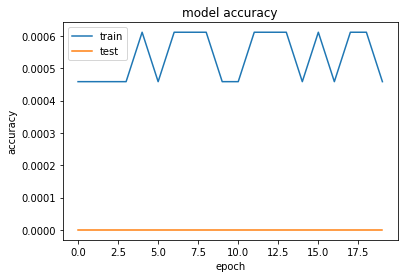

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       284   5           408369.3125  393592.287872


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2616 samples, validate on 12 samples
Epoch 1/20
2616/2616 [==============================] - 0s 115us/step - loss: 0.1202 - acc: 7.6453e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 2/20
2616/2616 [==============================] - 0s 53us/step - loss: 0.0726 - acc: 3.8226e-04 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 3/20
2616/2616 [==============================] - 0s 43us/step - 

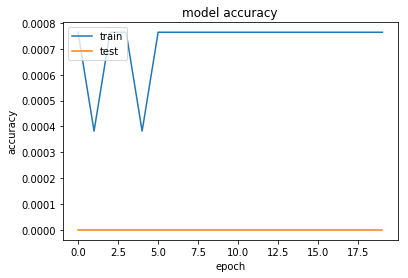

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       284   7          262983.96875  293047.585142


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3924 samples, validate on 18 samples
Epoch 1/20
3924/3924 [==============================] - 0s 103us/step - loss: 0.1240 - acc: 2.5484e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 2/20
3924/3924 [==============================] - 0s 44us/step - loss: 0.0585 - acc: 5.0968e-04 - val_loss: 0.0200 - val_acc: 0.0000e+00
Epoch 3/20
3924/3924 [==============================] - 0s 43us/step - 

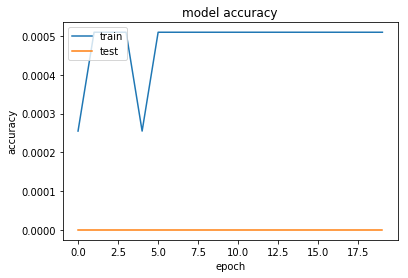

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       284   8           649533.4375  729684.565672


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6570 samples, validate on 30 samples
Epoch 1/20
6570/6570 [==============================] - 0s 75us/step - loss: 0.3108 - acc: 3.0441e-04 - val_loss: 0.0096 - val_acc: 0.0000e+00
Epoch 2/20
6570/6570 [==============================] - 0s 42us/step - loss: 0.0258 - acc: 3.0441e-04 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 3/20
6570/6570 [==============================] - 0s 37us/step - l

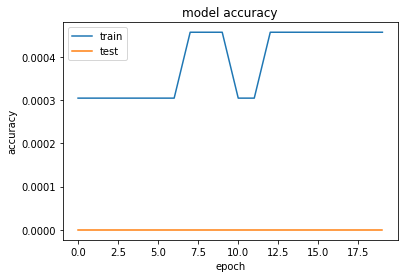

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       285   4             627433.75  698657.460392


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6570 samples, validate on 30 samples
Epoch 1/20
6570/6570 [==============================] - 0s 75us/step - loss: 0.1234 - acc: 4.5662e-04 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 2/20
6570/6570 [==============================] - 0s 43us/step - loss: 0.0361 - acc: 4.5662e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 3/20
6570/6570 [==============================] - 0s 38us/step - l

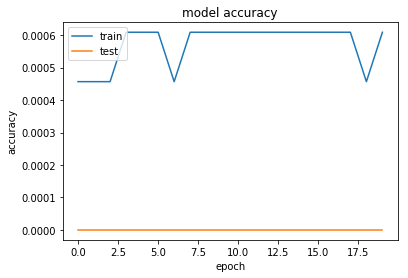

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       285   5           363382.1875  393634.462332


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2628 samples, validate on 12 samples
Epoch 1/20
2628/2628 [==============================] - 0s 144us/step - loss: 0.2134 - acc: 7.6104e-04 - val_loss: 0.0734 - val_acc: 0.0000e+00
Epoch 2/20
2628/2628 [==============================] - 0s 48us/step - loss: 0.1094 - acc: 3.8052e-04 - val_loss: 0.0505 - val_acc: 0.0000e+00
Epoch 3/20
2628/2628 [==============================] - 0s 47us/step - 

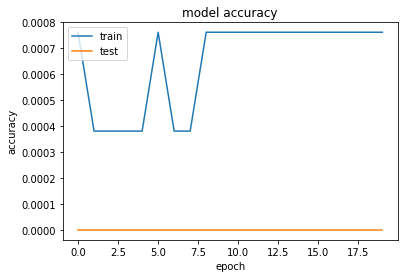

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       285   7            253380.375  304681.836115


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3942 samples, validate on 18 samples
Epoch 1/20
3942/3942 [==============================] - 0s 94us/step - loss: 0.0914 - acc: 2.5368e-04 - val_loss: 0.0237 - val_acc: 0.0000e+00
Epoch 2/20
3942/3942 [==============================] - 0s 45us/step - loss: 0.0405 - acc: 5.0736e-04 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 3/20
3942/3942 [==============================] - 0s 38us/step - l

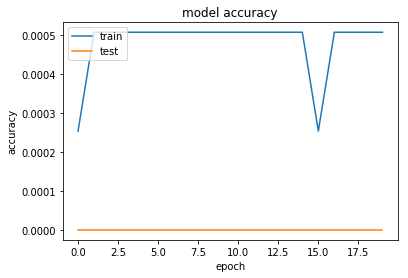

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       285   8            563537.375  683141.250312


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6600 samples, validate on 30 samples
Epoch 1/20
6600/6600 [==============================] - 1s 78us/step - loss: 0.0969 - acc: 3.0303e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/20
6600/6600 [==============================] - 0s 48us/step - loss: 0.0253 - acc: 3.0303e-04 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 3/20
6600/6600 [==============================] - 0s 42us/step - l

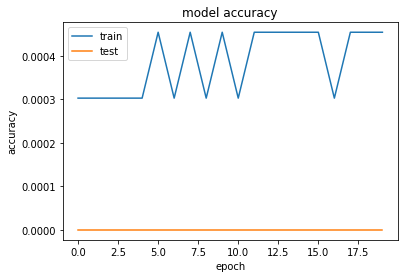

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       286   4            608616.375  685357.717838


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6600 samples, validate on 30 samples
Epoch 1/20
6600/6600 [==============================] - 0s 76us/step - loss: 0.0753 - acc: 3.0303e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 2/20
6600/6600 [==============================] - 0s 44us/step - loss: 0.0209 - acc: 6.0606e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 3/20
6600/6600 [==============================] - 0s 39us/step - l

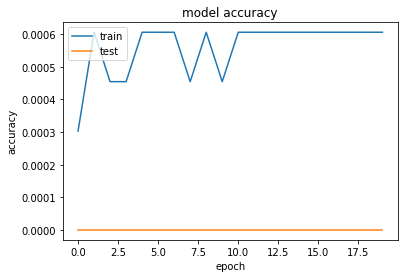

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       286   5          377876.59375  419394.112919


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2640 samples, validate on 12 samples
Epoch 1/20
2640/2640 [==============================] - 0s 135us/step - loss: 0.1706 - acc: 3.7879e-04 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 2/20
2640/2640 [==============================] - 0s 39us/step - loss: 0.0965 - acc: 3.7879e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/20
2640/2640 [==============================] - 0s 46us/step - 

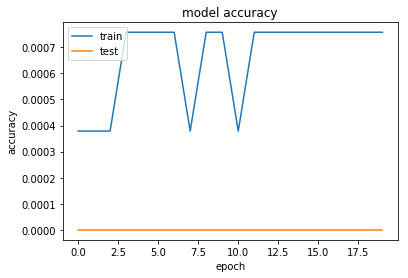

   testWeek  DC  Nplus2CUBEPrediction   Nplus2CUBE
0       286   7          232364.09375  222485.2437


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3960 samples, validate on 18 samples
Epoch 1/20
3960/3960 [==============================] - 0s 108us/step - loss: 0.1590 - acc: 0.0000e+00 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 2/20
3960/3960 [==============================] - 0s 44us/step - loss: 0.0725 - acc: 5.0505e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
3960/3960 [==============================] - 0s 39us/step - 

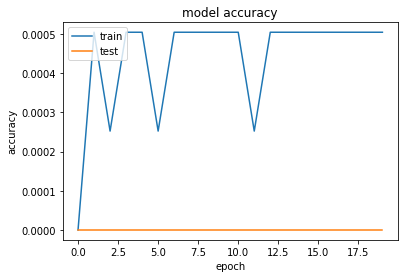

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       286   8           603111.0625  591875.110229


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6630 samples, validate on 30 samples
Epoch 1/20
6630/6630 [==============================] - 0s 75us/step - loss: 0.0964 - acc: 4.5249e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 2/20
6630/6630 [==============================] - 0s 44us/step - loss: 0.0245 - acc: 4.5249e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 3/20
6630/6630 [==============================] - 0s 38us/step - l

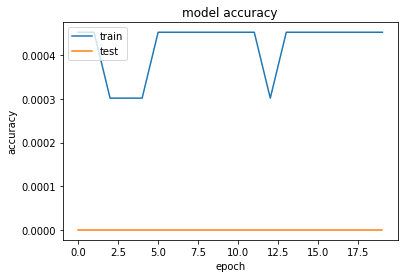

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       287   4           608247.1875  633634.863047


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6630 samples, validate on 30 samples
Epoch 1/20
6630/6630 [==============================] - 0s 72us/step - loss: 0.0728 - acc: 4.5249e-04 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 2/20
6630/6630 [==============================] - 0s 42us/step - loss: 0.0195 - acc: 4.5249e-04 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 3/20
6630/6630 [==============================] - 0s 40us/step - l

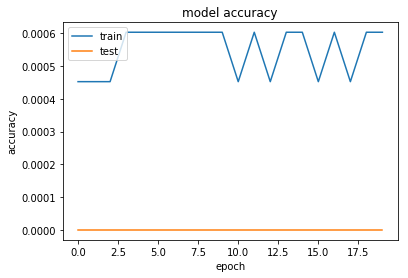

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       287   5          355447.53125  398964.913862


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2652 samples, validate on 12 samples
Epoch 1/20
2652/2652 [==============================] - 0s 118us/step - loss: 0.3969 - acc: 3.7707e-04 - val_loss: 0.0615 - val_acc: 0.0000e+00
Epoch 2/20
2652/2652 [==============================] - 0s 47us/step - loss: 0.1147 - acc: 3.7707e-04 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 3/20
2652/2652 [==============================] - 0s 35us/step - 

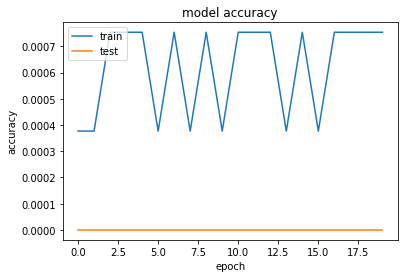

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       287   7           237525.4375  221075.662436


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3978 samples, validate on 18 samples
Epoch 1/20
3978/3978 [==============================] - 0s 94us/step - loss: 0.0750 - acc: 2.5138e-04 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 2/20
3978/3978 [==============================] - 0s 39us/step - loss: 0.0353 - acc: 2.5138e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 3/20
3978/3978 [==============================] - 0s 43us/step - l

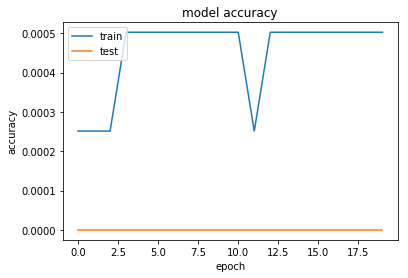

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       287   8           563853.3125  550790.775609


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6660 samples, validate on 30 samples
Epoch 1/20
6660/6660 [==============================] - 0s 70us/step - loss: 0.1119 - acc: 1.5015e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 2/20
6660/6660 [==============================] - 0s 41us/step - loss: 0.0248 - acc: 3.0030e-04 - val_loss: 7.4222e-04 - val_acc: 0.0000e+00
Epoch 3/20
6660/6660 [==============================] - 0s 40us/step

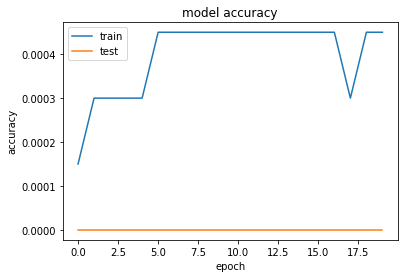

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       288   4          497751.21875  523072.146106


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6660 samples, validate on 30 samples
Epoch 1/20
6660/6660 [==============================] - 0s 74us/step - loss: 0.0583 - acc: 4.5045e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 2/20
6660/6660 [==============================] - 0s 42us/step - loss: 0.0151 - acc: 4.5045e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 3/20
6660/6660 [==============================] - 0s 48us/step - l

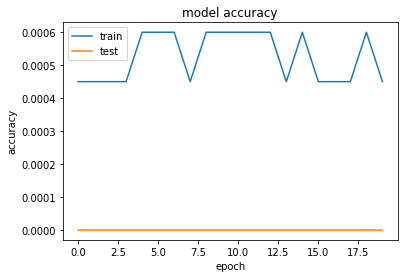

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       288   5              328660.0  335857.803441


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2664 samples, validate on 12 samples
Epoch 1/20
2664/2664 [==============================] - 0s 121us/step - loss: 0.2816 - acc: 3.7538e-04 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 2/20
2664/2664 [==============================] - 0s 44us/step - loss: 0.1097 - acc: 3.7538e-04 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 3/20
2664/2664 [==============================] - 0s 41us/step - 

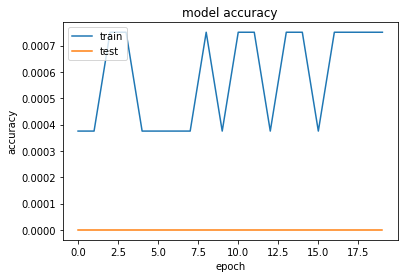

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       288   7          208066.21875  188019.825449


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 3996 samples, validate on 18 samples
Epoch 1/20
3996/3996 [==============================] - 0s 96us/step - loss: 0.1824 - acc: 5.0050e-04 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 2/20
3996/3996 [==============================] - 0s 45us/step - loss: 0.0849 - acc: 5.0050e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 3/20
3996/3996 [==============================] - 0s 40us/step - l

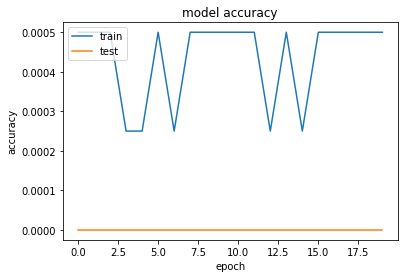

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       288   8           551710.3125  462602.547586


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6690 samples, validate on 30 samples
Epoch 1/20
6690/6690 [==============================] - 0s 72us/step - loss: 0.1087 - acc: 2.9895e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/20
6690/6690 [==============================] - 0s 42us/step - loss: 0.0259 - acc: 2.9895e-04 - val_loss: 6.4672e-04 - val_acc: 0.0000e+00
Epoch 3/20
6690/6690 [==============================] - 0s 40us/step

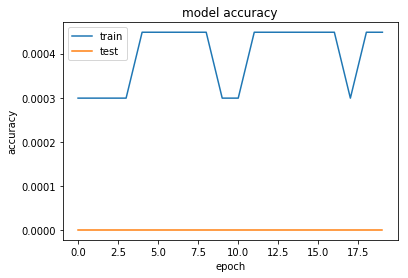

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       289   4          497989.21875  460133.286536


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6690 samples, validate on 30 samples
Epoch 1/20
6690/6690 [==============================] - 0s 72us/step - loss: 0.0858 - acc: 2.9895e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 2/20
6690/6690 [==============================] - 0s 42us/step - loss: 0.0205 - acc: 4.4843e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 3/20
6690/6690 [==============================] - 0s 38us/step - l

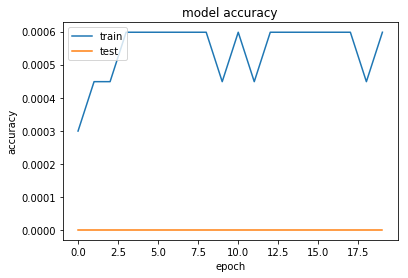

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       289   5          322171.71875  310954.99832


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2676 samples, validate on 12 samples
Epoch 1/20
2676/2676 [==============================] - 0s 122us/step - loss: 0.8103 - acc: 0.0000e+00 - val_loss: 0.2652 - val_acc: 0.0000e+00
Epoch 2/20
2676/2676 [==============================] - 0s 41us/step - loss: 0.2259 - acc: 0.0000e+00 - val_loss: 0.0465 - val_acc: 0.0000e+00
Epoch 3/20
2676/2676 [==============================] - 0s 37us/step - 

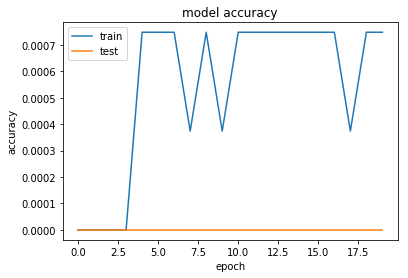

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       289   7         206269.328125  167800.898193


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4014 samples, validate on 18 samples
Epoch 1/20
4014/4014 [==============================] - 0s 97us/step - loss: 0.0952 - acc: 2.4913e-04 - val_loss: 0.0125 - val_acc: 0.0000e+00
Epoch 2/20
4014/4014 [==============================] - 0s 42us/step - loss: 0.0455 - acc: 2.4913e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/20
4014/4014 [==============================] - 0s 40us/step - l

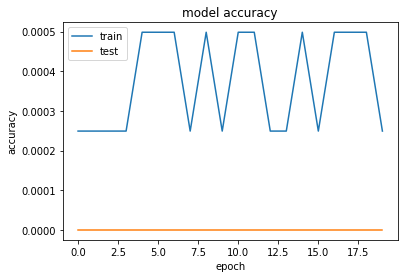

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       289   8           537243.9375  450844.464128


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6720 samples, validate on 30 samples
Epoch 1/20
6720/6720 [==============================] - 0s 71us/step - loss: 0.0940 - acc: 2.9762e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 2/20
6720/6720 [==============================] - 0s 41us/step - loss: 0.0223 - acc: 2.9762e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
6720/6720 [==============================] - 0s 37us/step - l

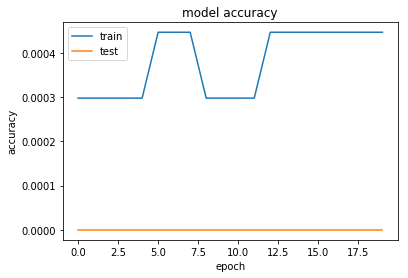

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       290   4          493136.03125  463851.367629


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6720 samples, validate on 30 samples
Epoch 1/20
6720/6720 [==============================] - 1s 77us/step - loss: 0.2995 - acc: 2.9762e-04 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 2/20
6720/6720 [==============================] - 0s 41us/step - loss: 0.0395 - acc: 4.4643e-04 - val_loss: 0.0091 - val_acc: 0.0000e+00
Epoch 3/20
6720/6720 [==============================] - 0s 36us/step - l

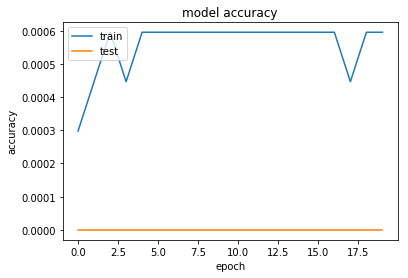

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       290   5          312521.15625  327053.814916


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2688 samples, validate on 12 samples
Epoch 1/20
2688/2688 [==============================] - 0s 122us/step - loss: 0.1257 - acc: 3.7202e-04 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 2/20
2688/2688 [==============================] - 0s 43us/step - loss: 0.0724 - acc: 7.4405e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
2688/2688 [==============================] - 0s 42us/step - 

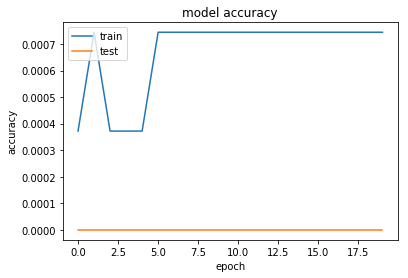

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       290   7         184198.453125  165283.630631


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4032 samples, validate on 18 samples
Epoch 1/20
4032/4032 [==============================] - 0s 97us/step - loss: 0.1269 - acc: 4.9603e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 2/20
4032/4032 [==============================] - 0s 43us/step - loss: 0.0577 - acc: 2.4802e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 3/20
4032/4032 [==============================] - 0s 38us/step - l

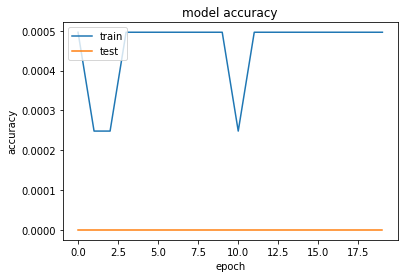

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       290   8             510264.25  450414.002268


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6750 samples, validate on 30 samples
Epoch 1/20
6750/6750 [==============================] - 0s 70us/step - loss: 0.0612 - acc: 2.9630e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 2/20
6750/6750 [==============================] - 0s 37us/step - loss: 0.0159 - acc: 2.9630e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
6750/6750 [==============================] - 0s 36us/step - l

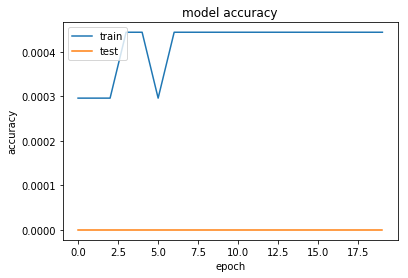

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       291   4           459988.4375  442250.804656


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6750 samples, validate on 30 samples
Epoch 1/20
6750/6750 [==============================] - 0s 70us/step - loss: 0.0994 - acc: 4.4444e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 2/20
6750/6750 [==============================] - 0s 41us/step - loss: 0.0240 - acc: 4.4444e-04 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/20
6750/6750 [==============================] - 0s 38us/step - l

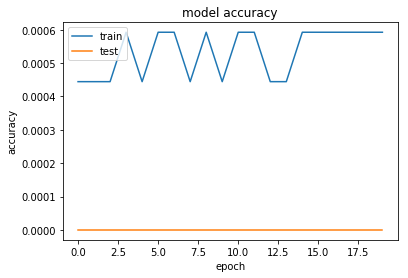

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       291   5          335259.71875  304359.007068


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2700 samples, validate on 12 samples
Epoch 1/20
2700/2700 [==============================] - 0s 120us/step - loss: 1.0213 - acc: 3.7037e-04 - val_loss: 0.3137 - val_acc: 0.0000e+00
Epoch 2/20
2700/2700 [==============================] - 0s 43us/step - loss: 0.2769 - acc: 0.0000e+00 - val_loss: 0.0627 - val_acc: 0.0000e+00
Epoch 3/20
2700/2700 [==============================] - 0s 37us/step - 

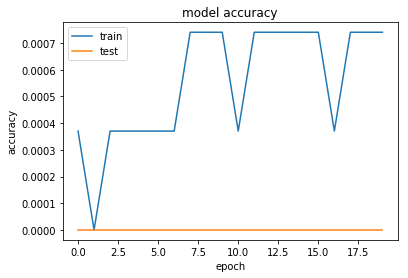

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       291   7          200733.28125  170749.74096


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4050 samples, validate on 18 samples
Epoch 1/20
4050/4050 [==============================] - 0s 98us/step - loss: 0.1307 - acc: 2.4691e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 2/20
4050/4050 [==============================] - 0s 42us/step - loss: 0.0497 - acc: 2.4691e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 3/20
4050/4050 [==============================] - 0s 40us/step - l

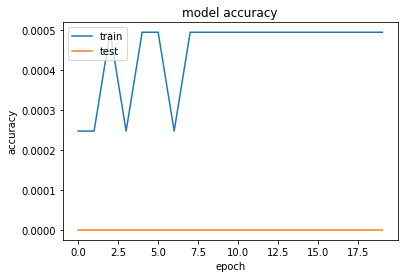

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       291   8          449226.65625  422456.397361


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6780 samples, validate on 30 samples
Epoch 1/20
6780/6780 [==============================] - 0s 72us/step - loss: 0.0747 - acc: 2.9499e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 2/20
6780/6780 [==============================] - 0s 38us/step - loss: 0.0192 - acc: 2.9499e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/20
6780/6780 [==============================] - 0s 36us/step - l

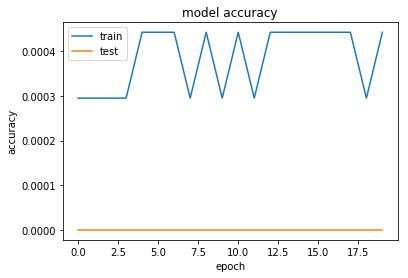

   testWeek  DC  Nplus2CUBEPrediction    Nplus2CUBE
0       292   4              397213.0  430553.96013


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6780 samples, validate on 30 samples
Epoch 1/20
6780/6780 [==============================] - 0s 72us/step - loss: 0.1942 - acc: 4.4248e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 2/20
6780/6780 [==============================] - 0s 41us/step - loss: 0.0265 - acc: 4.4248e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 3/20
6780/6780 [==============================] - 0s 39us/step - l

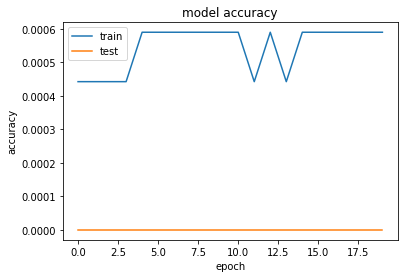

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       292   5           304730.1875  283078.906799


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2712 samples, validate on 12 samples
Epoch 1/20
2712/2712 [==============================] - 0s 119us/step - loss: 0.1019 - acc: 3.6873e-04 - val_loss: 0.0138 - val_acc: 0.0000e+00
Epoch 2/20
2712/2712 [==============================] - 0s 42us/step - loss: 0.0619 - acc: 3.6873e-04 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 3/20
2712/2712 [==============================] - 0s 38us/step - 

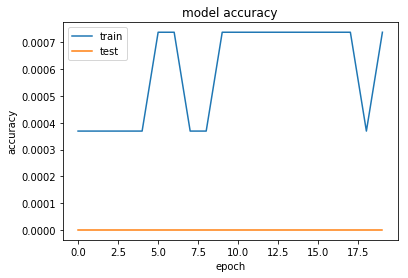

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       292   7           173878.1875  164041.549519


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4068 samples, validate on 18 samples
Epoch 1/20
4068/4068 [==============================] - 0s 92us/step - loss: 1.4315 - acc: 2.4582e-04 - val_loss: 0.3771 - val_acc: 0.0000e+00
Epoch 2/20
4068/4068 [==============================] - 0s 42us/step - loss: 0.2484 - acc: 2.4582e-04 - val_loss: 0.0307 - val_acc: 0.0000e+00
Epoch 3/20
4068/4068 [==============================] - 0s 39us/step - l

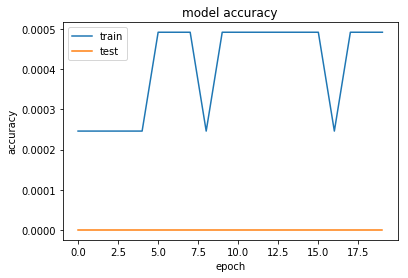

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       292   8          412256.90625  371756.577774


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6810 samples, validate on 30 samples
Epoch 1/20
6810/6810 [==============================] - 0s 70us/step - loss: 0.0960 - acc: 2.9369e-04 - val_loss: 8.1065e-04 - val_acc: 0.0000e+00
Epoch 2/20
6810/6810 [==============================] - 0s 42us/step - loss: 0.0261 - acc: 2.9369e-04 - val_loss: 7.3125e-04 - val_acc: 0.0000e+00
Epoch 3/20
6810/6810 [==============================] - 0s 40us/

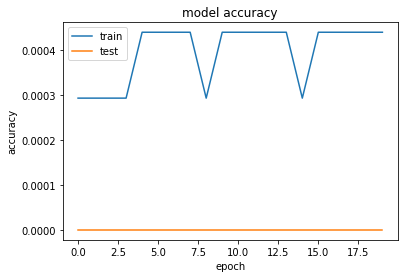

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       293   4          390462.78125  438750.968362


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6810 samples, validate on 30 samples
Epoch 1/20
6810/6810 [==============================] - 1s 74us/step - loss: 0.1685 - acc: 4.4053e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 2/20
6810/6810 [==============================] - 0s 44us/step - loss: 0.0445 - acc: 5.8737e-04 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/20
6810/6810 [==============================] - 0s 41us/step - l

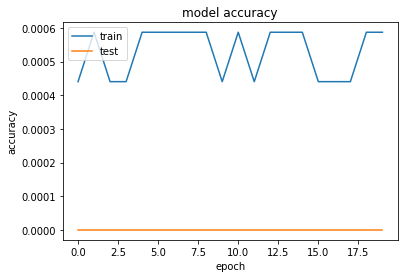

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       293   5          276510.03125  303604.788614


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 2724 samples, validate on 12 samples
Epoch 1/20
2724/2724 [==============================] - 0s 124us/step - loss: 0.1710 - acc: 7.3421e-04 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 2/20
2724/2724 [==============================] - 0s 38us/step - loss: 0.0922 - acc: 3.6711e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 3/20
2724/2724 [==============================] - 0s 38us/step - 

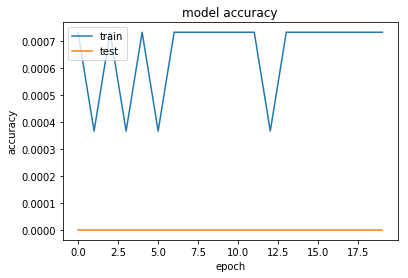

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       293   7         162178.203125  181488.343008


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 4086 samples, validate on 18 samples
Epoch 1/20
4086/4086 [==============================] - 0s 93us/step - loss: 0.0951 - acc: 2.4474e-04 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 2/20
4086/4086 [==============================] - 0s 43us/step - loss: 0.0456 - acc: 2.4474e-04 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 3/20
4086/4086 [==============================] - 0s 39us/step - l

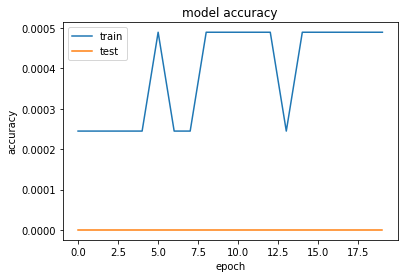

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       293   8            403655.625  430683.178994


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________
Train on 6840 samples, validate on 30 samples
Epoch 1/20
6840/6840 [==============================] - 0s 71us/step - loss: 0.0822 - acc: 2.9240e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/20
6840/6840 [==============================] - 0s 39us/step - loss: 0.0228 - acc: 2.9240e-04 - val_loss: 6.4355e-04 - val_acc: 0.0000e+00
Epoch 3/20
6840/6840 [==============================] - 0s 37us/step

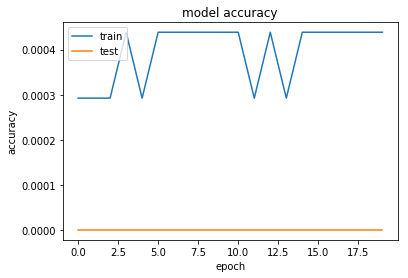

   testWeek  DC  Nplus2CUBEPrediction     Nplus2CUBE
0       294   4            370956.625  410863.350884


C:\Users\Alex\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1840      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#2 dataframes, one for N+1 and one for N+2
Nplus1 = pd.DataFrame(columns=['testWeek', 'DC', 'Nplus1CUBEPrediction', 'Nplus1CUBE'])
Nplus2 = pd.DataFrame(columns=['testWeek', 'DC', 'Nplus2CUBEPrediction', 'Nplus2CUBE'])
targets = [['Nplus1CUBE'],['Nplus2CUBE']]
for targetVar in targets:
    for testWeek in range(247,299):
        for DC in DCRegionPairs.keys():
            #targetVar = [targetVar]
            pred = DCPrediction(testWeek, DC, targetVar)
            print(pred)
            if (targetVar == targets[0]):
                Nplus1 = Nplus1.append(pred,ignore_index=True)
            else:
                Nplus2 = Nplus2.append(pred,ignore_index=True)

In [ ]:
Nplus1

In [ ]:
type(Nplus1)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    

In [ ]:
DC4Nplus1 = Nplus2.loc[Nplus2['DC'] == 4]


In [ ]:
DC4Nplus1MAPE = mean_absolute_percentage_error(DC4Nplus1[['Nplus2CUBE']].values, DC4Nplus1[['Nplus2CUBEPrediction']].values)

In [ ]:
DC4Nplus1MAPE

In [ ]:
for 